In [74]:
%%HTML
<div align='right'>
<script>
    code_show=true;
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
    </div>

# Lightning Data

We have varying amounts of data from the contiguous US from 1991 to 2015. These data are all available through the [THREDDS server](http://hydromet-thredds.princeton.edu:9000/thredds/catalog/data/Cloud_to_Ground_Lightning/catalog.html) but they are a little buried. Their combined size is about 50GB. If you download them locally, then accessing them through in python using xarray is as easy as 

    xr.open_mfdataset('path/to/data/2014_01_*.nc', concat_dim='record')
    
<img src="output/US_1991.png"/>

In [3]:
from __init__ import *
from plotting import *
from region import Region

%matplotlib inline

## Regional Aggregations
I am creating a toolbox with funtions to quickly compute the following:
 - Mean monthly CG flash density for a region; ~ 1km grid
 - Mean monthly diurnal cycle of CG flash density by month for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid
 - “Amplitude” of the diurnal cycle; 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 
 - Largest 100 CG flash density days (12 UTC - 12 UTC) for a region
 
## Storm Tracking
For 2D storm tracking I am relying on the r package SpatialVx. 

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

## Regional Aggregations
I am creating a toolbox with funtions to quickly compute the following:
 - Mean monthly CG flash density for a region; ~5km grid

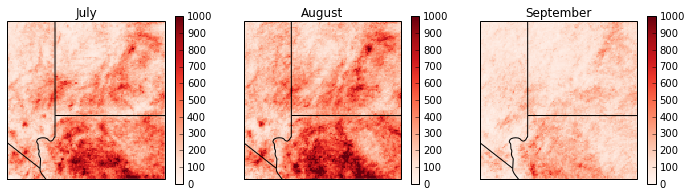

In [10]:
c = Region(city=cities['cedar'])
c.define_grid(nbins=120)

MMDC_grid = {}
MMFC_grid = {}
for m in range(1,13):
    ds = c.get_ds(m=m, grid=True)
    c.to_DC_grid(ds)
    ds.close()
    MMDC_grid.update({m: c.DC_grid})
    MMFC_grid.update({m: c.FC_grid})
    
plt.figure(figsize=(12, 3))
n=1
for m in [7,8,9]:
    ax = background(plt.subplot(1, 3, n, projection=ccrs.PlateCarree()))
    im, ax = c.plot_grid(MMFC_grid[m], cmap='Reds', vmin=0, vmax=1000, ax=ax)
    ax.set_title(months[m])
    plt.colorbar(im, ax=ax)
    n+=1

## Regional Aggregations
I am creating a toolbox with funtions to quickly compute the following:
 - Mean monthly CG flash density for a region; ~ 1km grid
 - Mean monthly diurnal cycle of CG flash density by month for a region

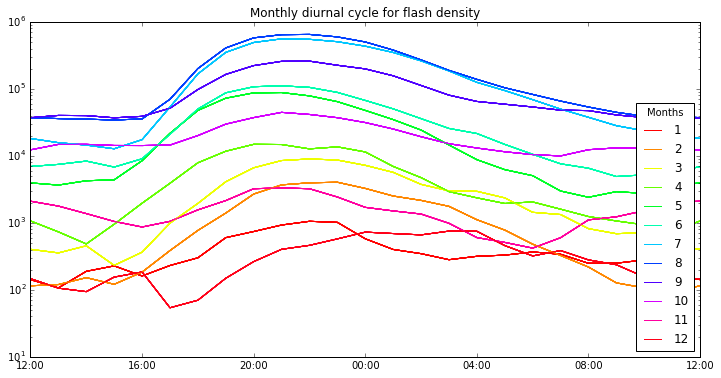

In [55]:
import matplotlib.cm as cm
h = range(12,24)
h.extend(range(0,13))

MMDC = pd.DataFrame(np.array([[np.sum(MMDC_grid[m][hr]) for hr in h] for m in months.keys()]).T)
MMDC.columns = range(1,13)

plt.figure(figsize=(12, 6))
for m in months.keys():
    ax = plt.subplot(1,1,1)
    MMDC.plot(color=cm.hsv(np.linspace(0, 1, 12)), ax=ax, title='Monthly diurnal cycle for flash density')
    plt.legend(range(1,13), title='Months', loc='lower right')
    ax.set_xticks(range(0,25,4))
    ax.set_xticklabels(['{num:02d}:00'.format(num=h[n]) for n in range(0,25,4)])
    ax.set_ylim(10**1, 10**6)
    ax.semilogy()
    ax.set_xlim(0,24)

## Regional Aggregations
I am creating a toolbox with funtions to quickly compute the following:
 - Mean monthly CG flash density for a region; ~ 1km grid
 - Mean monthly diurnal cycle of CG flash density by month for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid

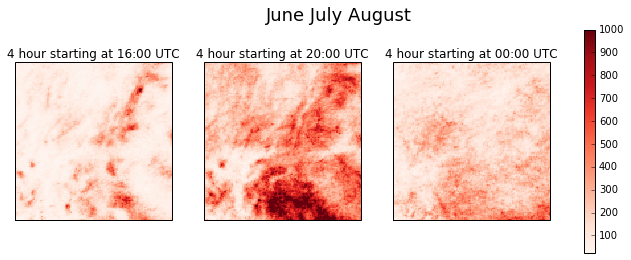

In [63]:
JJADC_grid = {}
for k,v in MMDC_grid[6].items():
    JJADC_grid.update({k: v + MMDC_grid[7][k]+MMDC_grid[8][k]})
plt.figure(figsize=(12, 4))
n=1
step = 4
axes = []
for i in range(4,16,step):
    q=np.zeros(JJADC_grid[0].shape)
    for hr in h[i:i+step]:
        q+=JJADC_grid[hr]
    ax = plt.subplot(1, 3, n, projection=ccrs.PlateCarree())
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    im, ax = c.plot_grid(q, cmap='Reds', vmax=1000, ax=ax)
    axes.append(ax)
    n+=1
plt.colorbar(im, ax=axes)
plt.suptitle('June July August', fontsize=18);

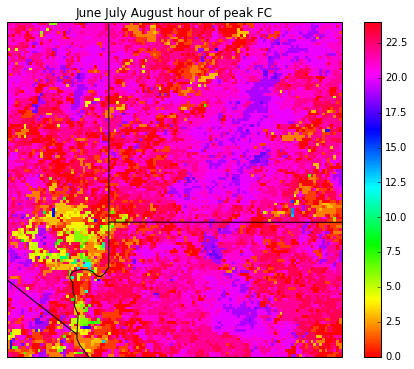

In [64]:
plt.figure(figsize=(8,6))
ax = plt.subplot(1,1, 1, projection=ccrs.PlateCarree())
ax = background(ax)

a = np.argmax(np.stack(JJADC_grid.values()), axis=0)
den = ax.pcolor(c.gridx, c.gridy, a, cmap='hsv', vmax=24)
ax.set_title('June July August hour of peak FC')
plt.colorbar(den, ax=ax);

## Regional Aggregations
I am creating a toolbox with funtions to quickly compute the following:
 - Mean monthly CG flash density for a region; ~ 1km grid
 - Mean monthly diurnal cycle of CG flash density by month for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid
 - “Amplitude” of the diurnal cycle; 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

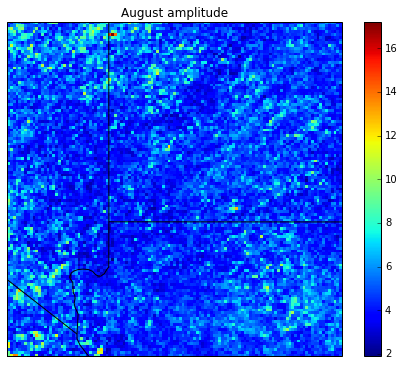

In [70]:
plt.figure(figsize=(8,6))
hourly3D = np.stack(MMDC_grid[8].values()) #np.stack(JJADC_grid.values())
amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
amplitude = np.nan_to_num(amplitude)
im, ax = c.plot_grid(amplitude, cmap='jet', cbar=True)
ax.set_title('August amplitude');

## Regional Aggregations
I am creating a toolbox with funtions to quickly compute the following:
 - Mean monthly CG flash density for a region; ~ 1km grid
 - Mean monthly diurnal cycle of CG flash density by month for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid
 - “Amplitude” of the diurnal cycle; 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 
 - Largest 100 CG flash density days (12 UTC - 12 UTC) for a region

In [71]:
top10 = c.get_top(10)
top10

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

## Storm Tracking
For 2D storm tracking I am relying on the r package SpatialVx. 

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 


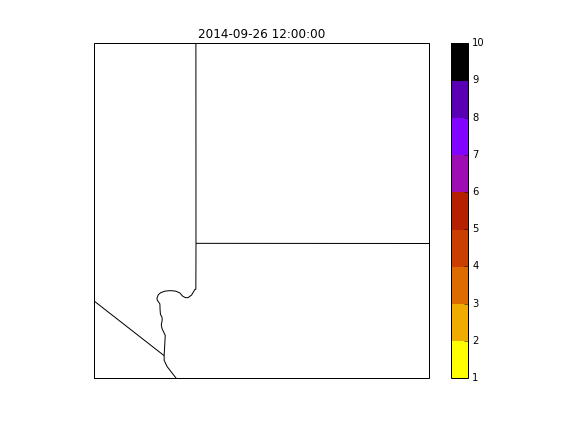
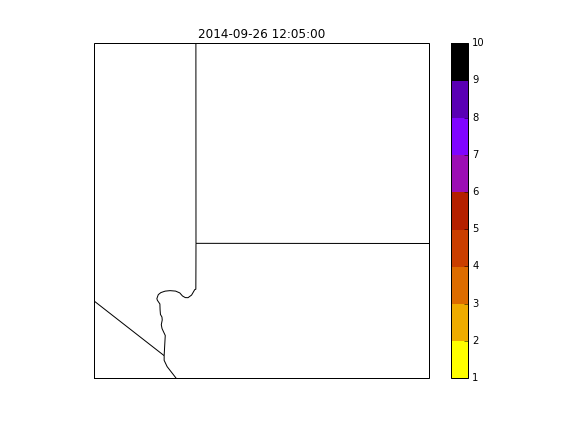
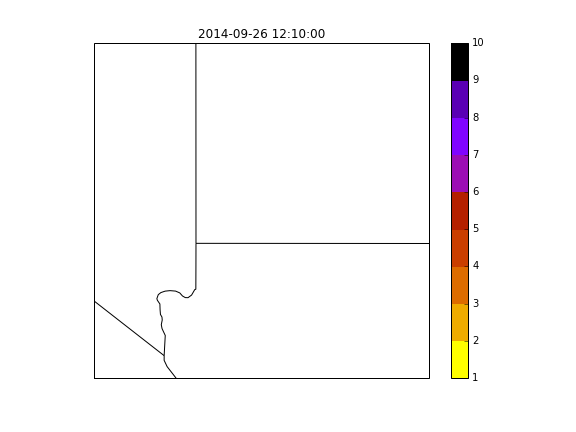
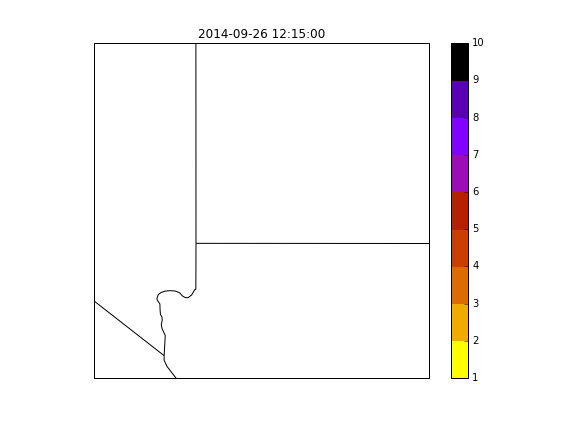
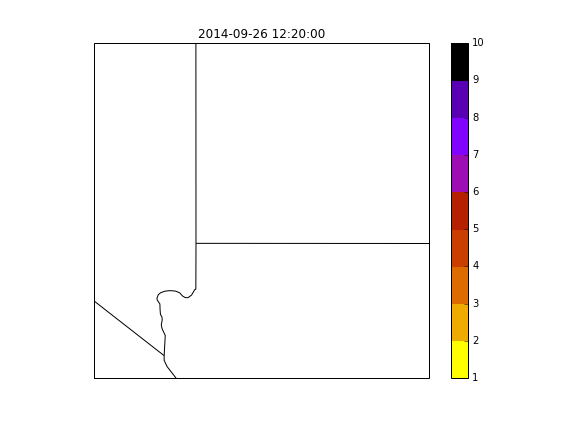
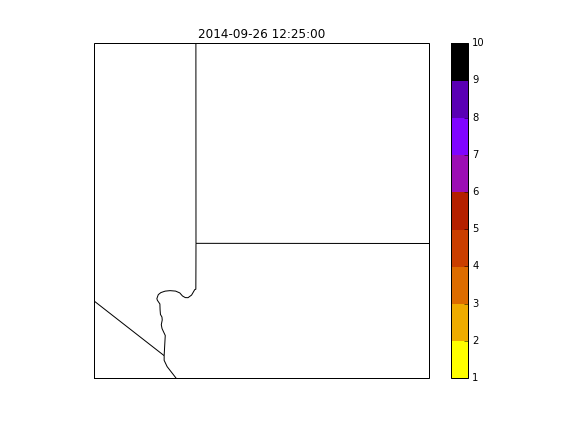
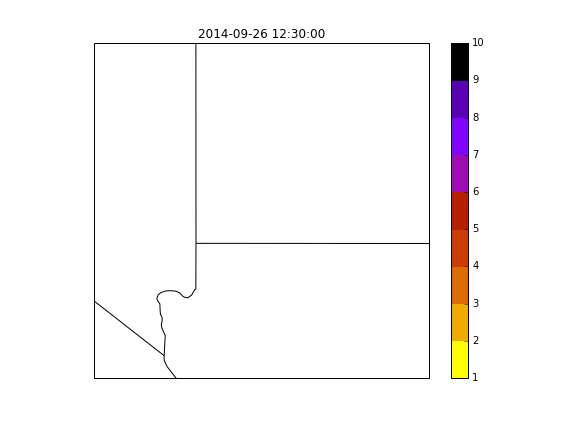
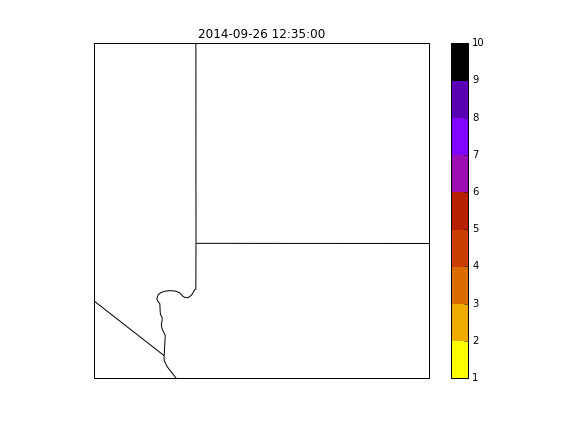
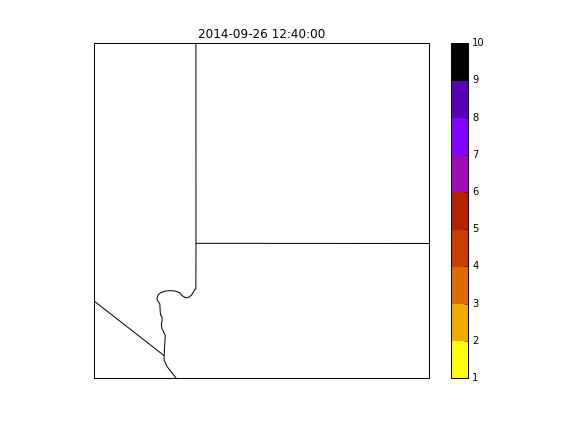
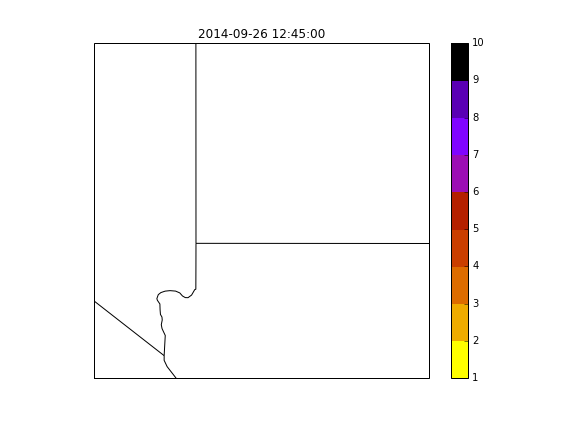
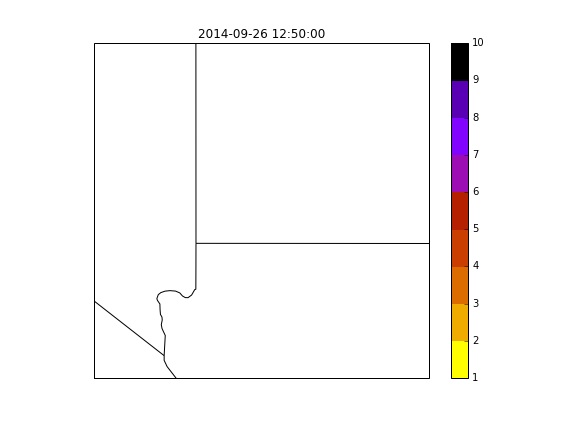
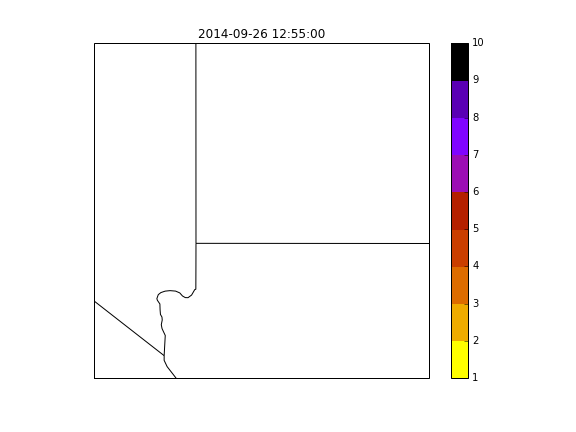
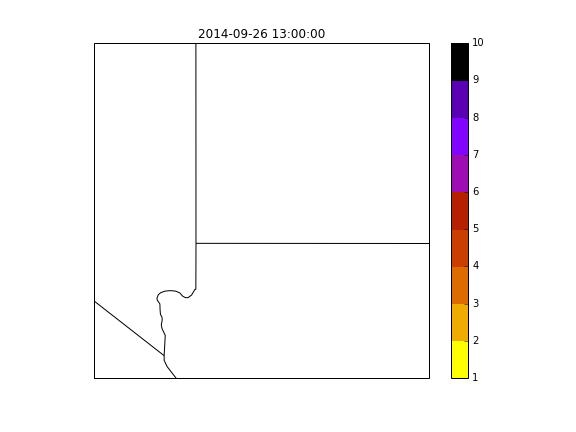
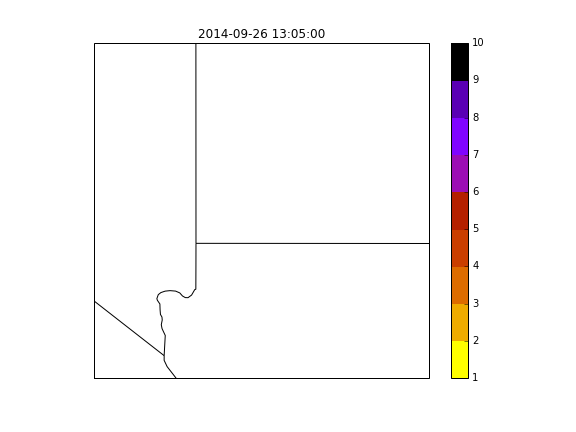
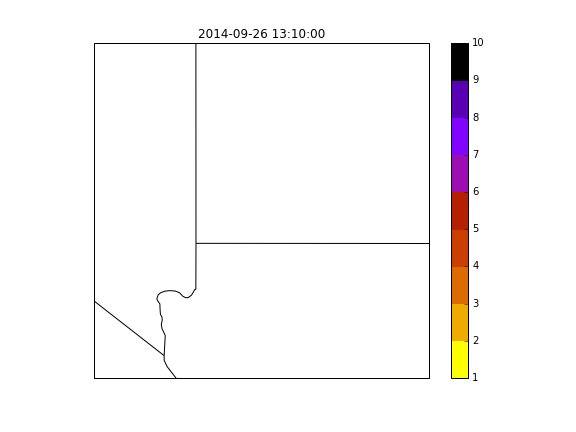
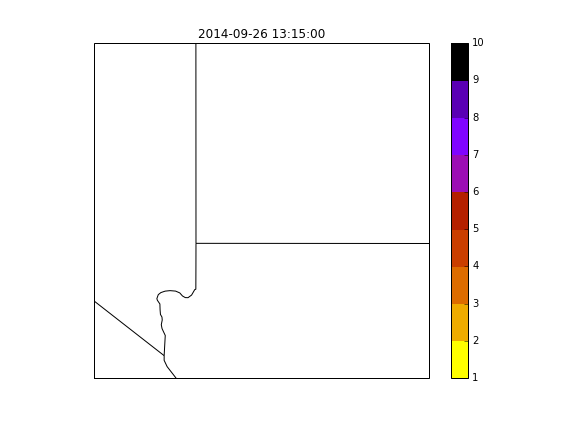
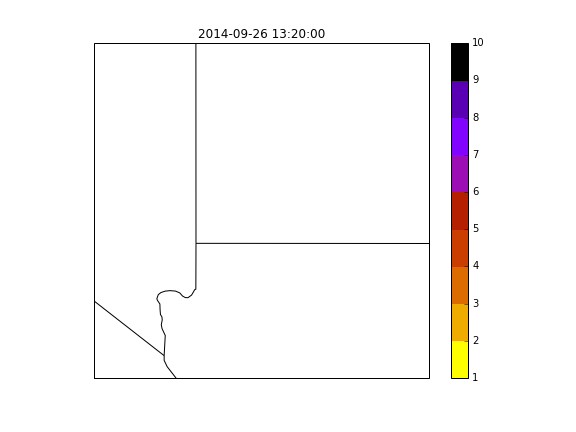
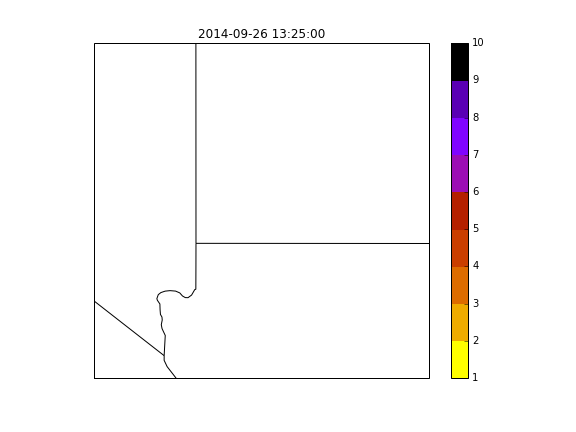
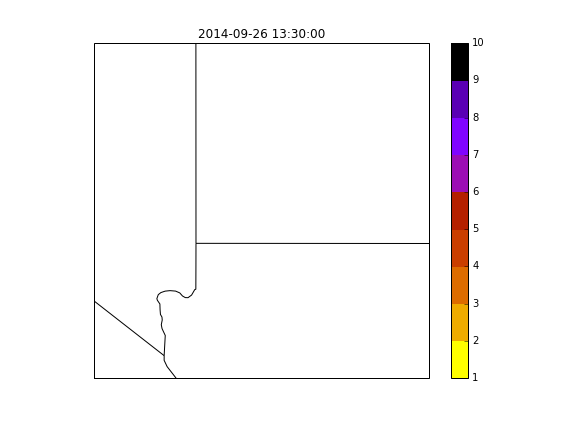
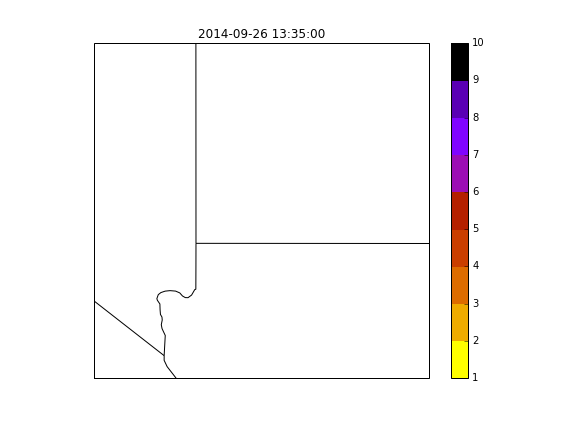
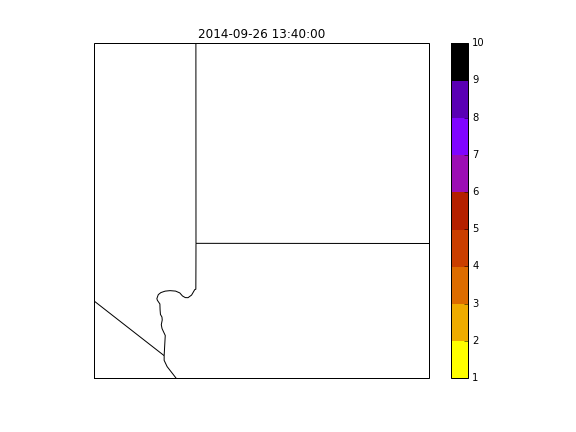
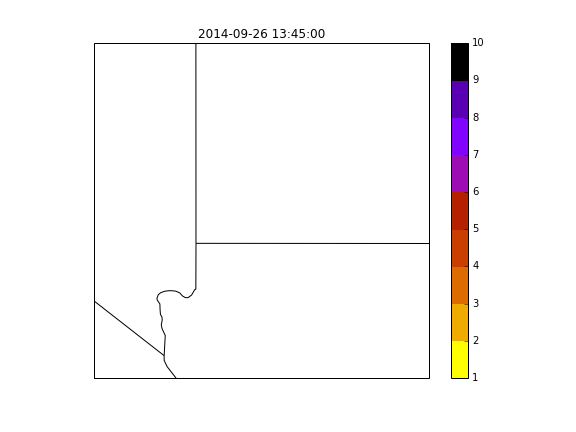
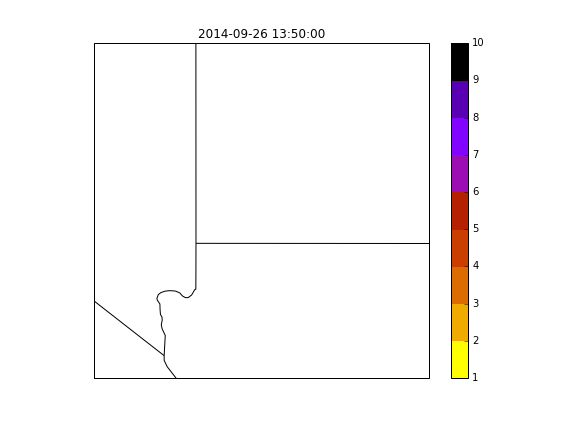
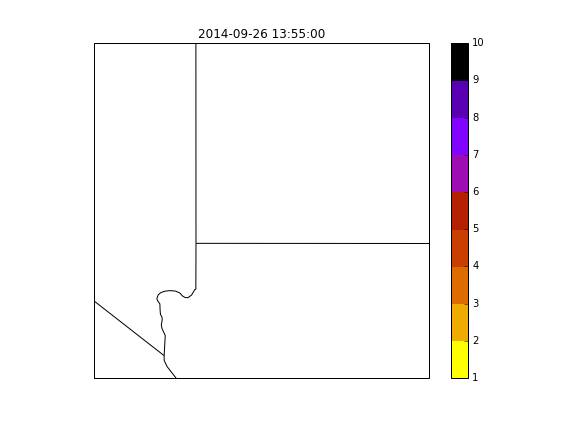
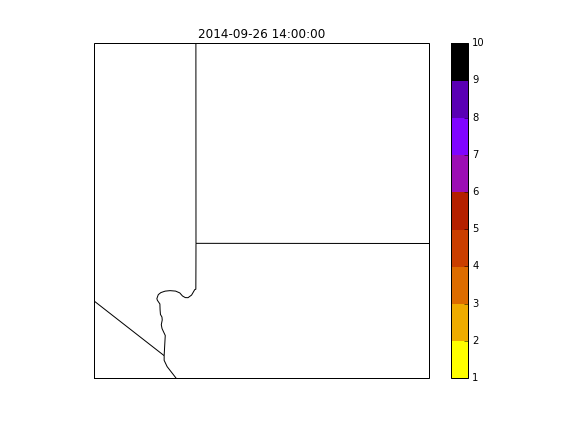
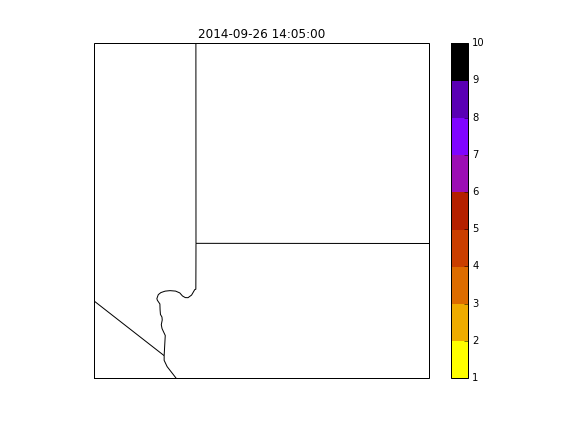
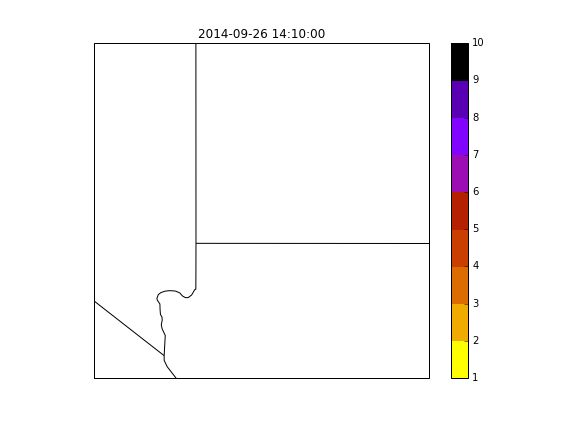
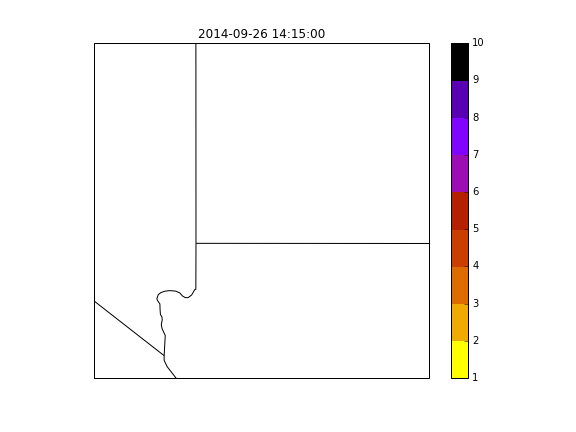
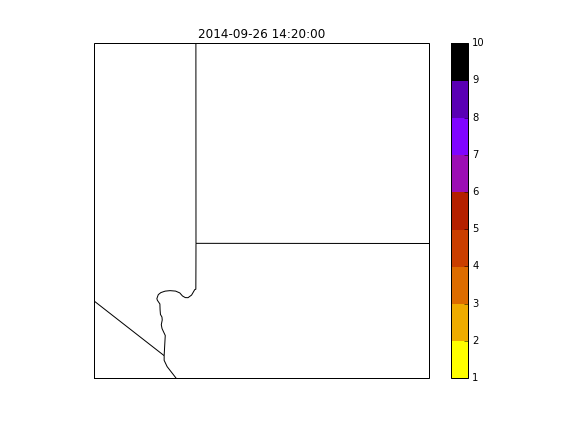
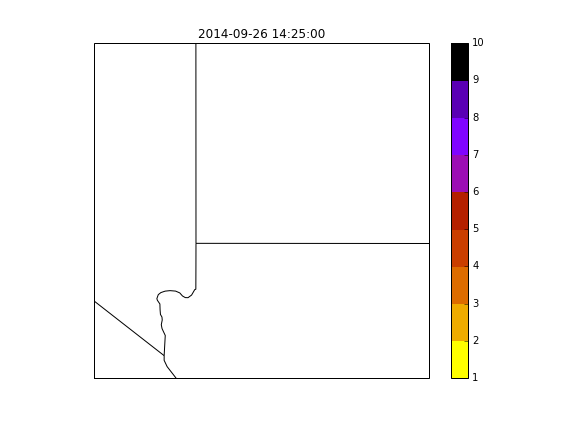
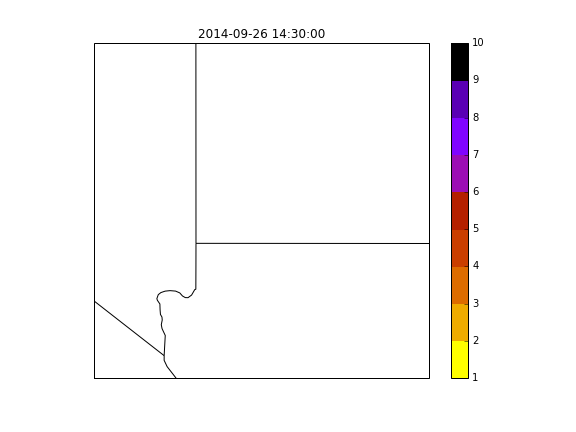
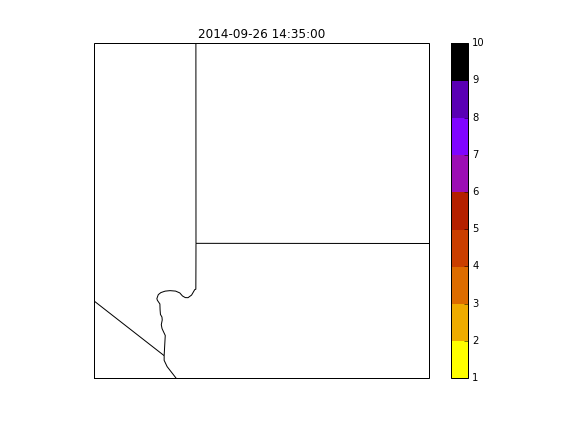
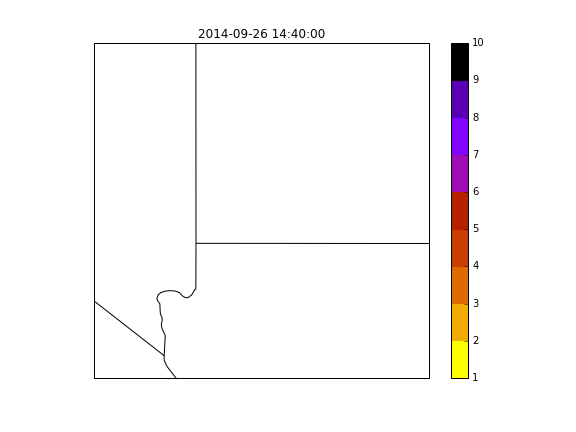
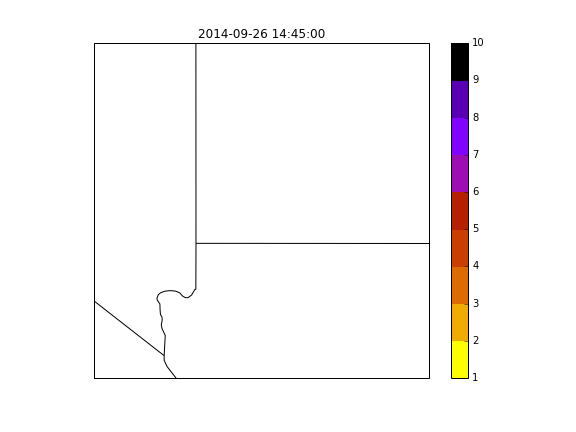
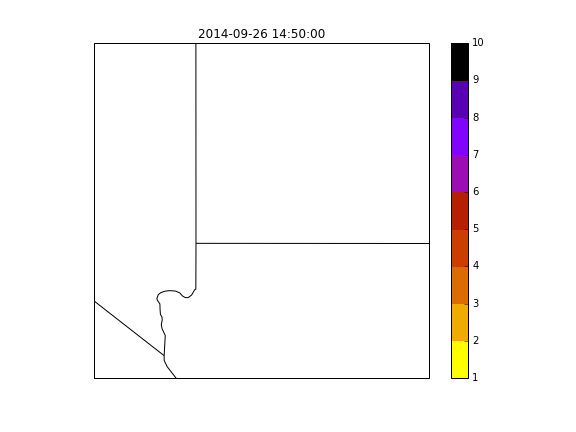
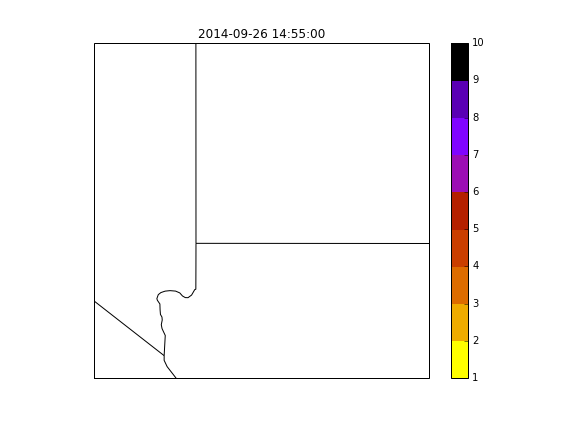
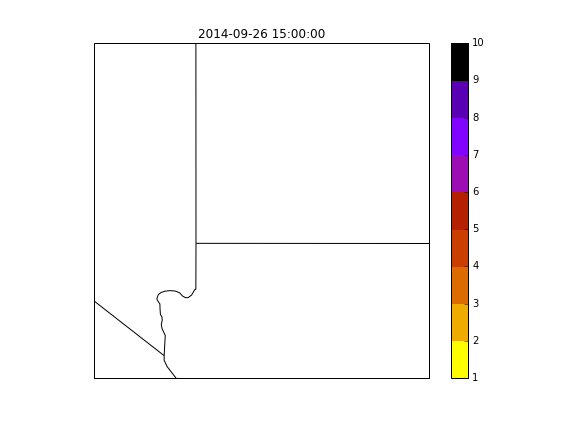
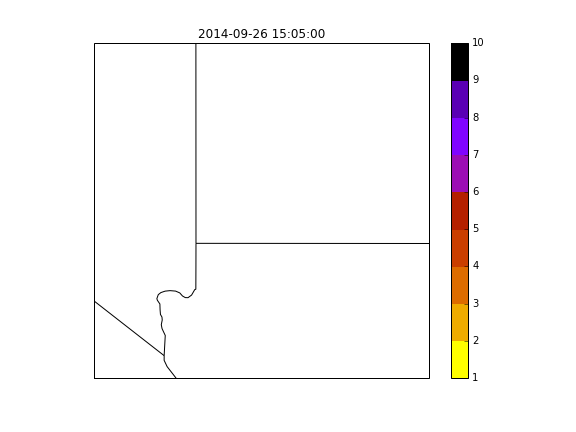
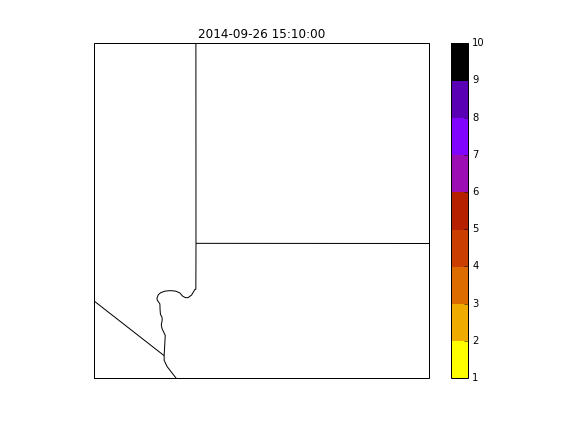
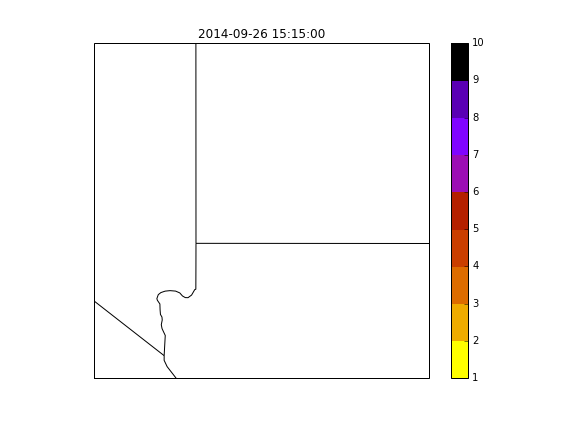
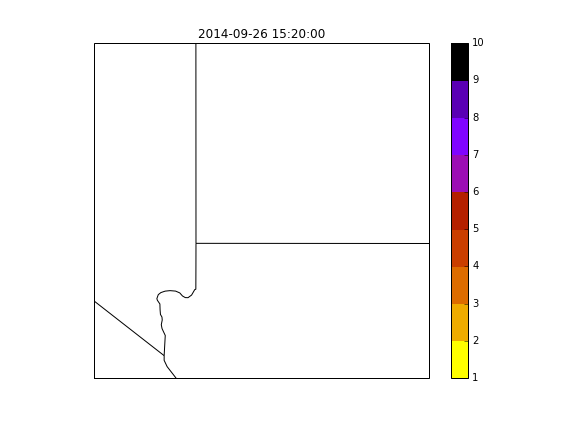
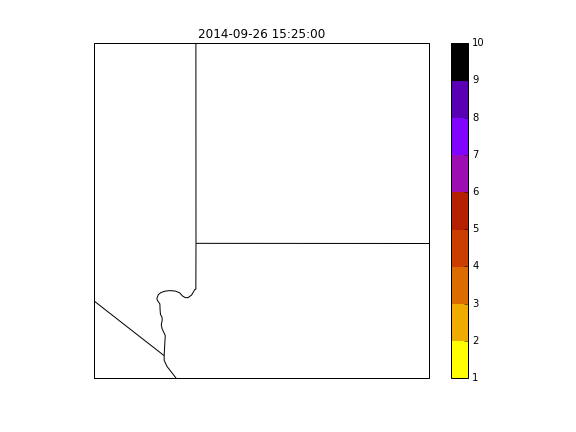
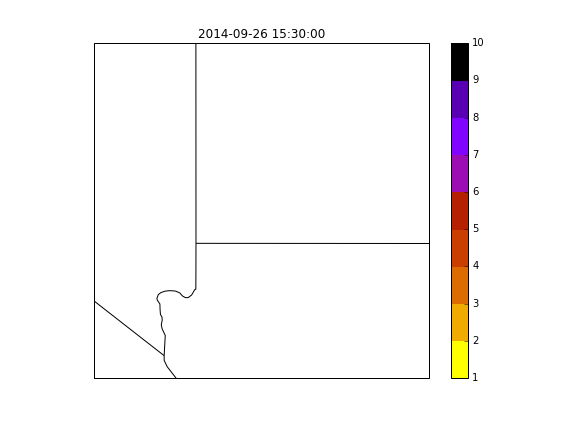
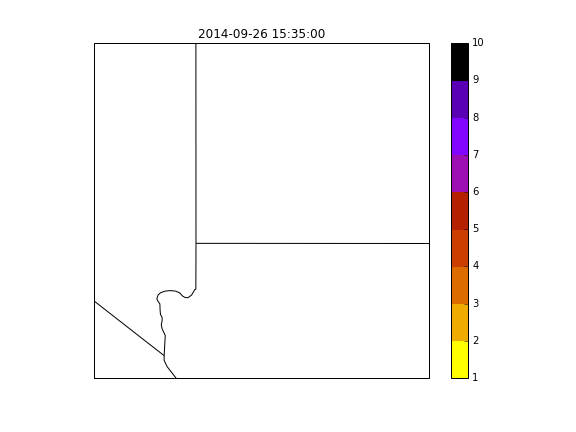
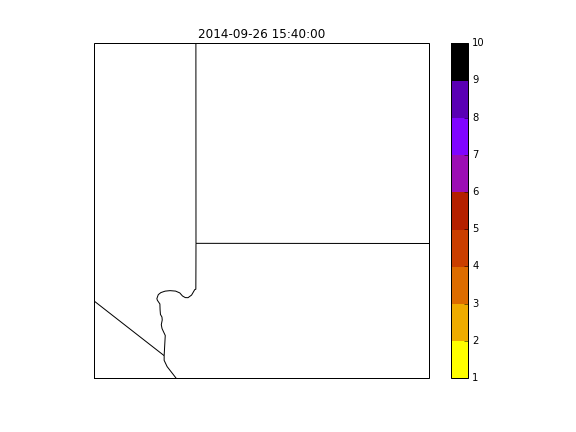
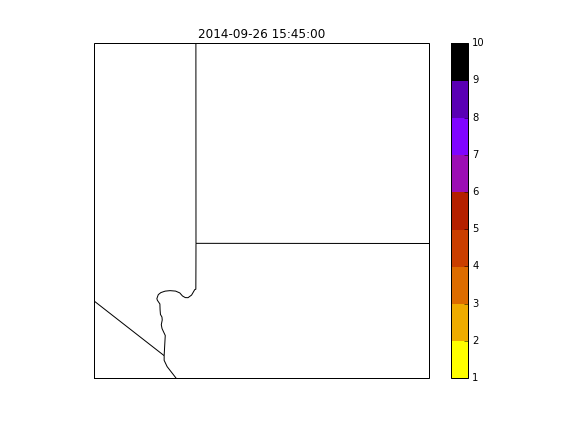
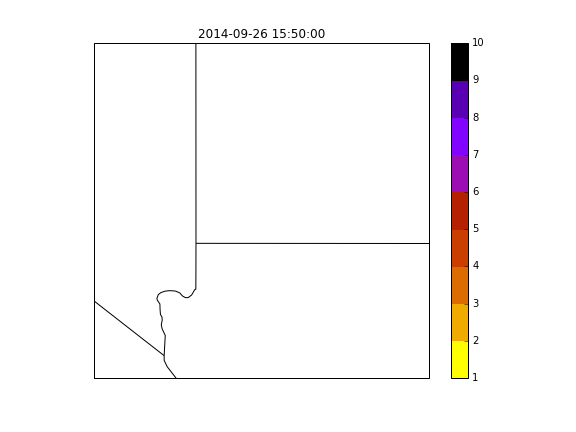
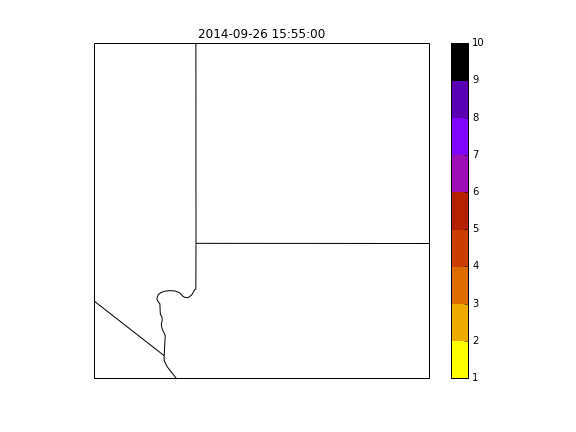
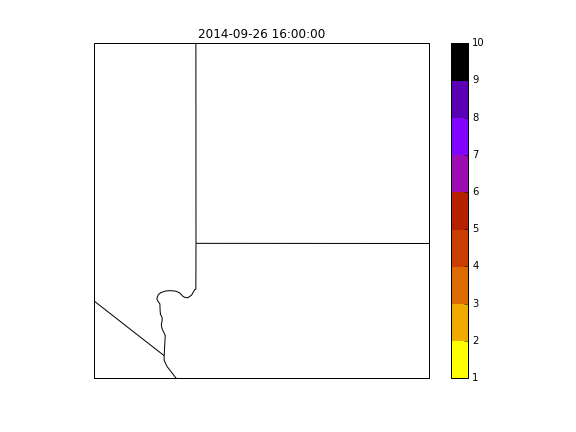
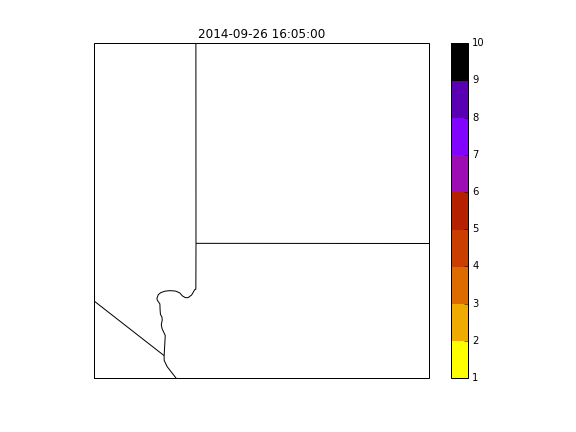
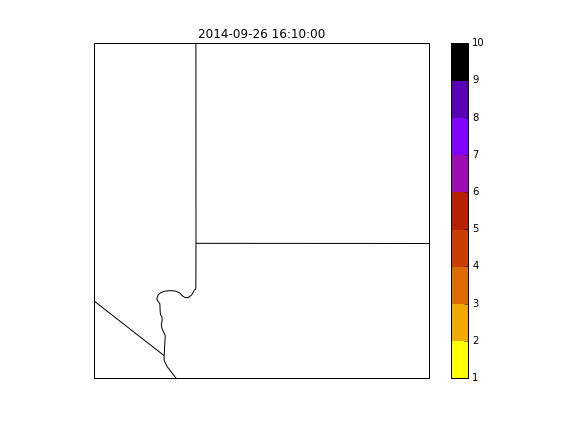
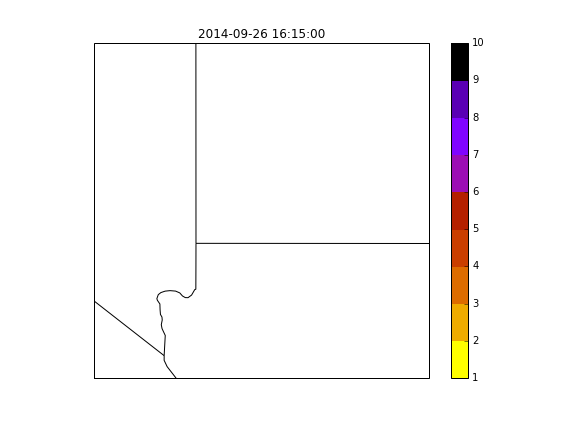
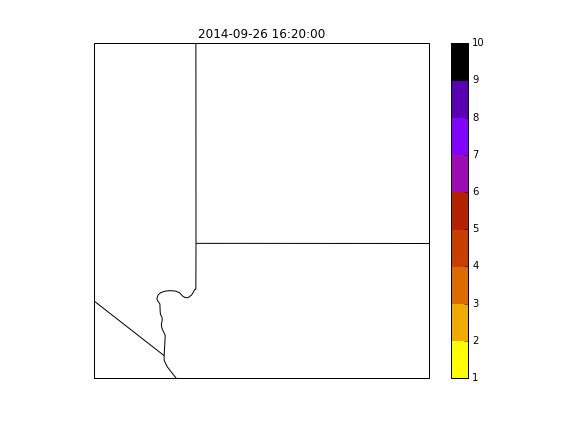
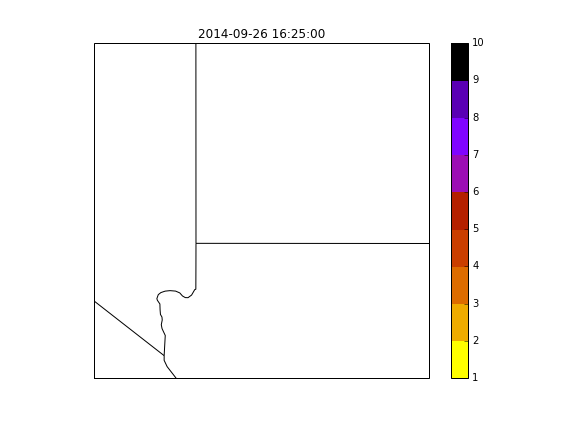
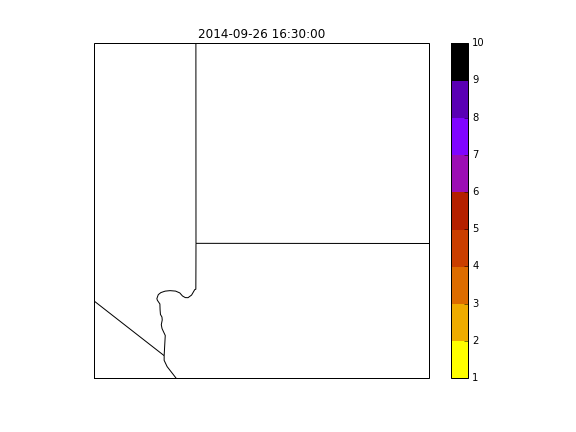
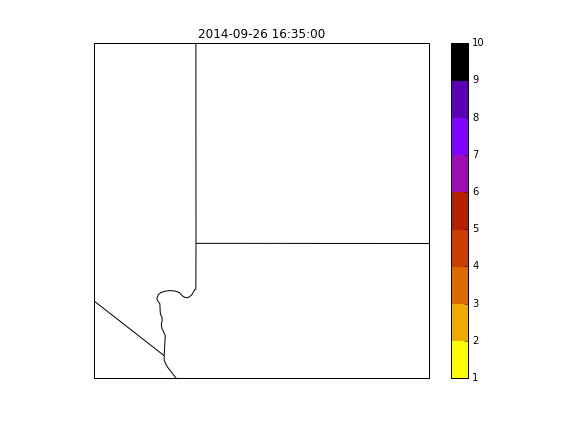
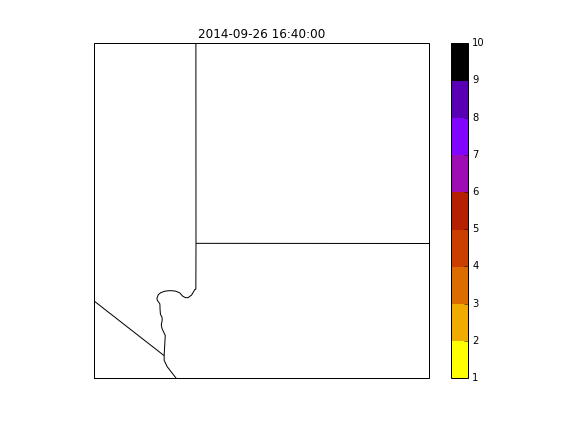
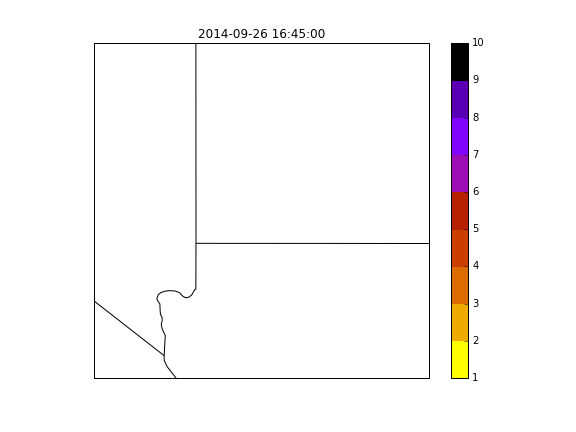
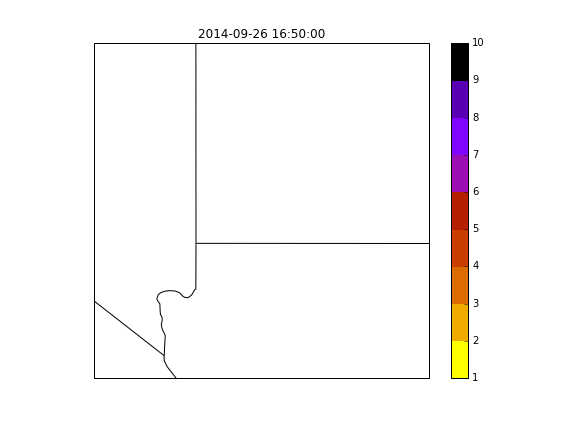
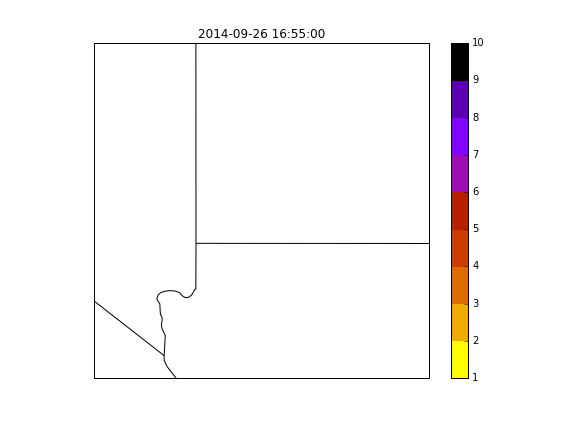
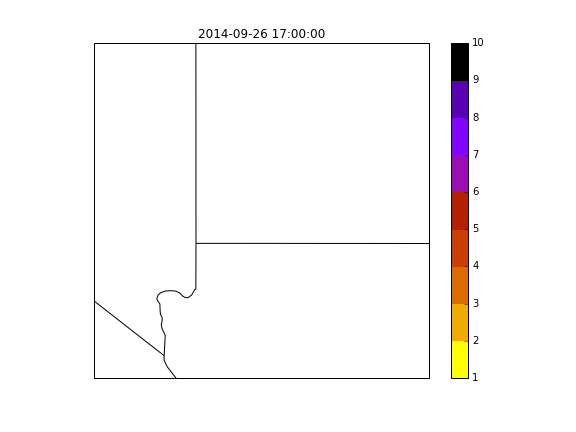
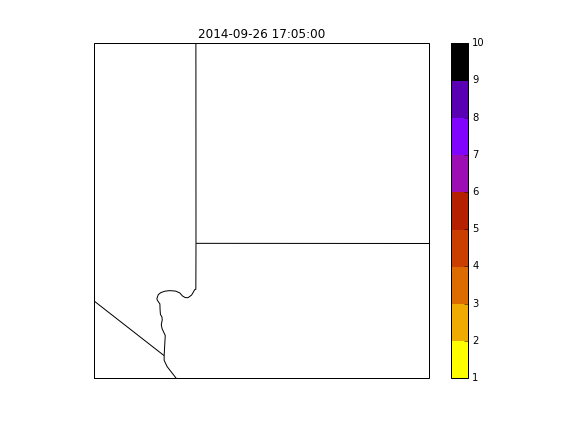
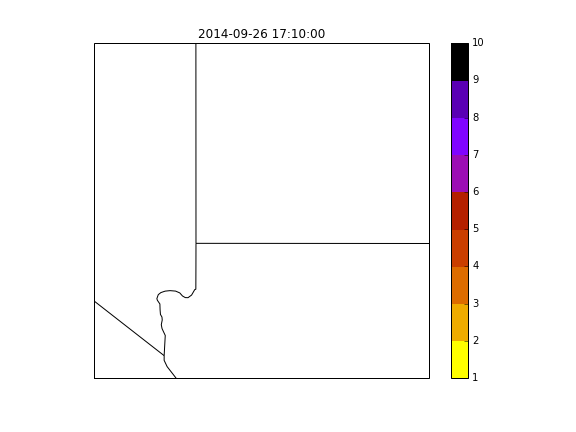
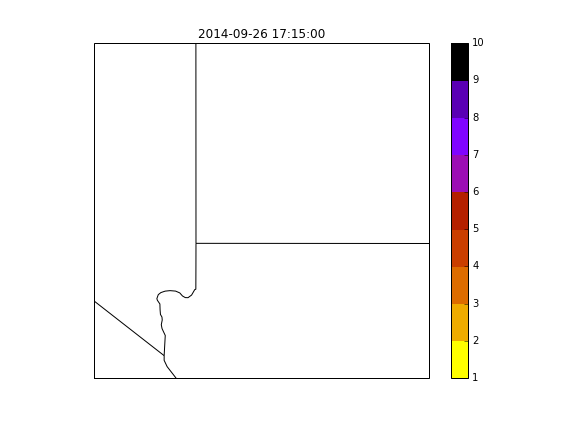
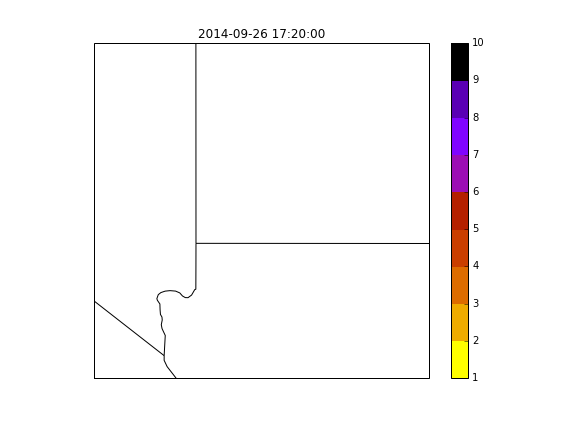
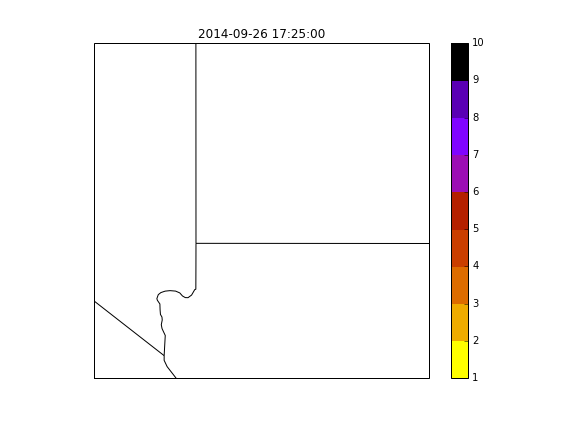
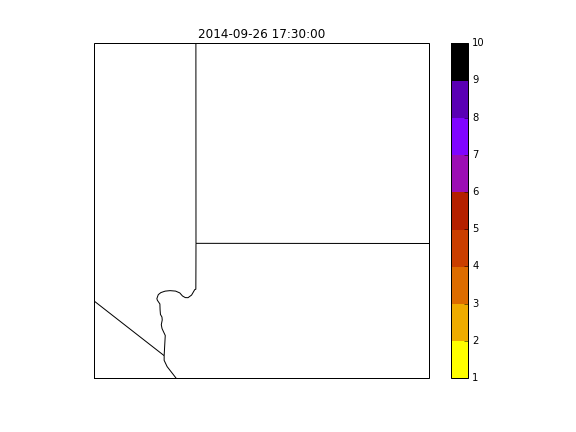
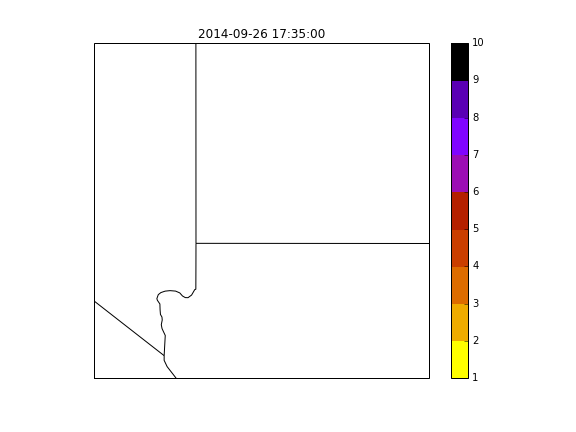
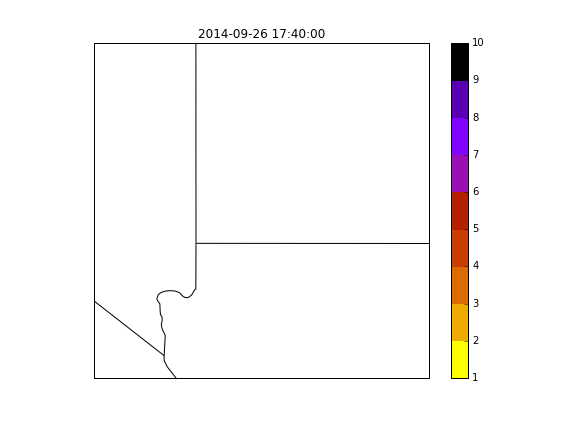
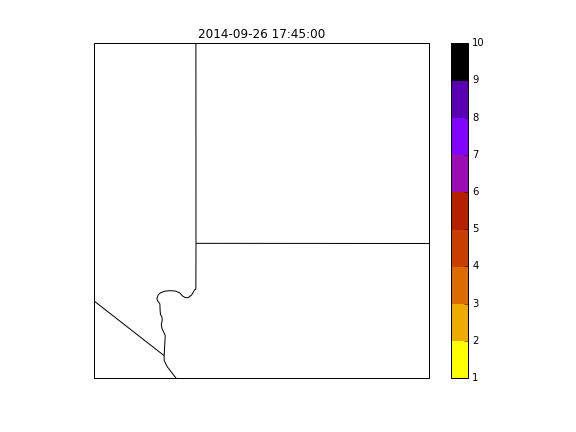
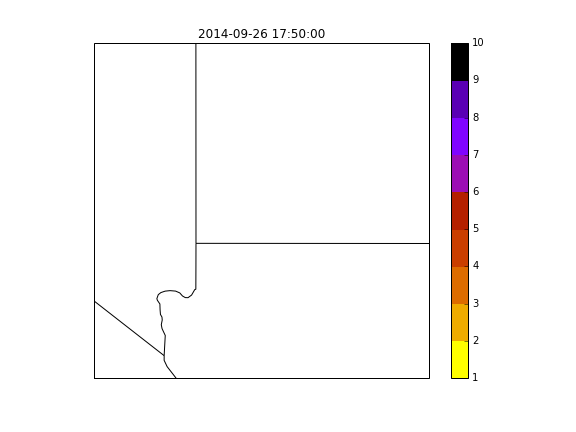
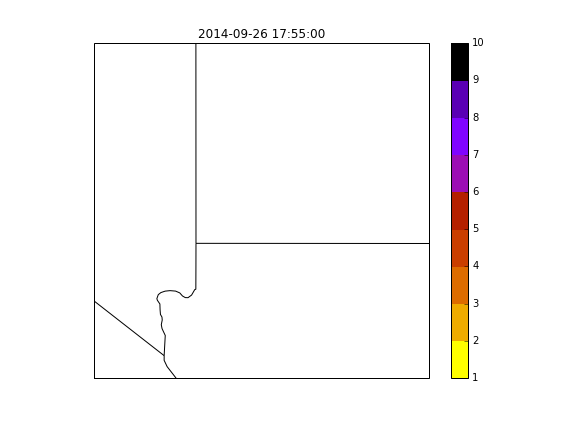
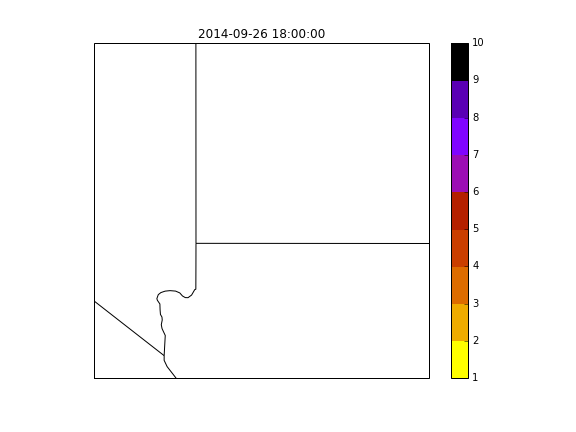
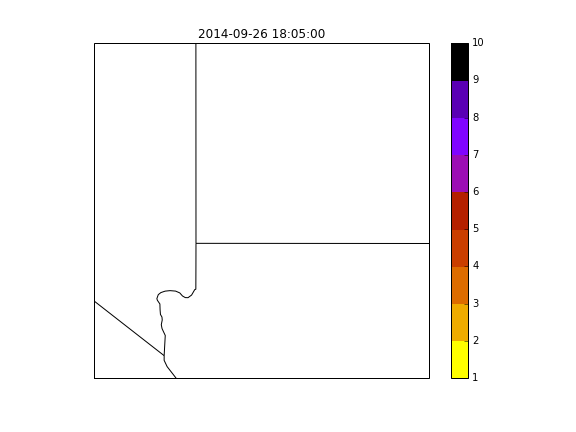
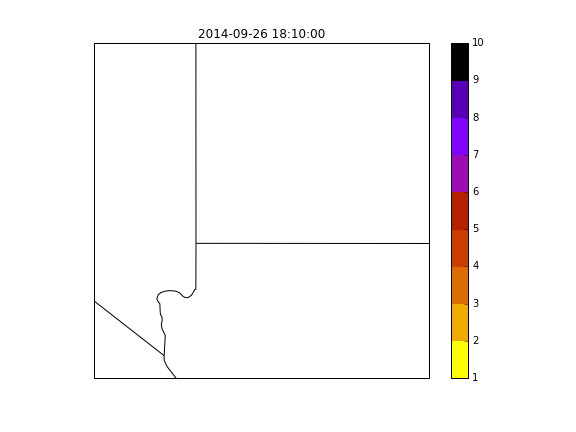
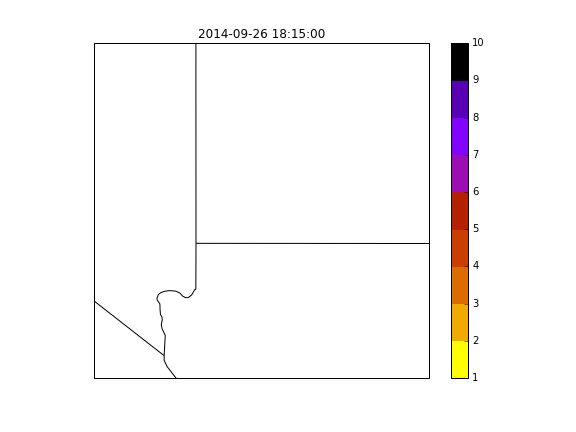
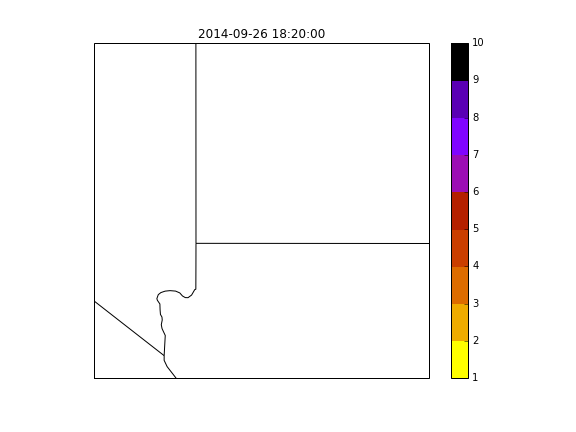
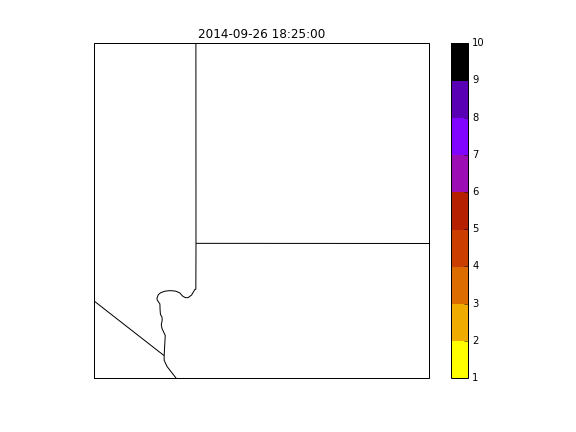
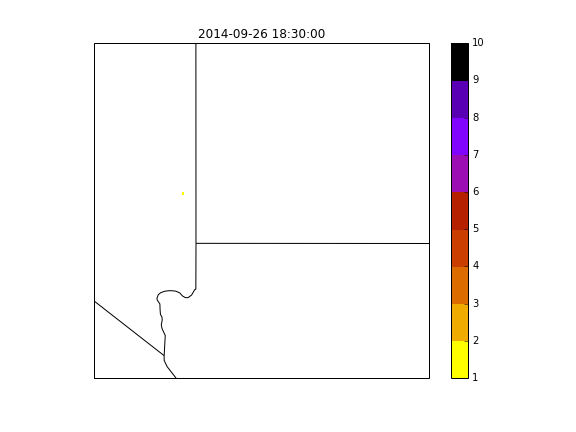
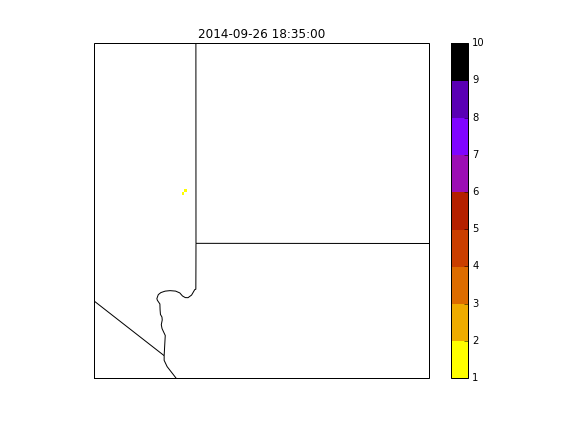
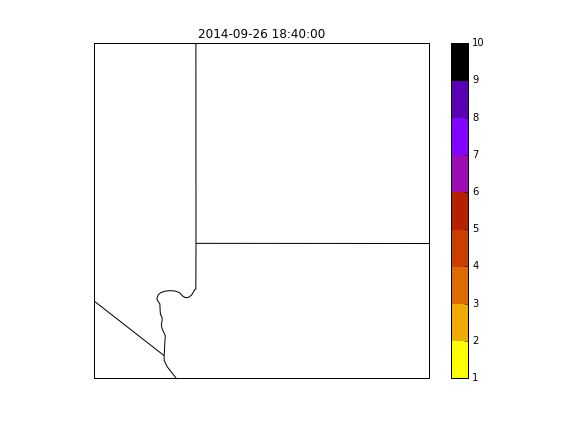
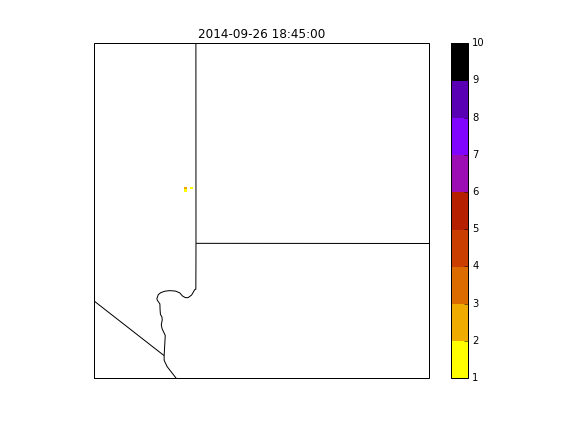
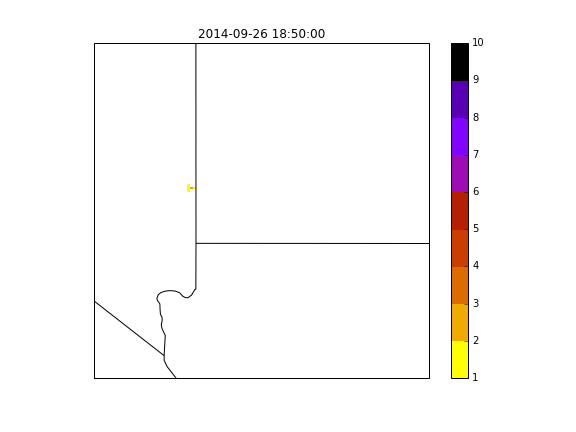
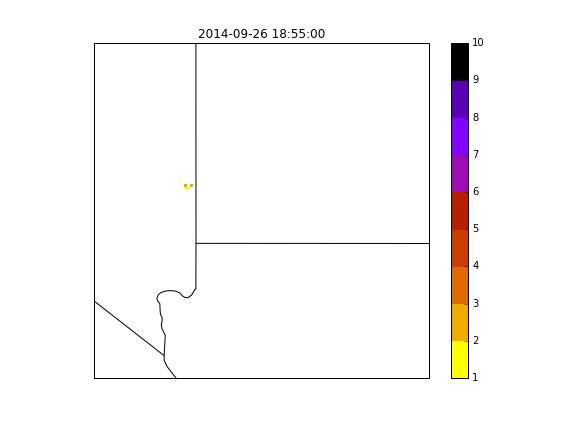
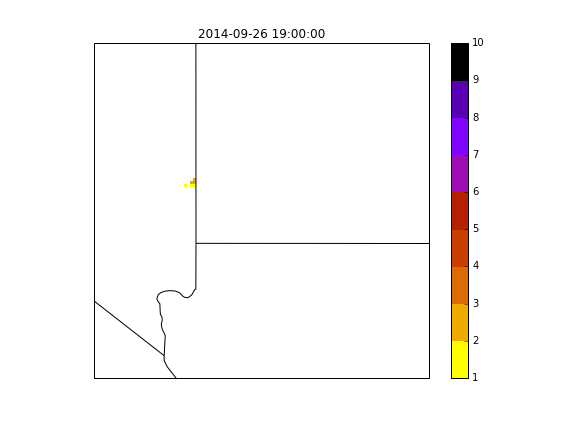
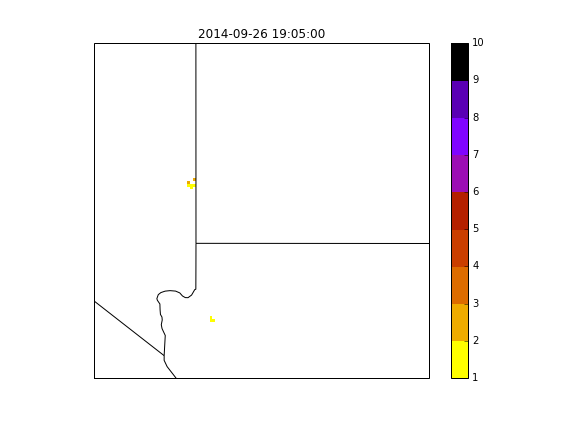
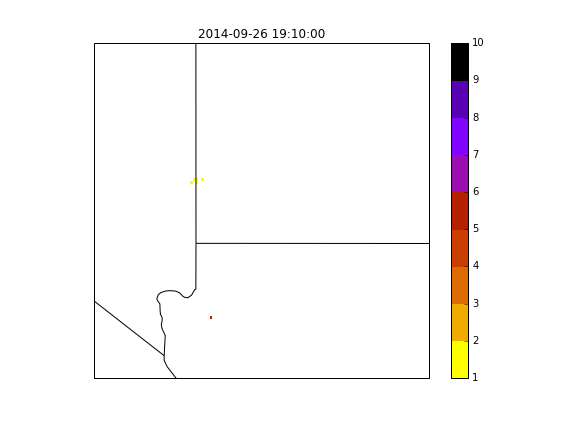
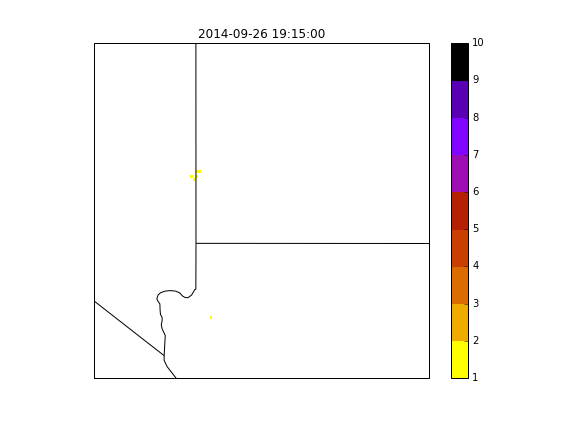
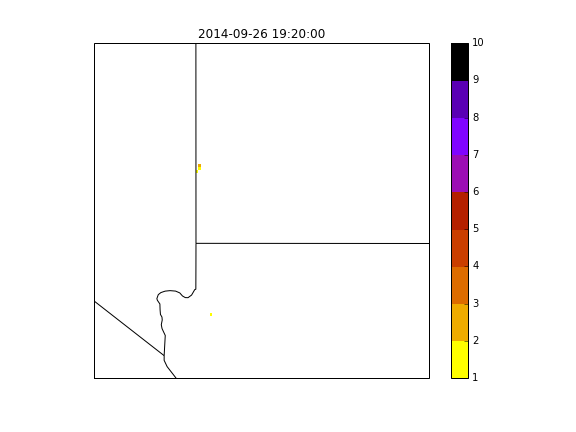
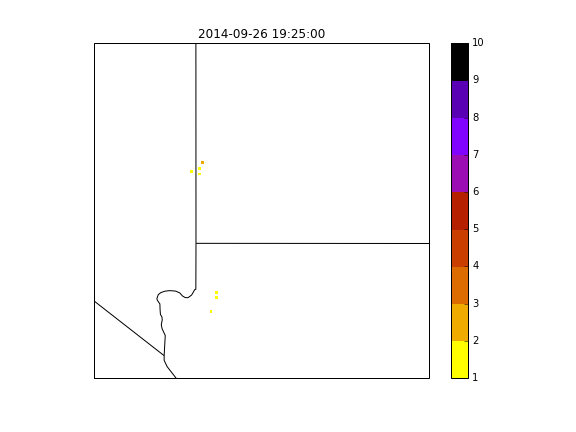
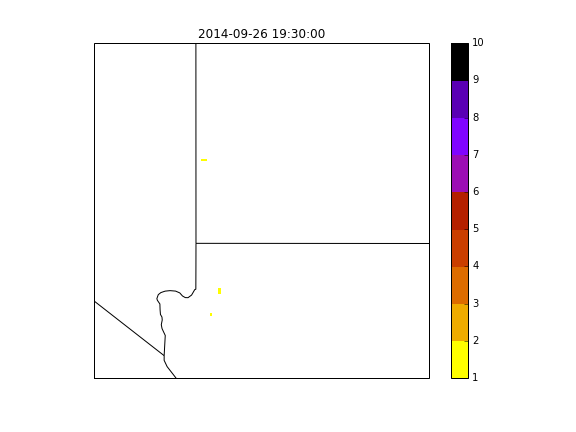
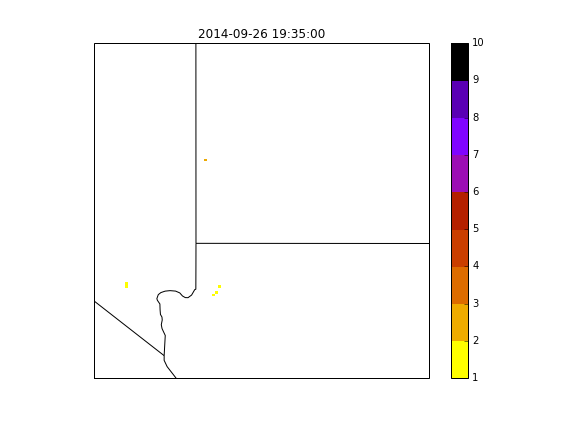
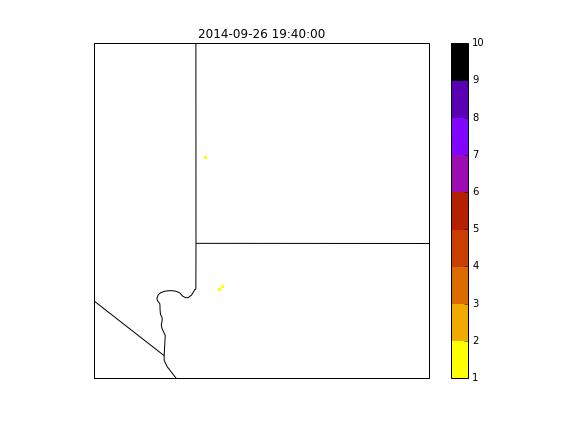
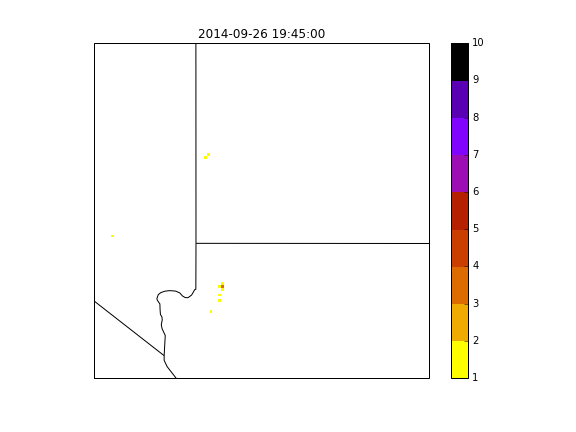
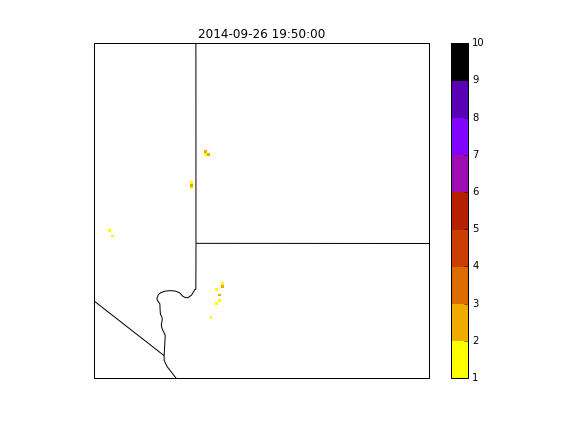
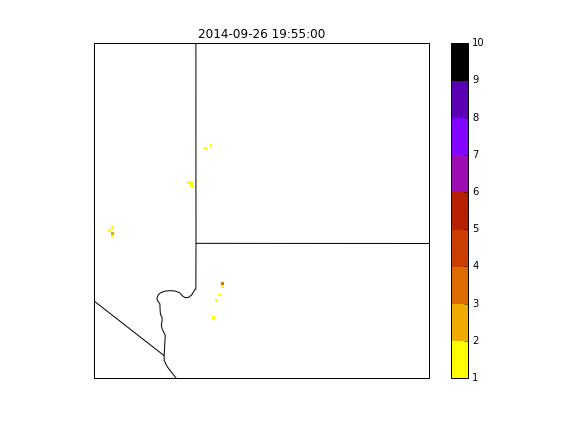
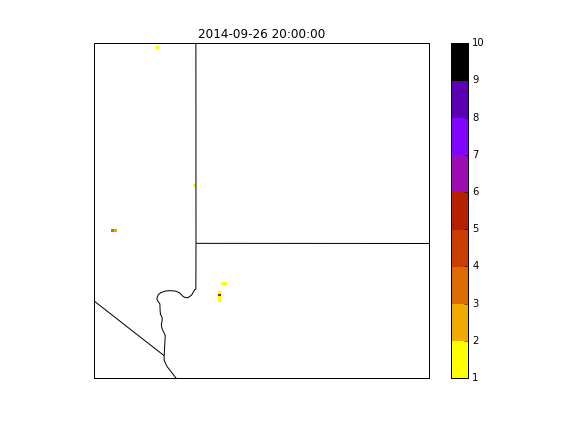
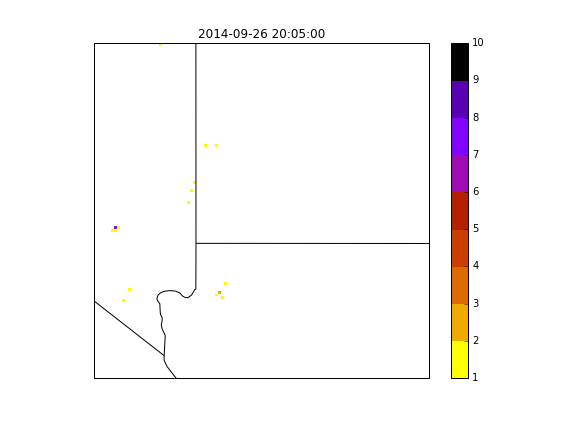
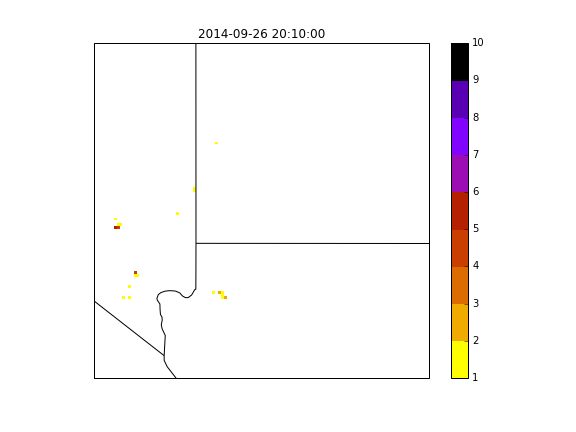
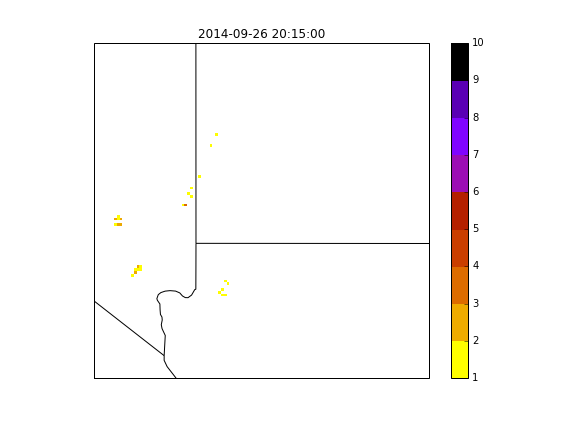
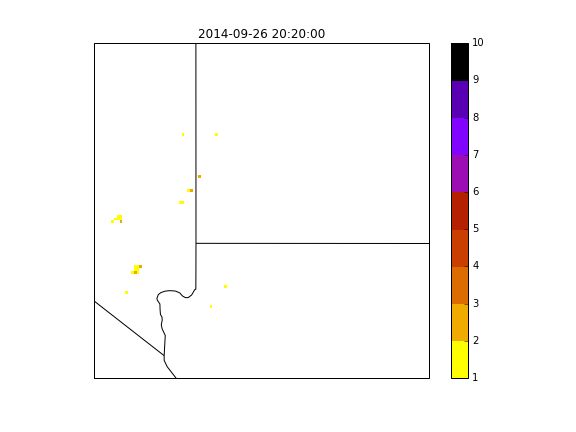
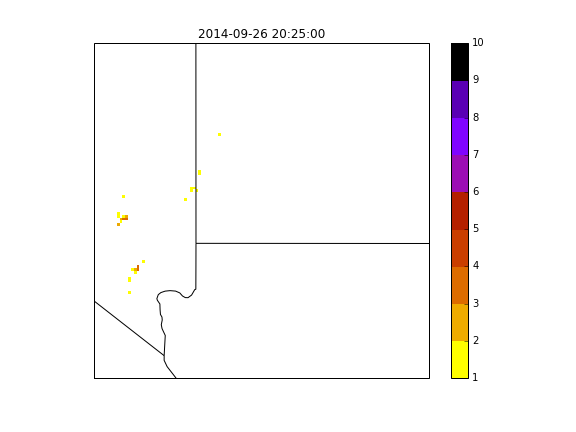
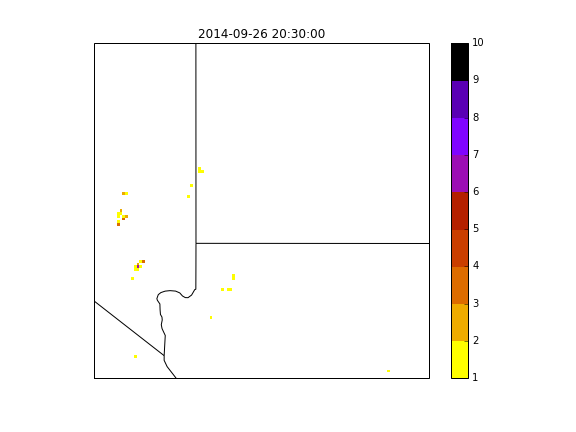
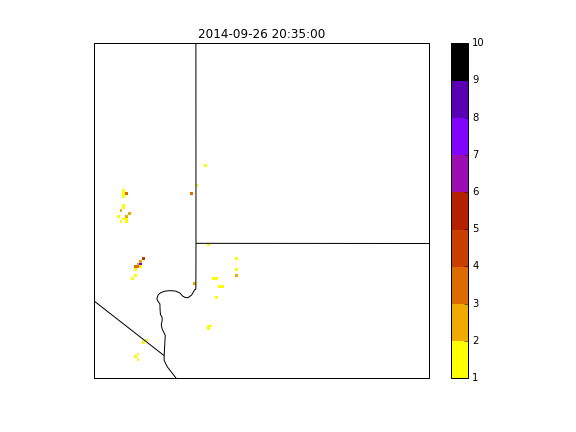
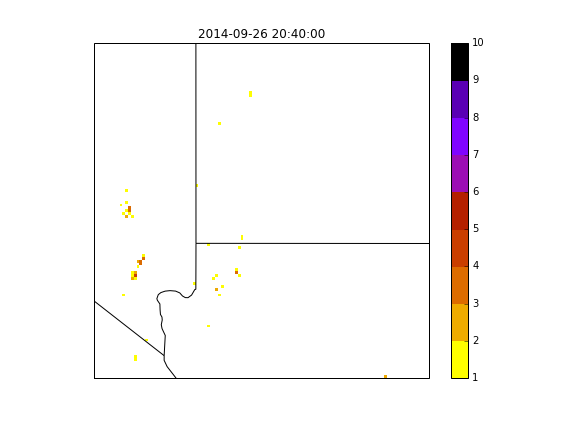
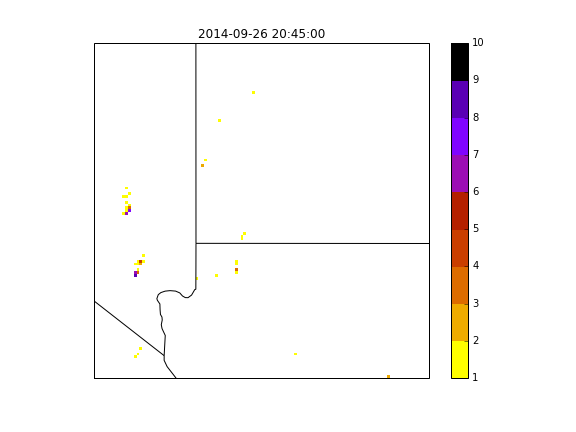
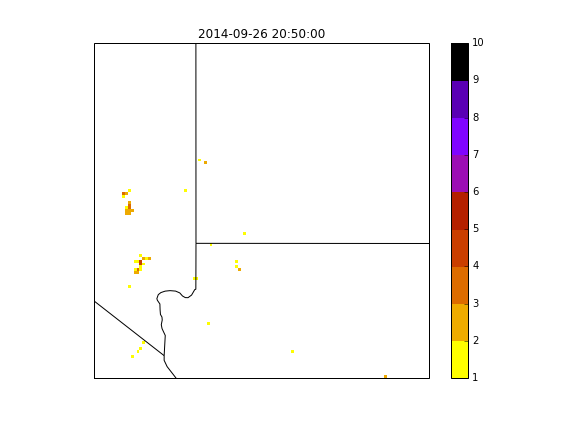
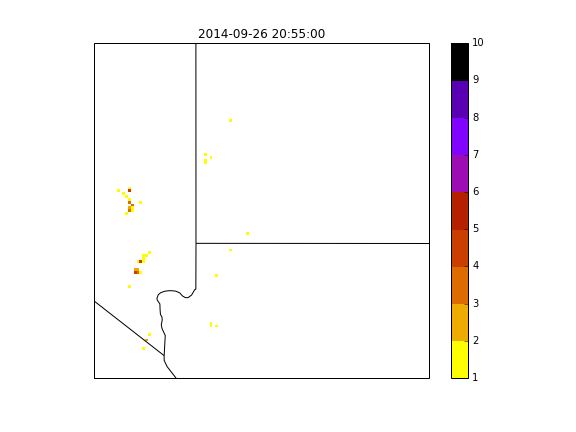
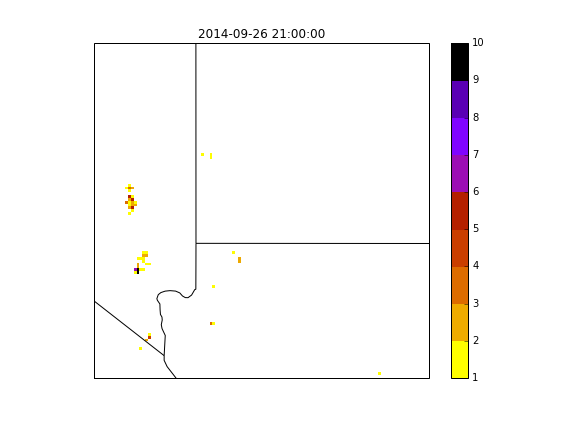
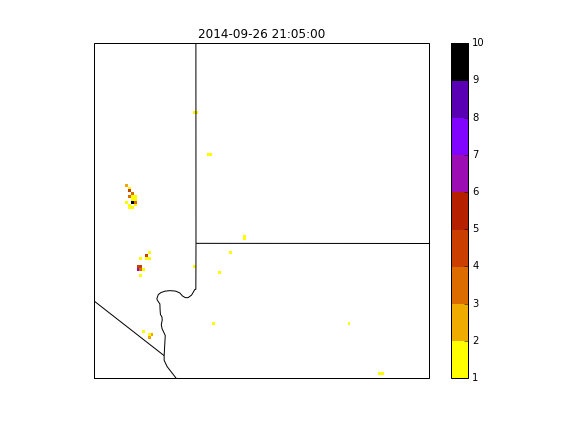
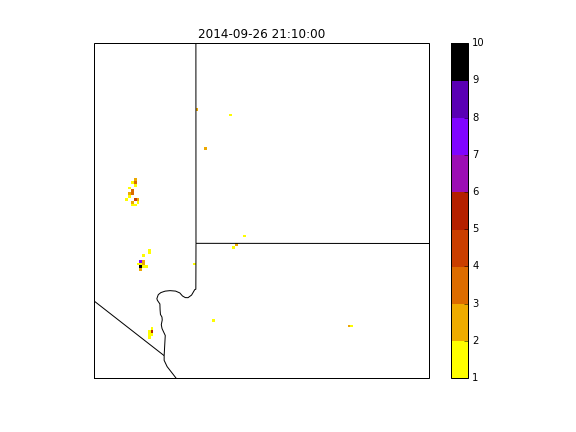
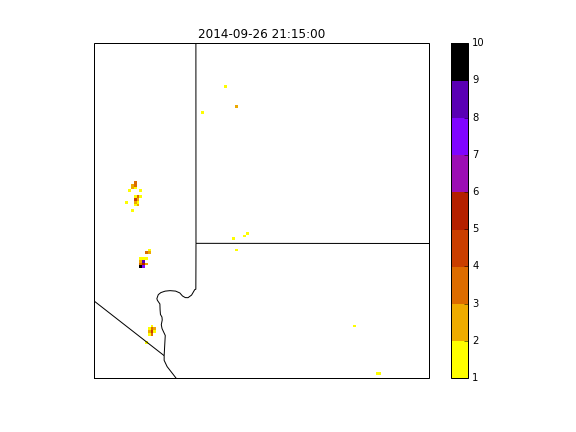
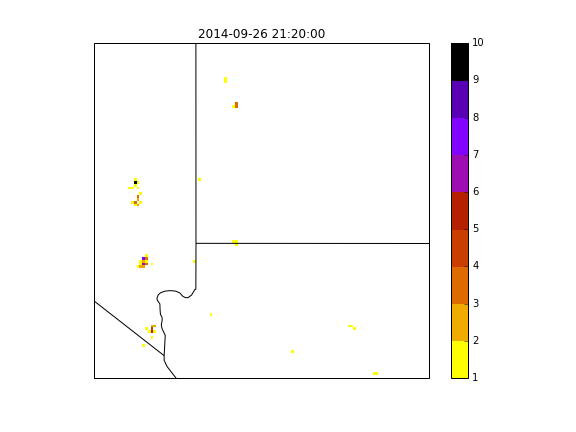
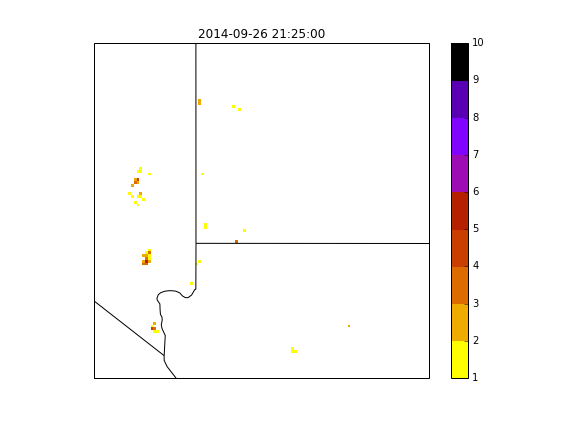
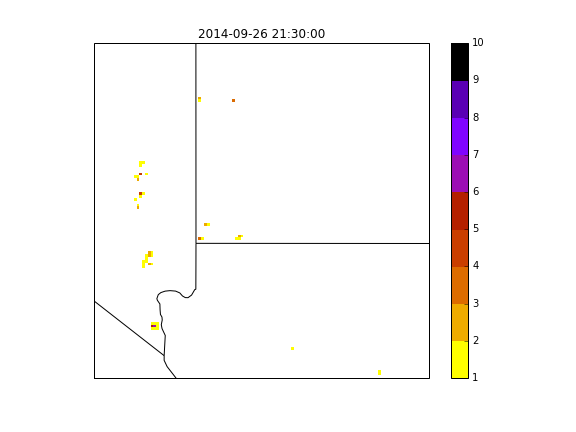
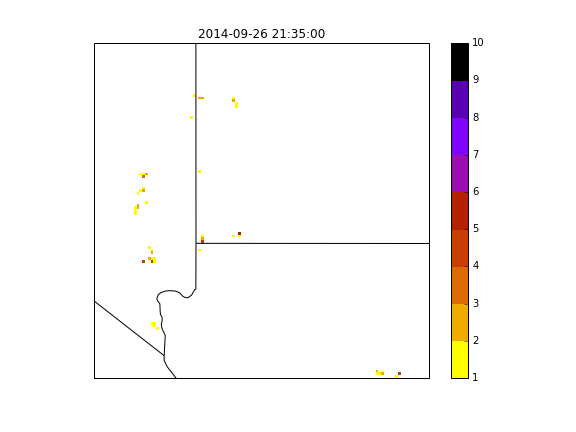
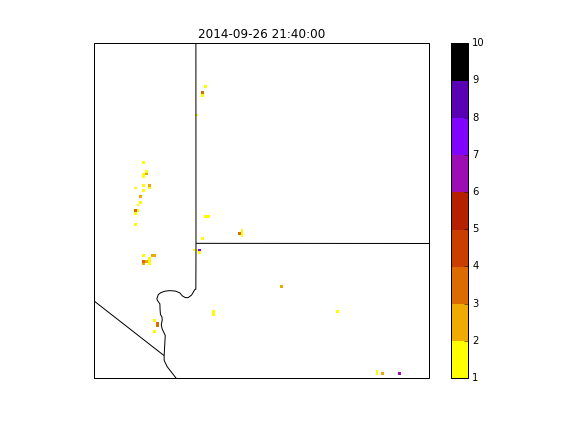
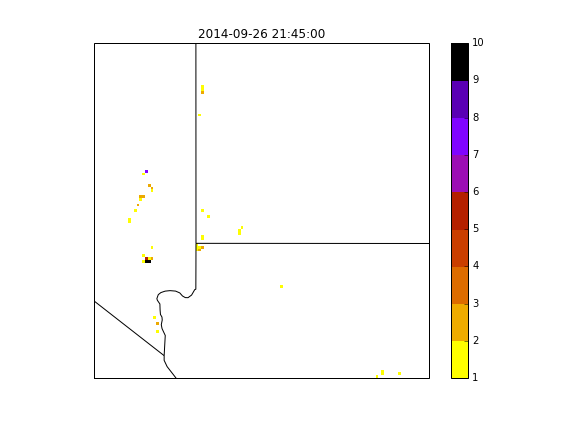
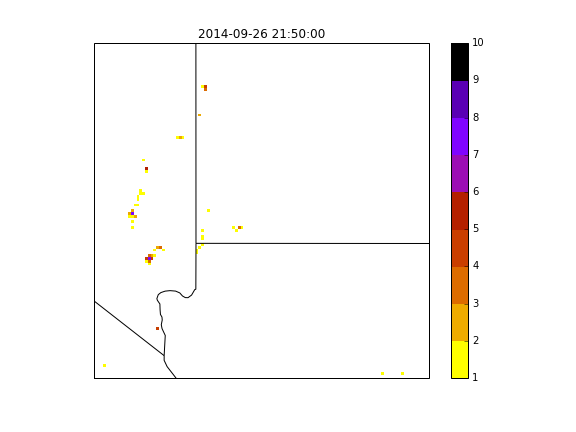
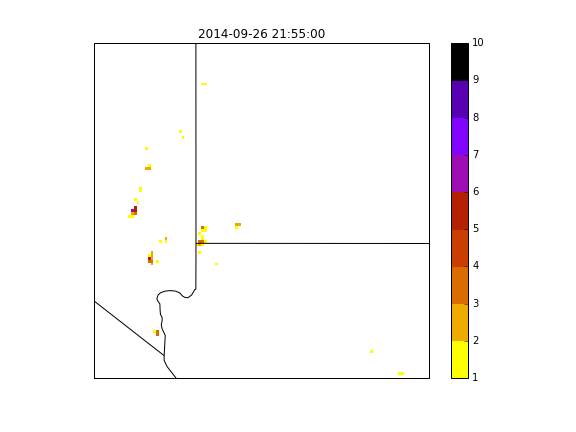
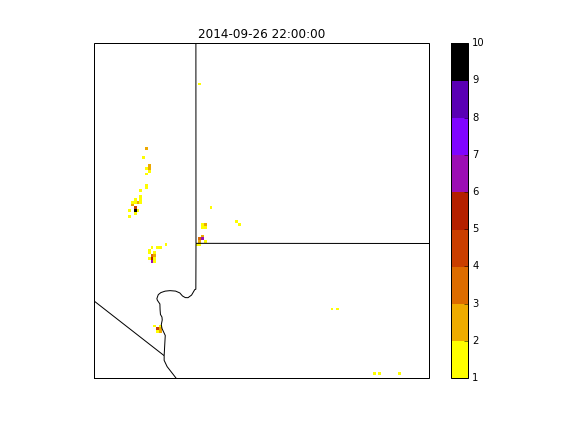
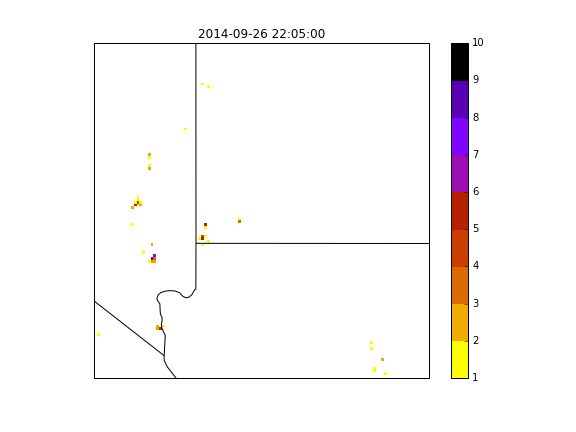
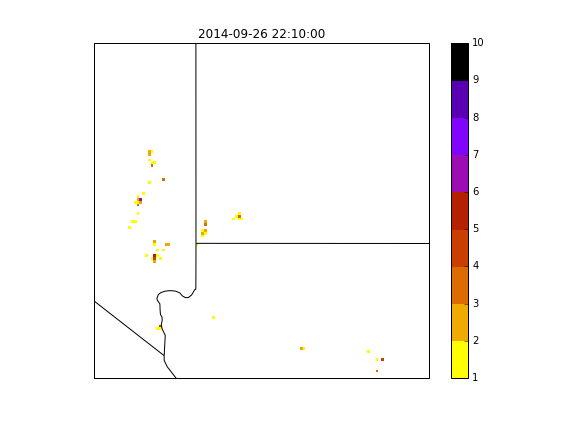
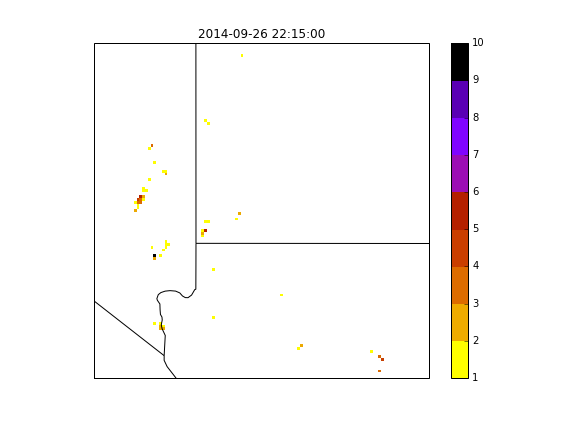
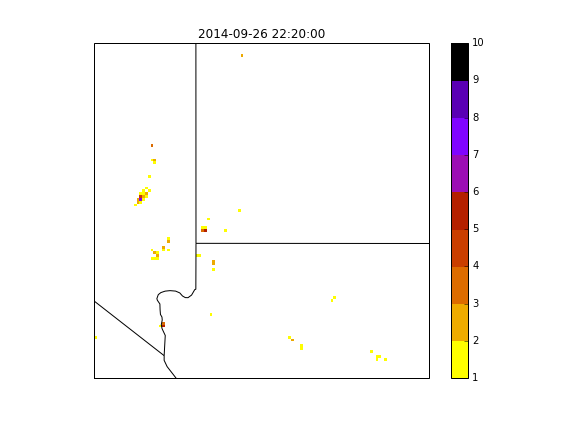
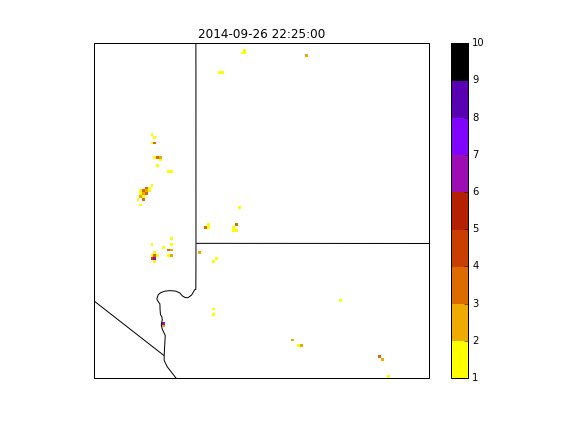
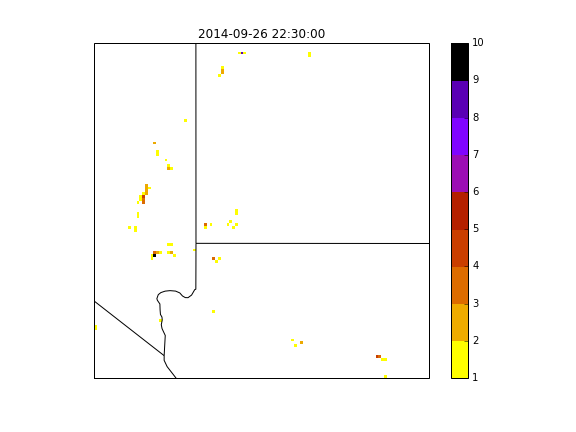
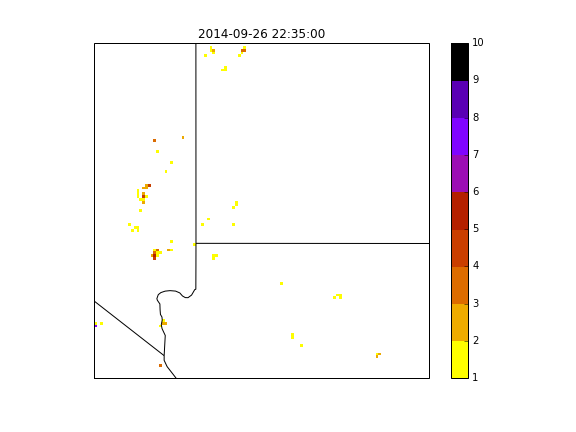
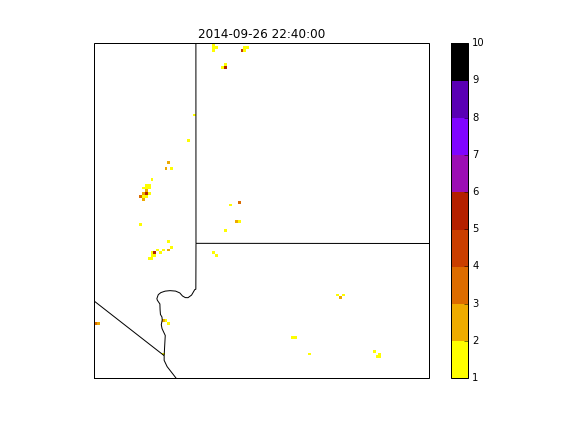
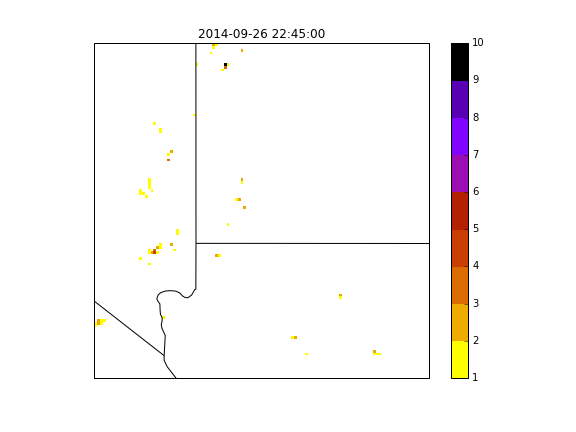
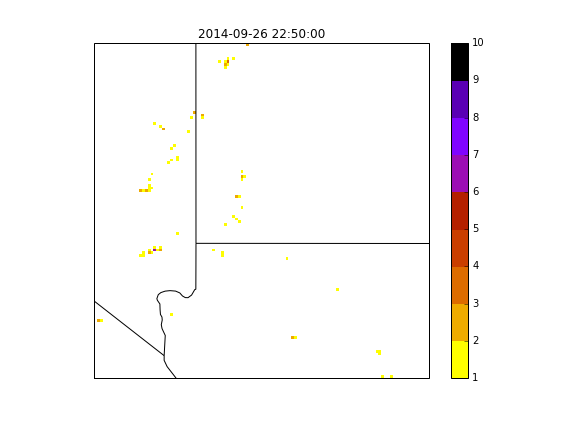
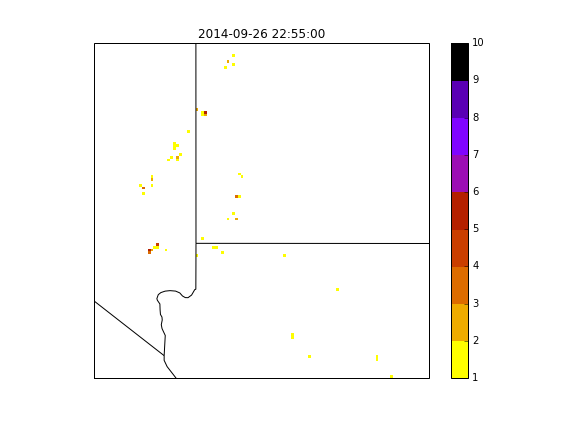
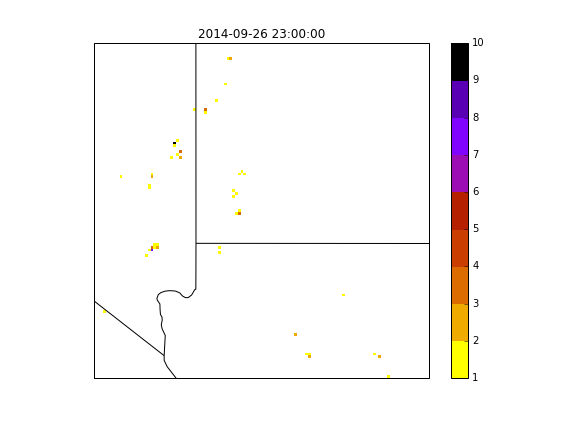
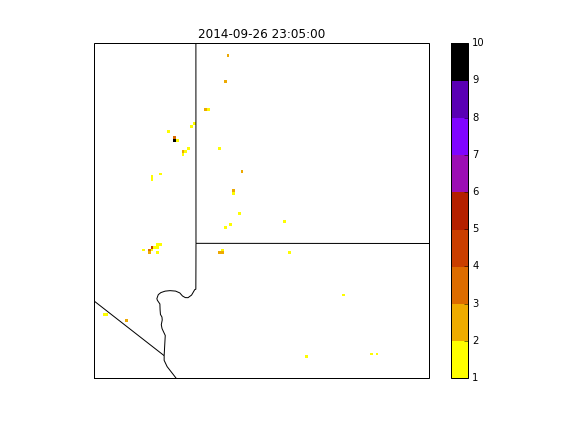
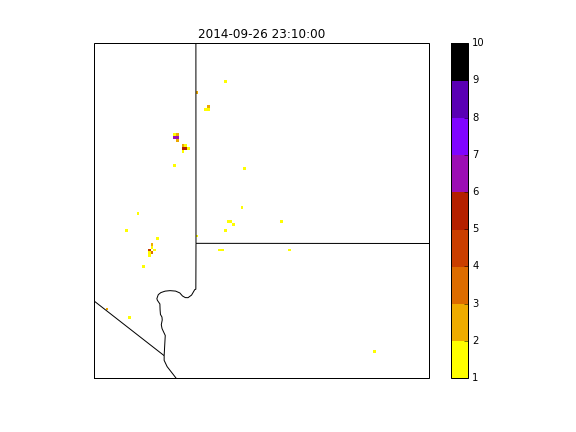
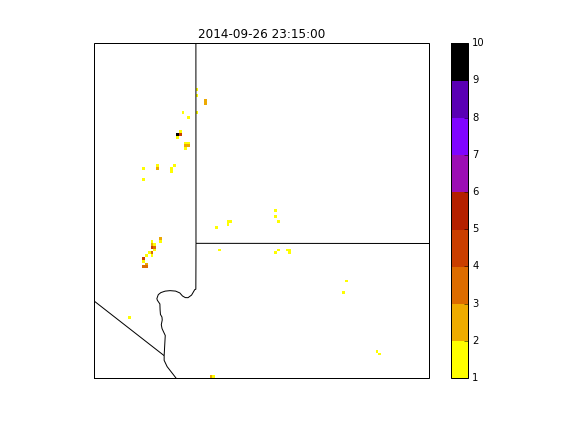
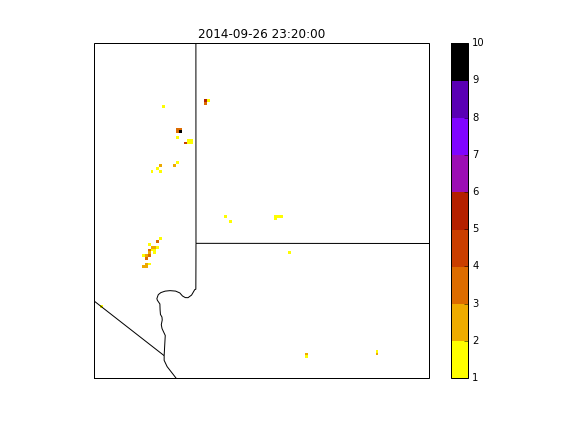
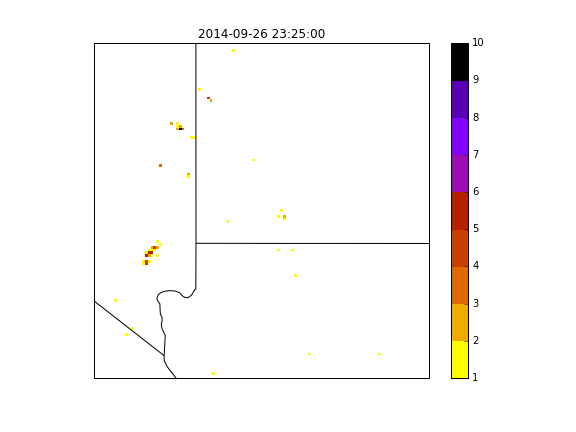
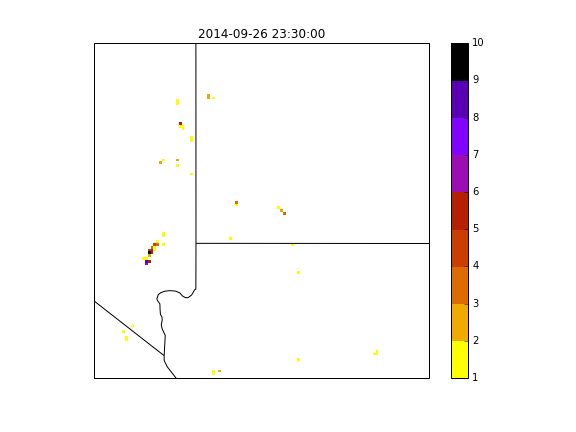
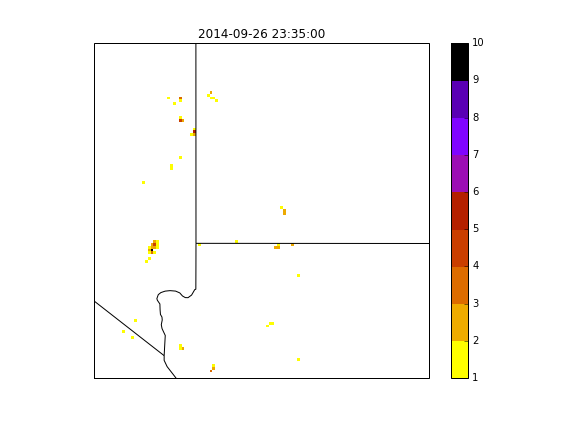
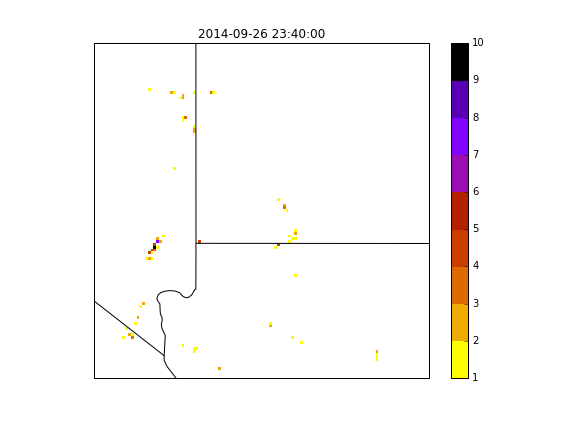
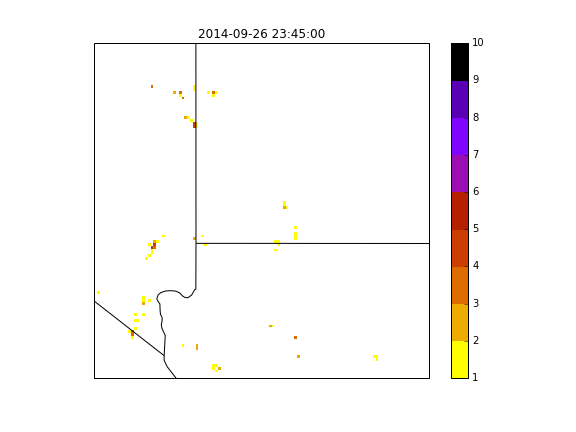
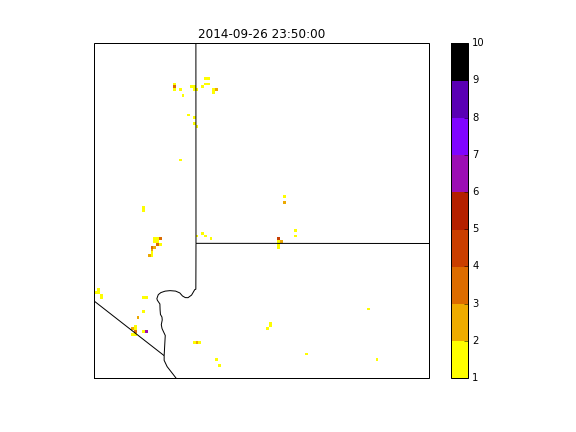
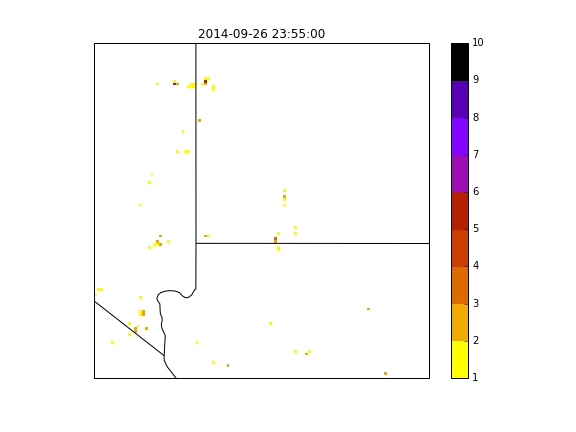
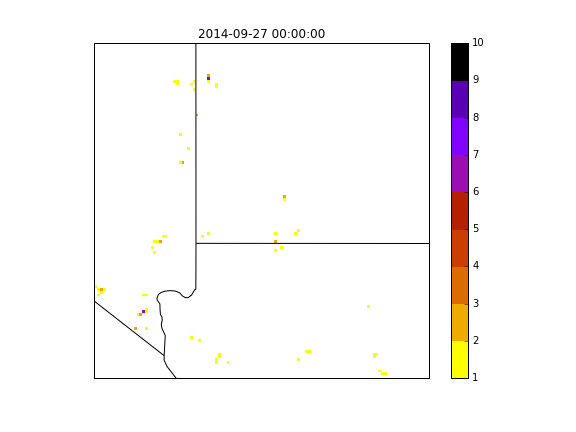
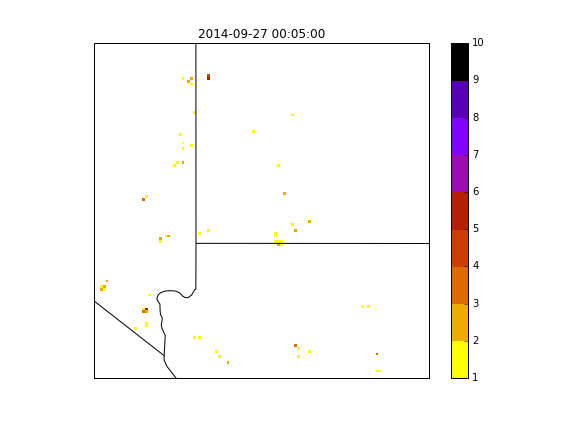
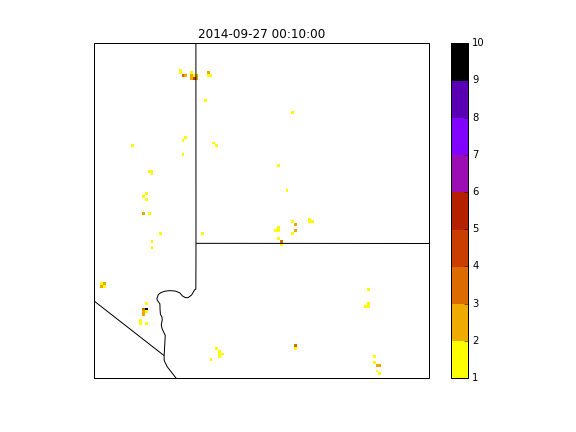
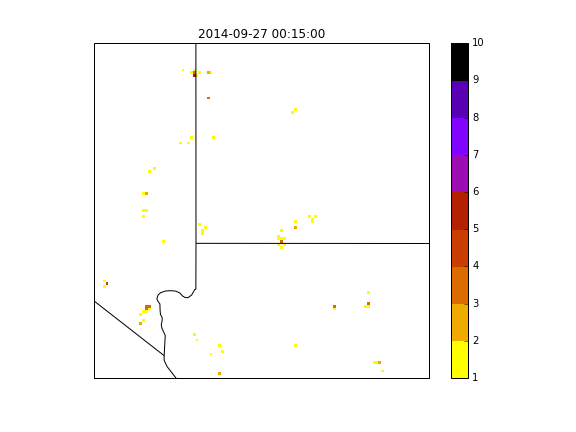
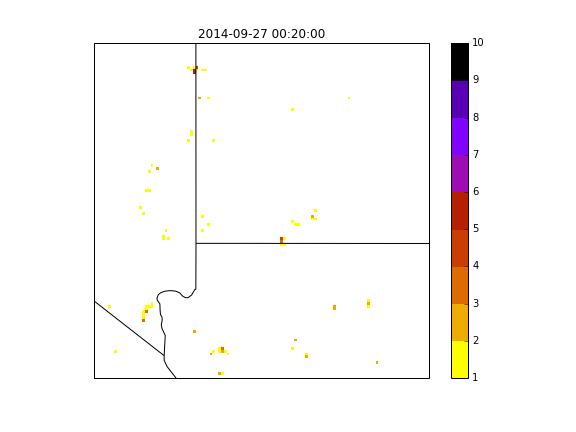
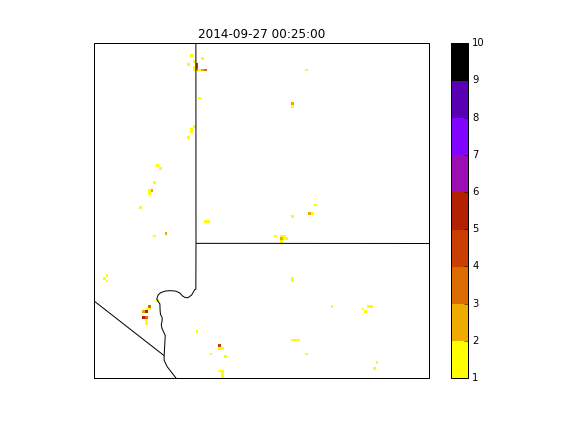
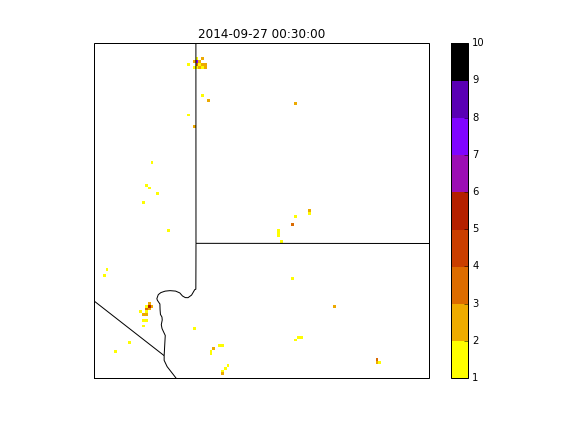
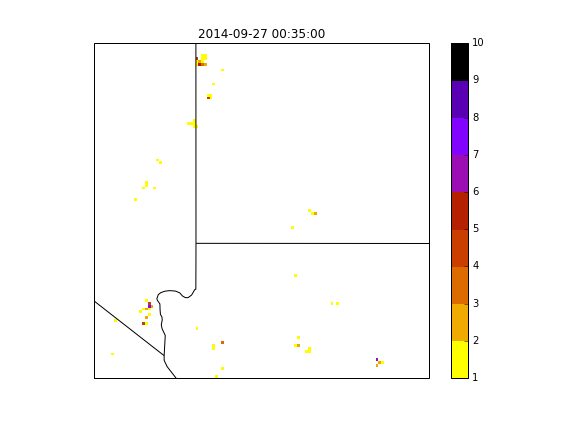
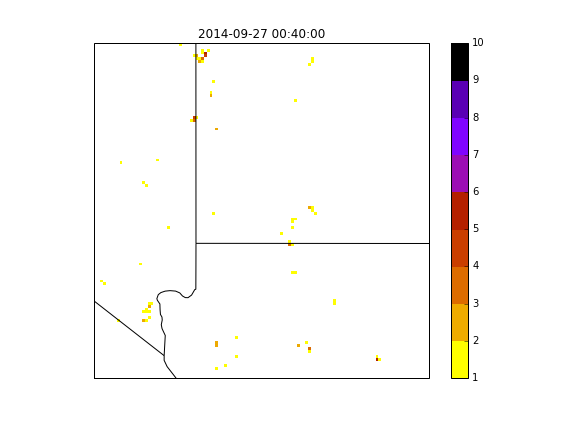
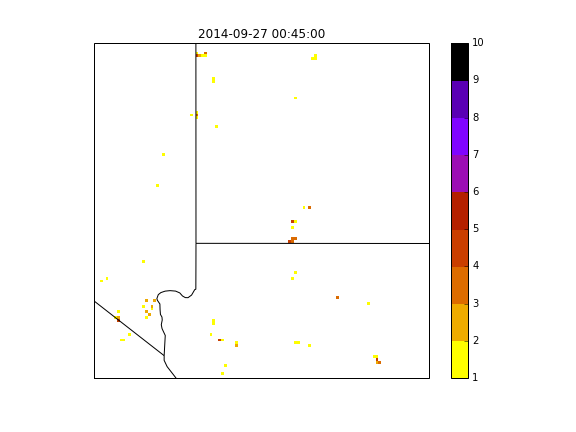
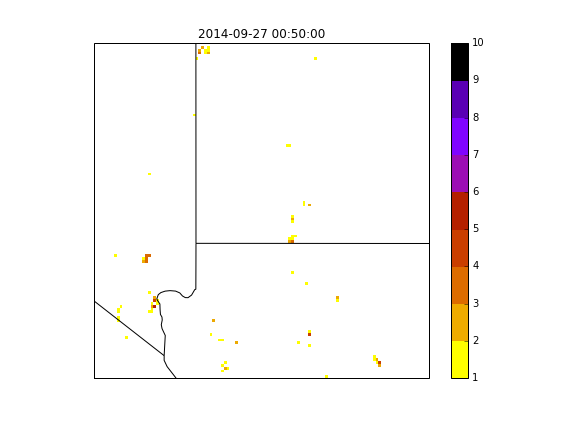
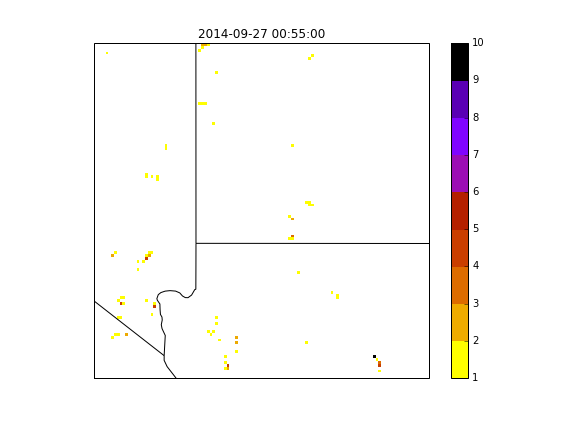
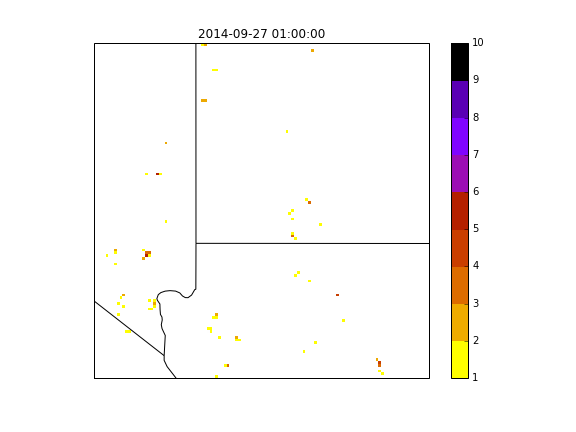
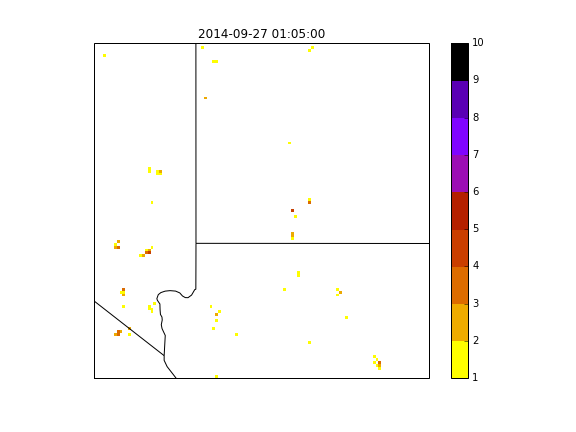
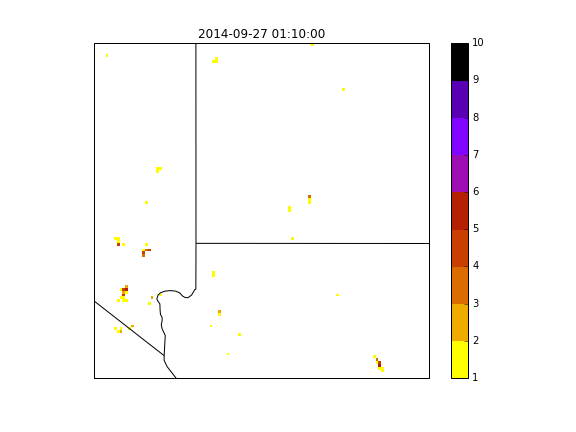
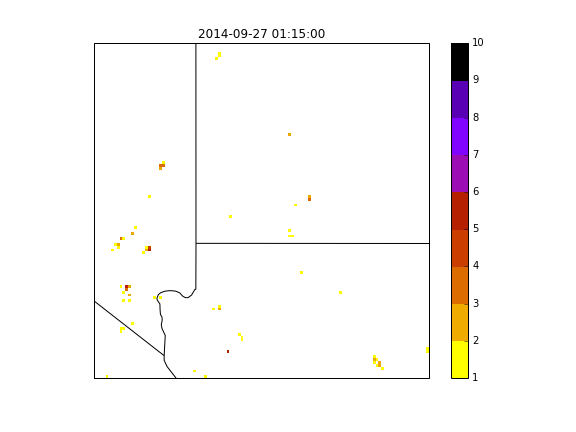
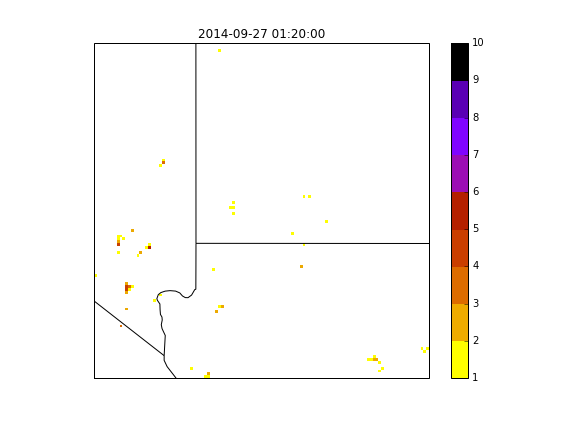
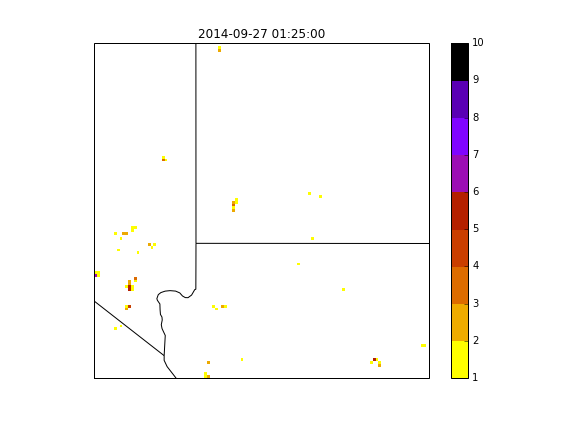
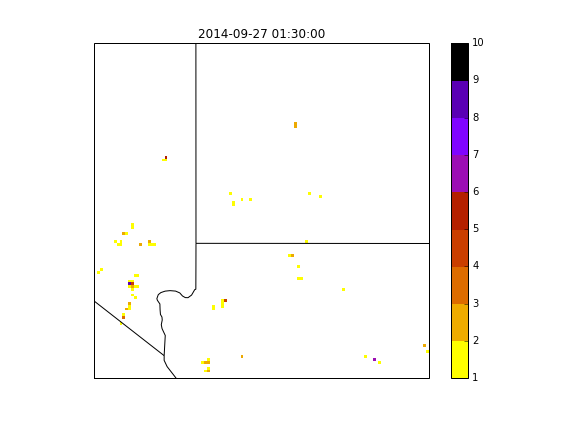
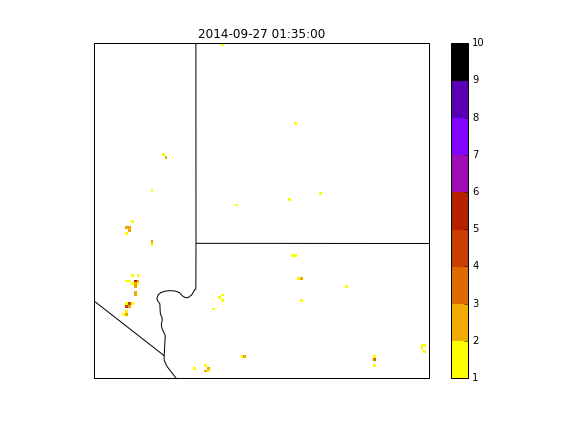
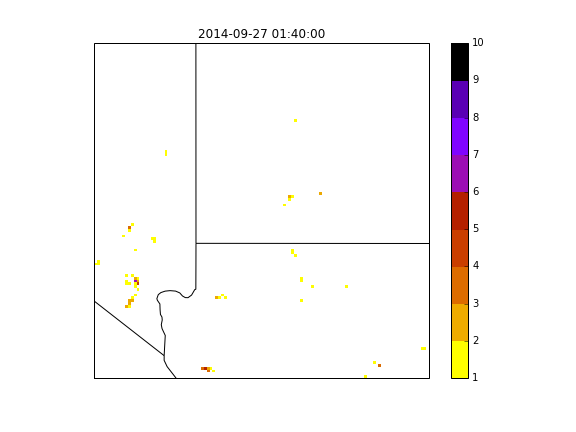
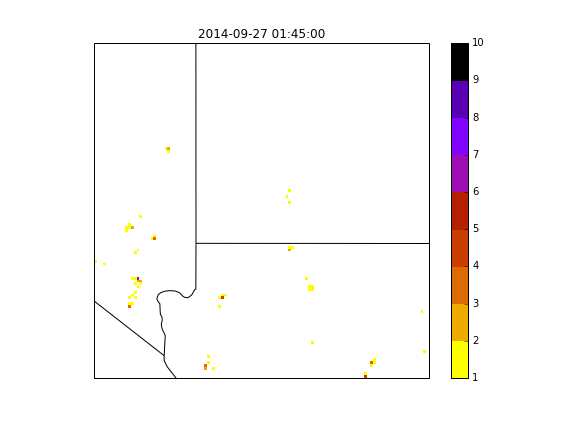
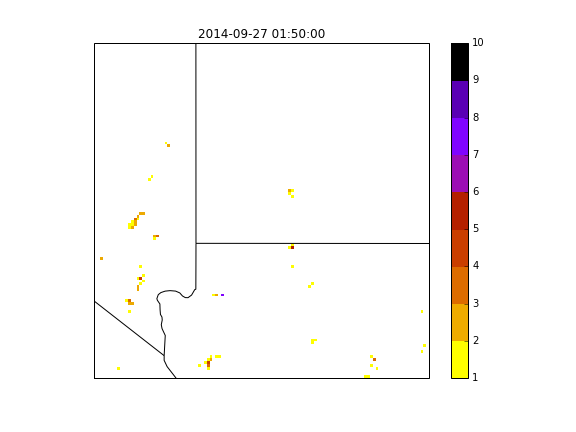
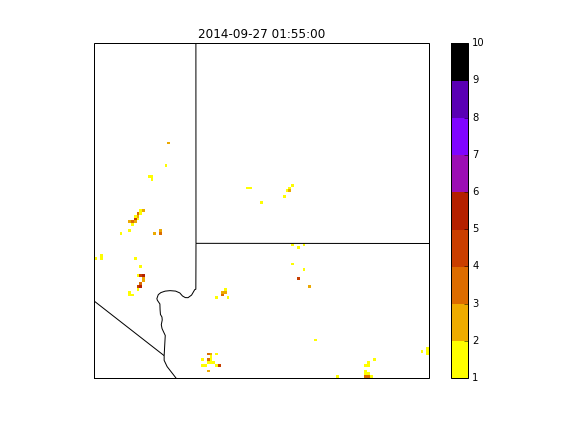
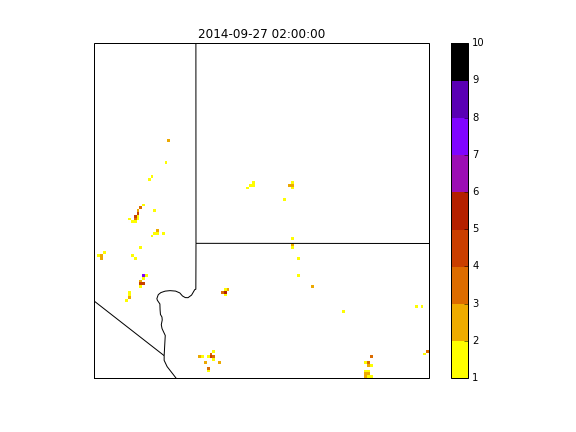
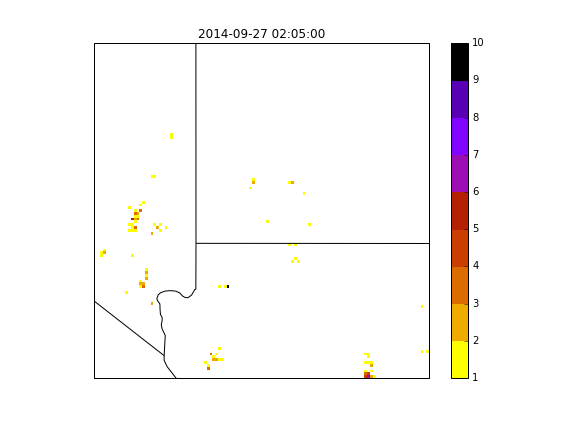
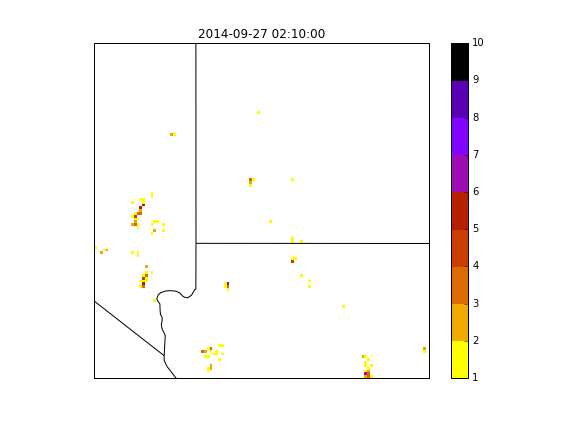
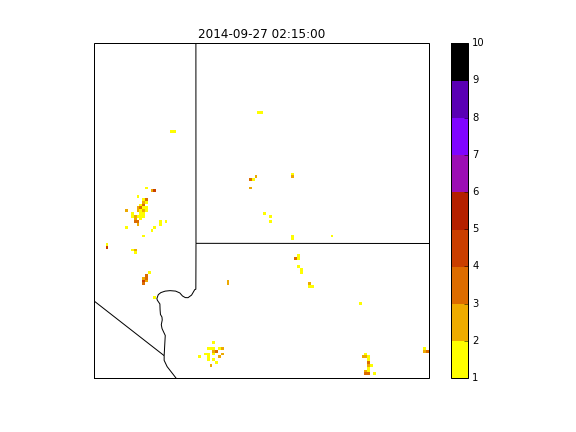
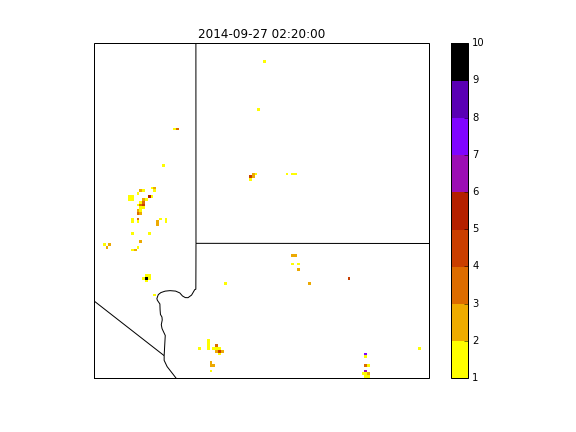
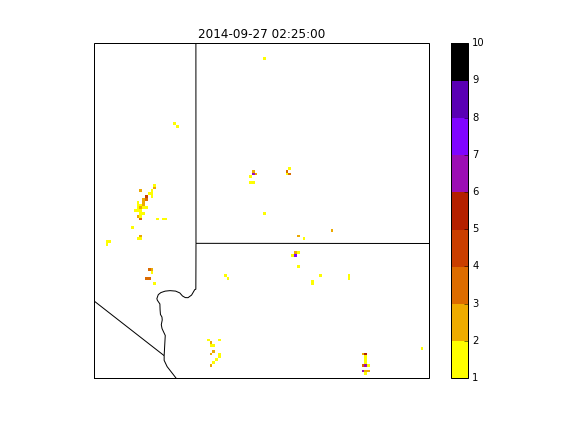
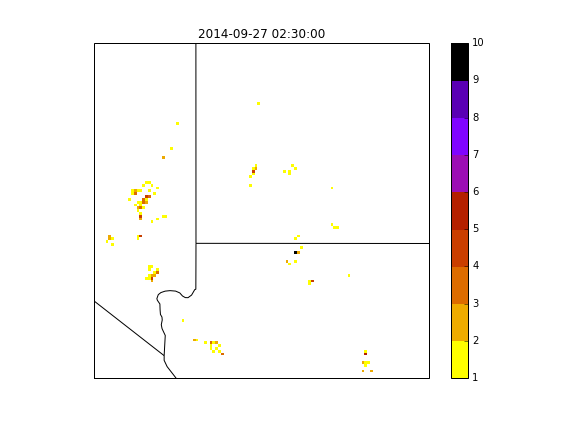
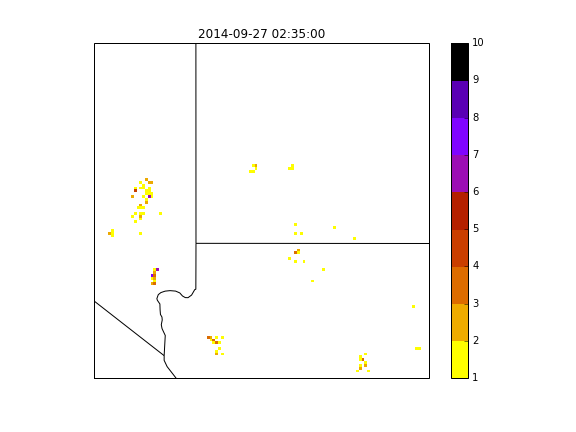
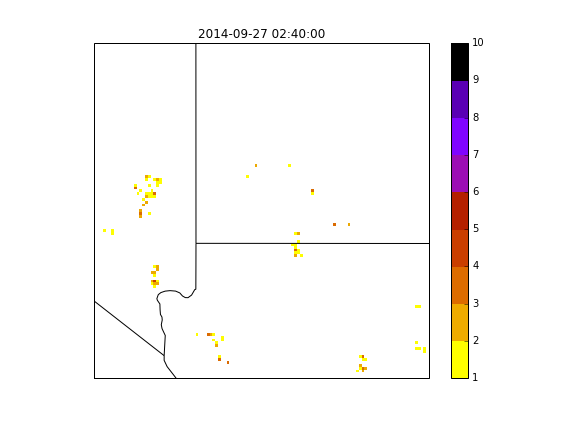
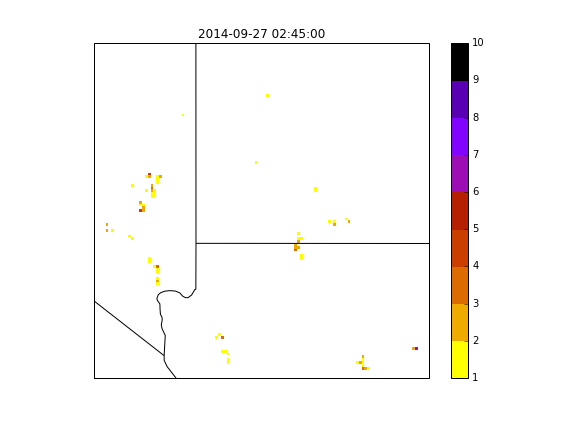
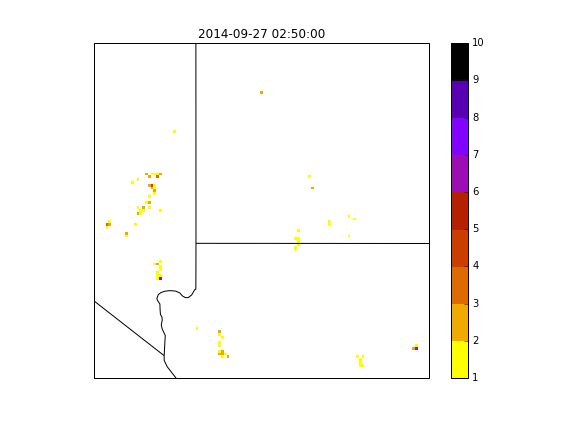
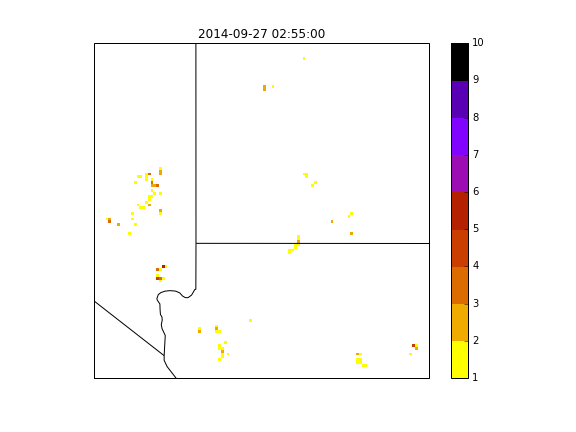
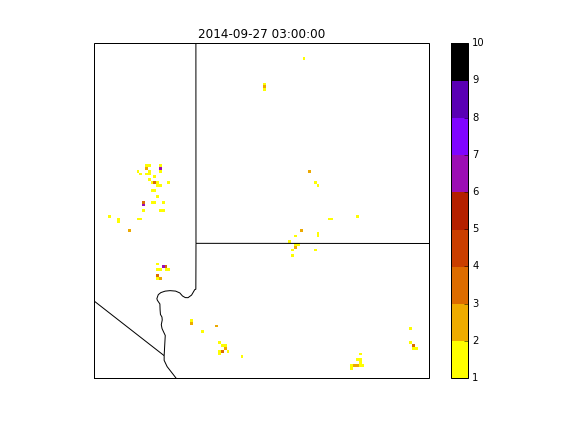
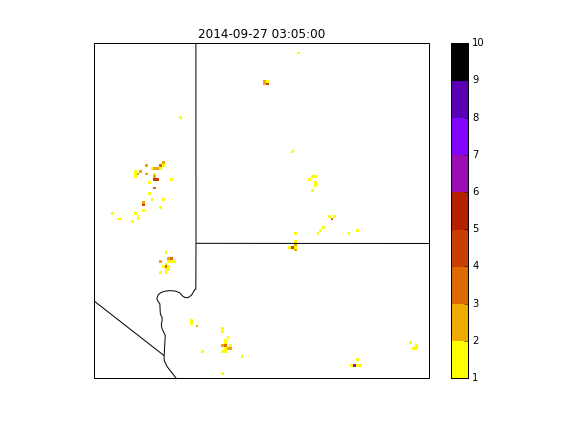
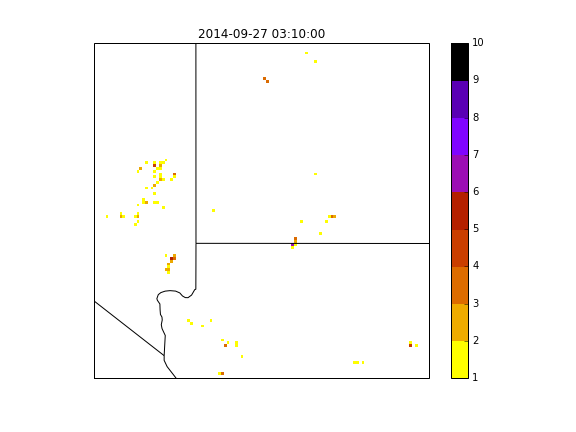
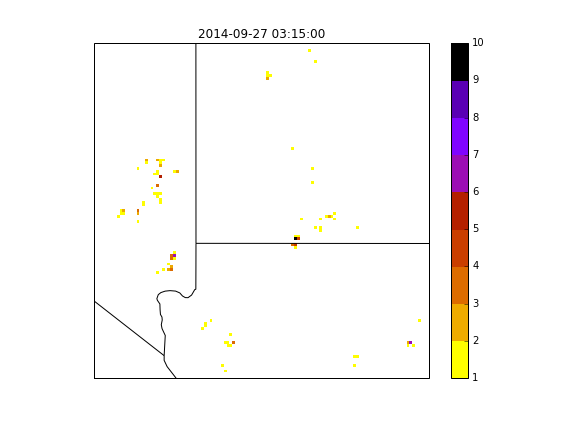
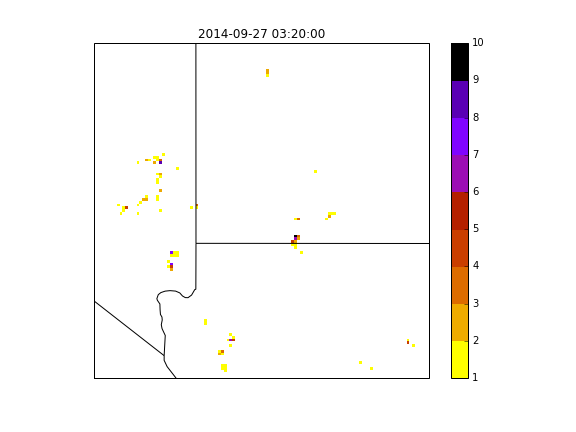
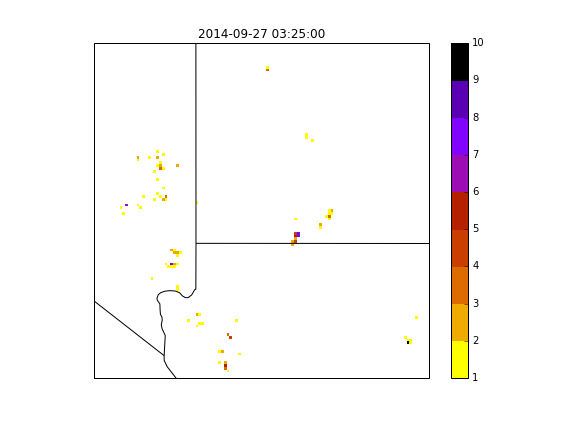
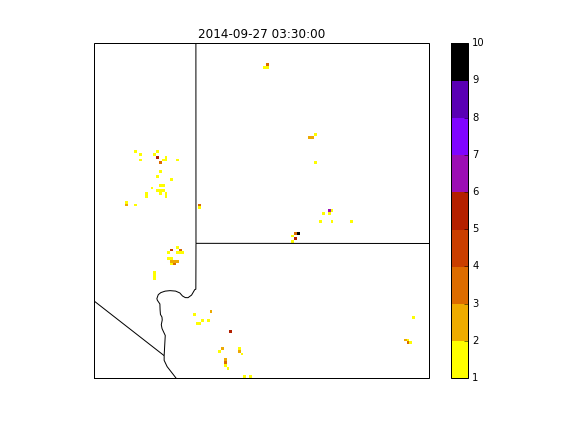
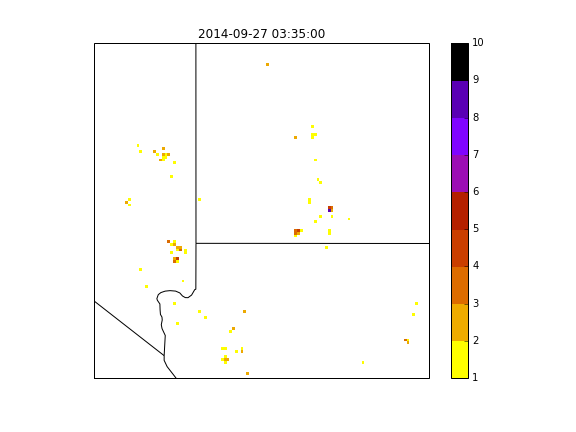
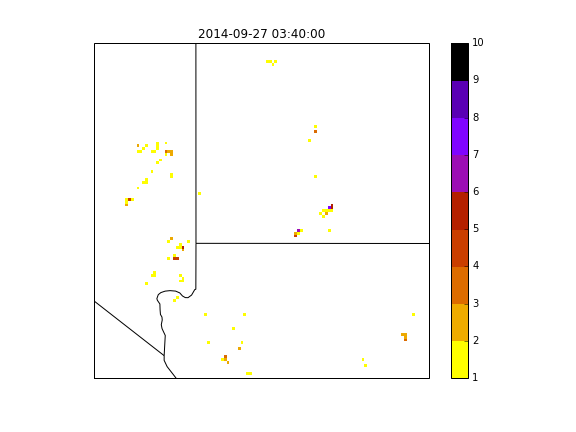
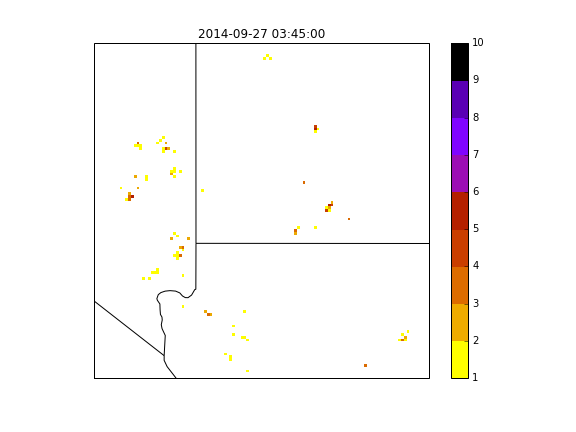
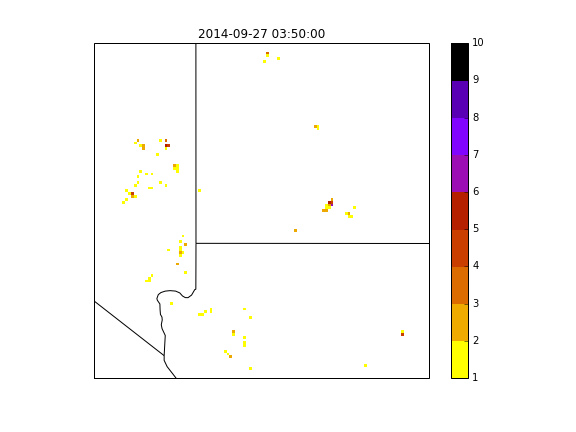
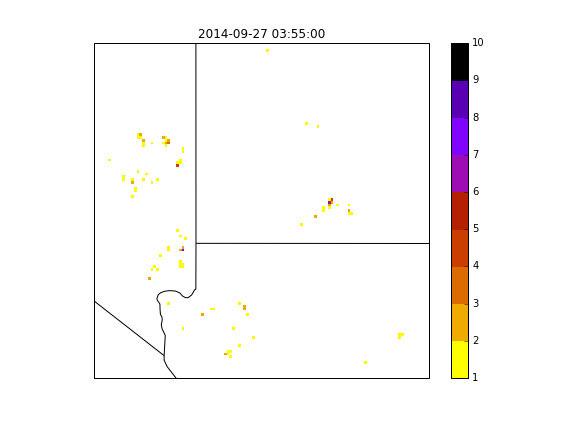
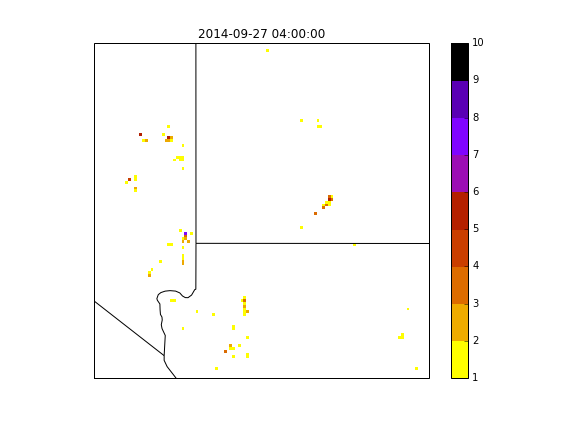
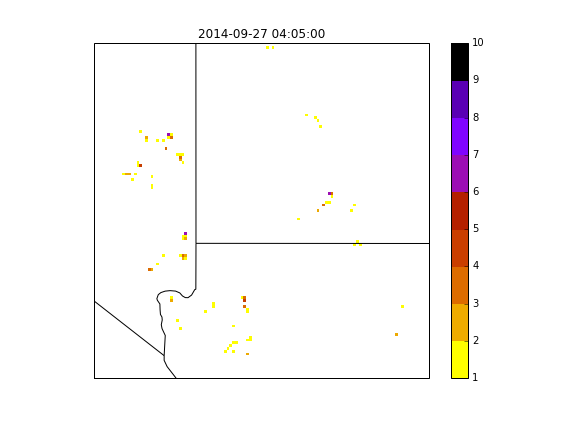
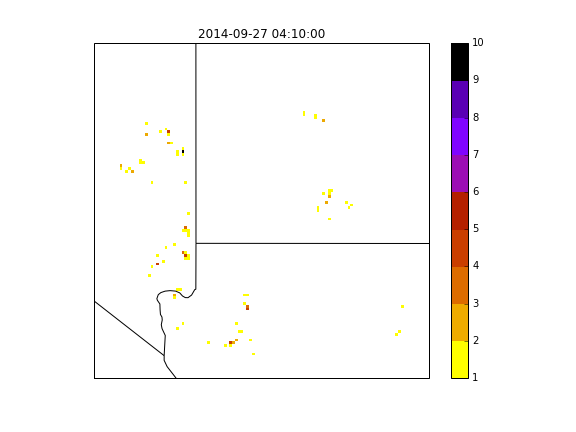
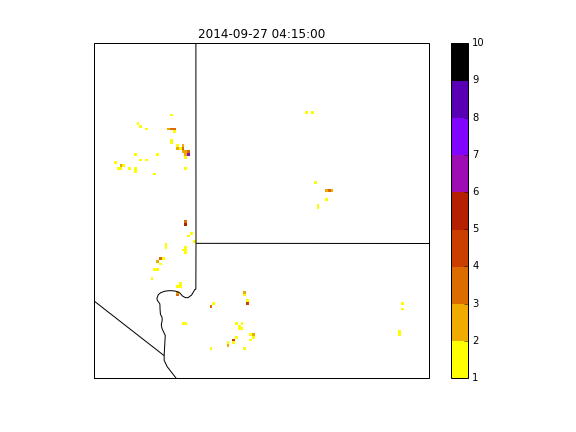
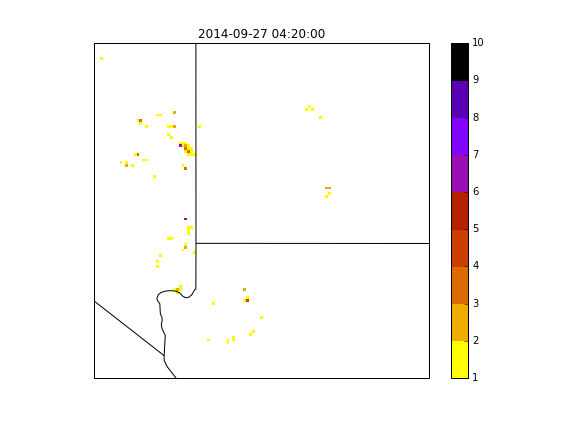
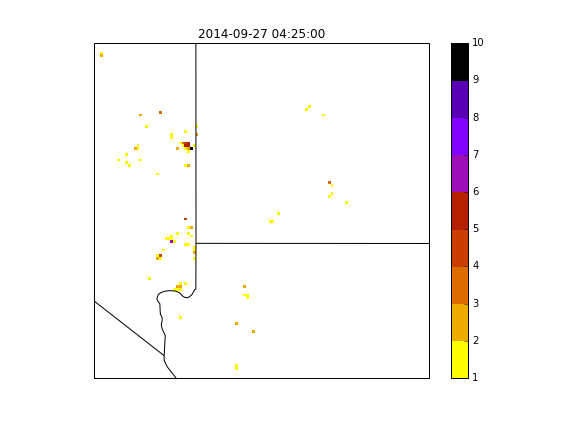
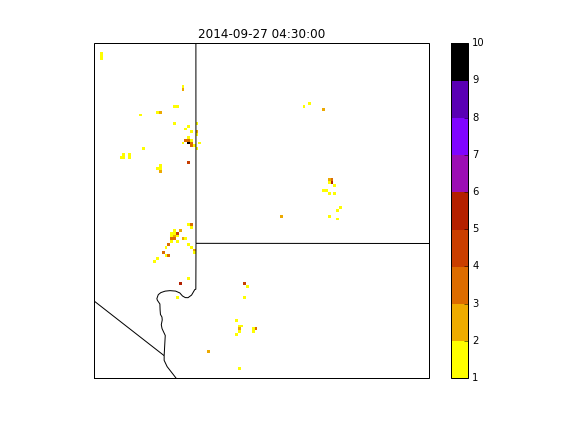
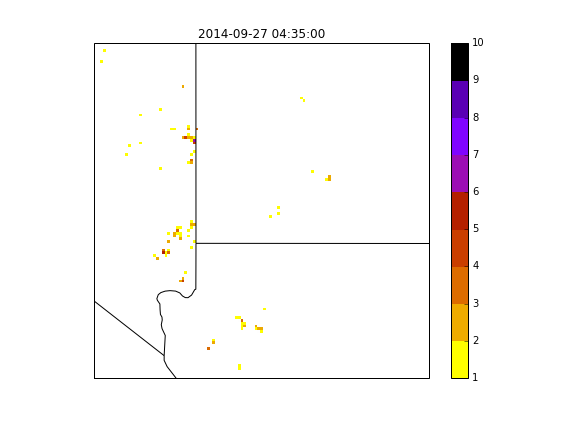
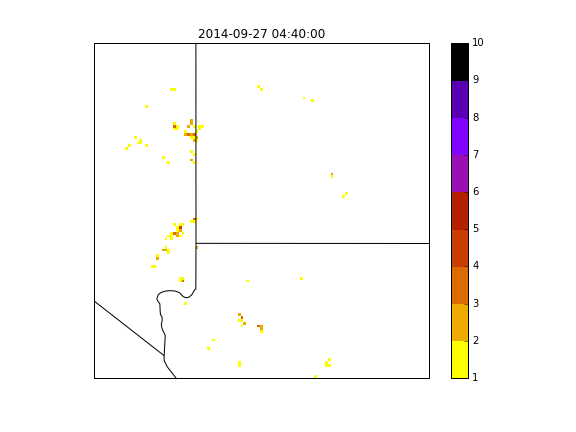
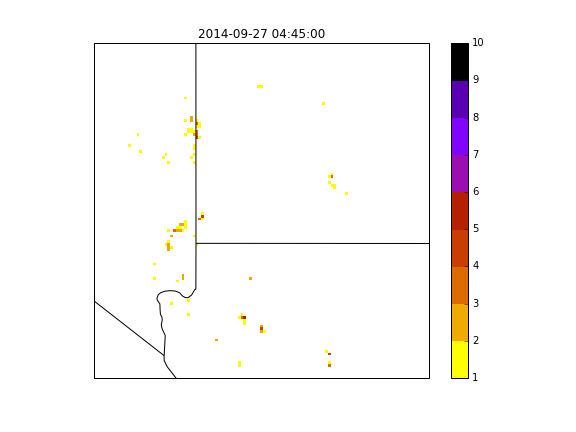
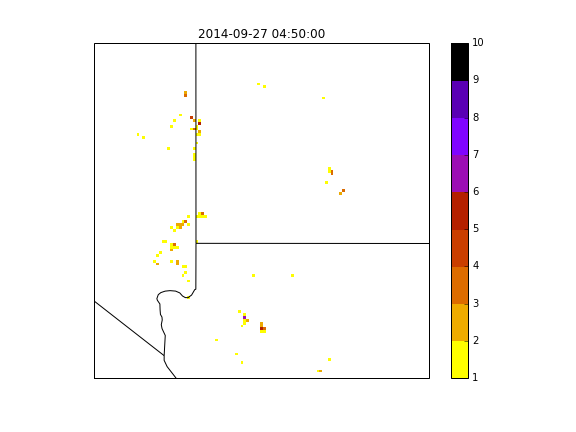
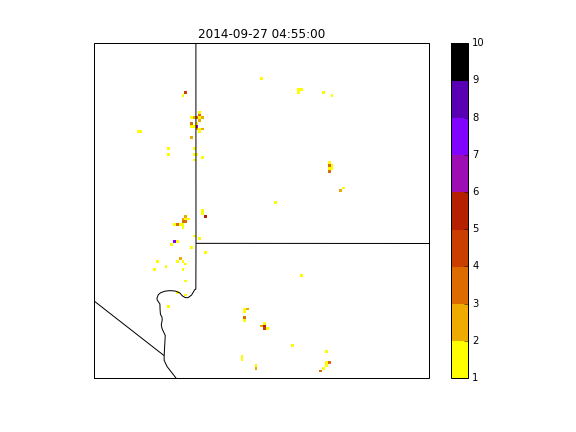
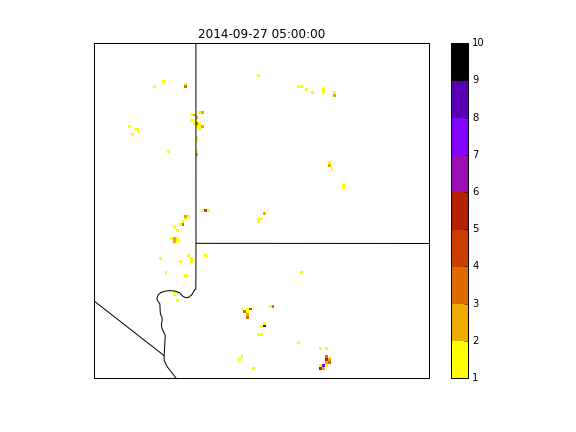
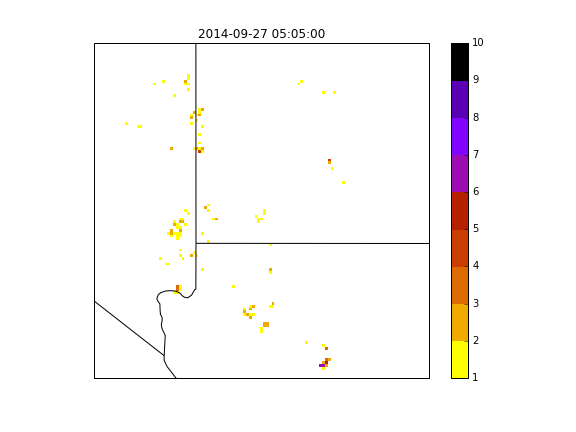
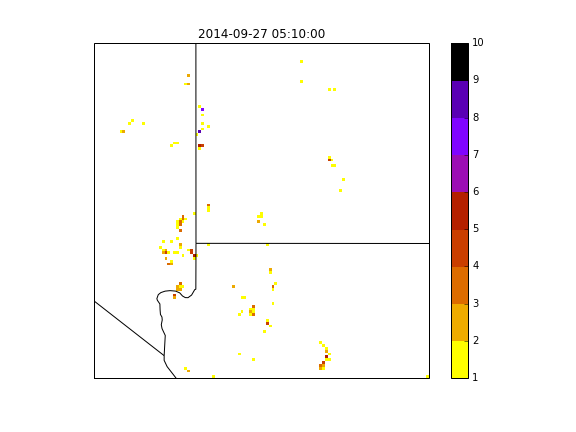
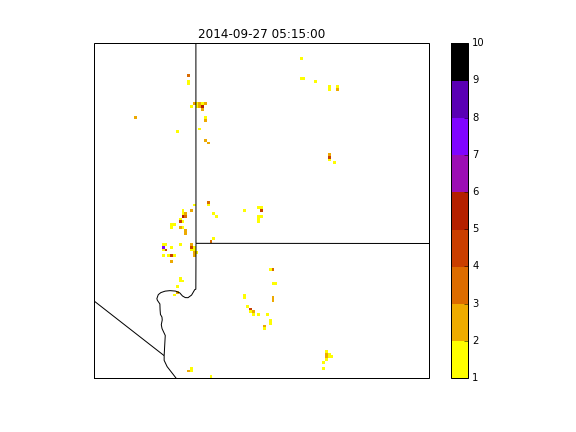
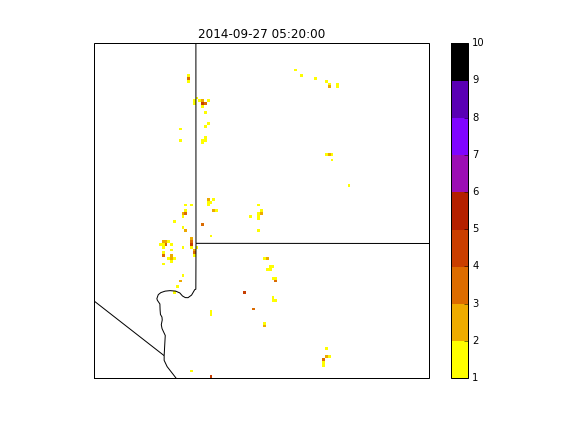
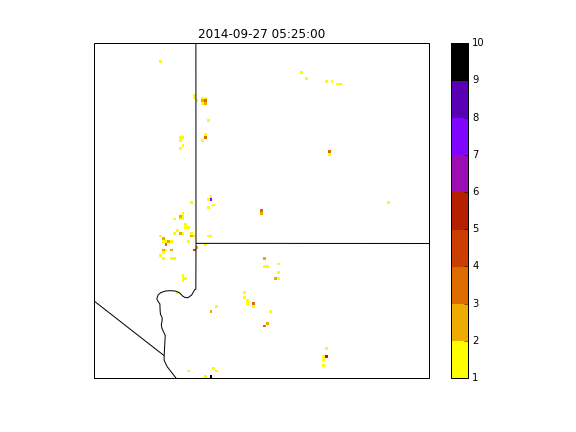
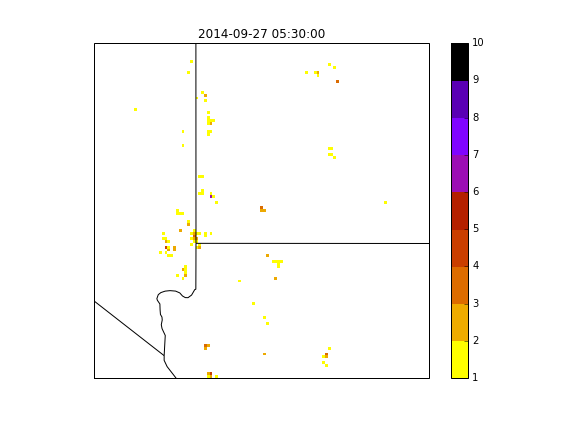
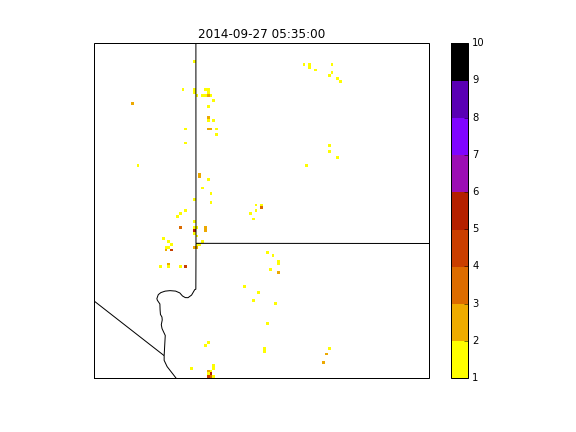
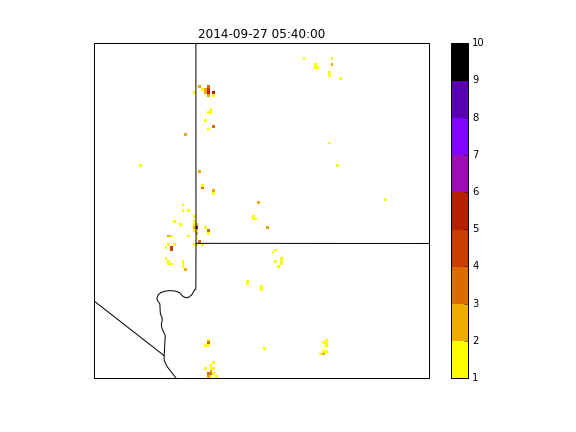
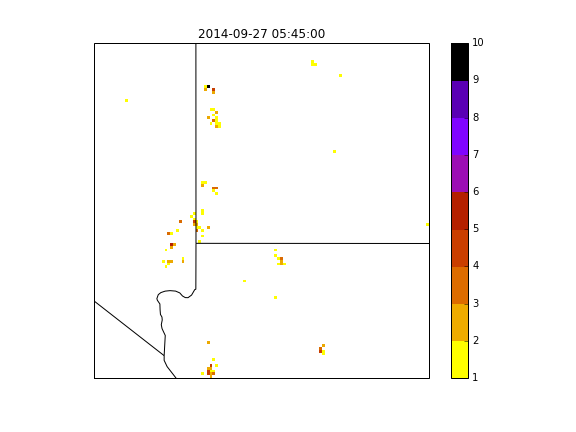
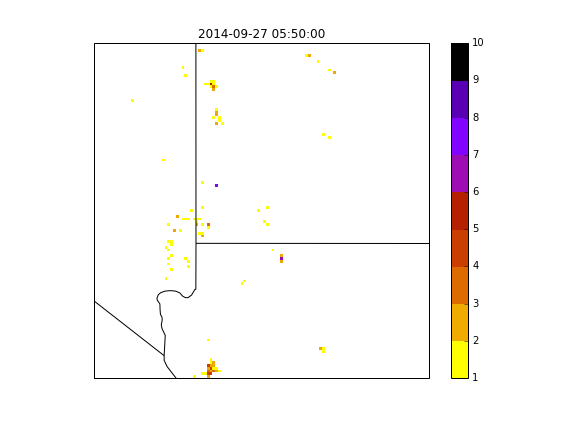
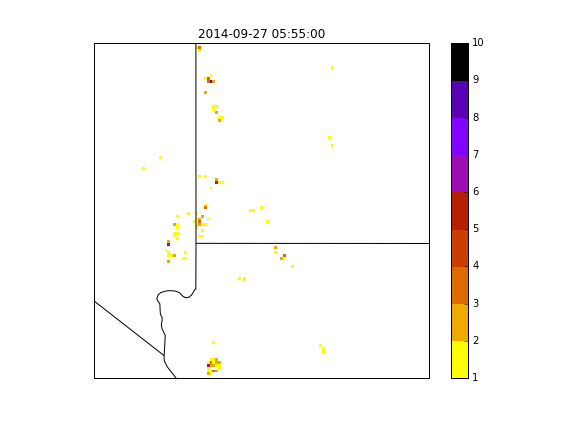
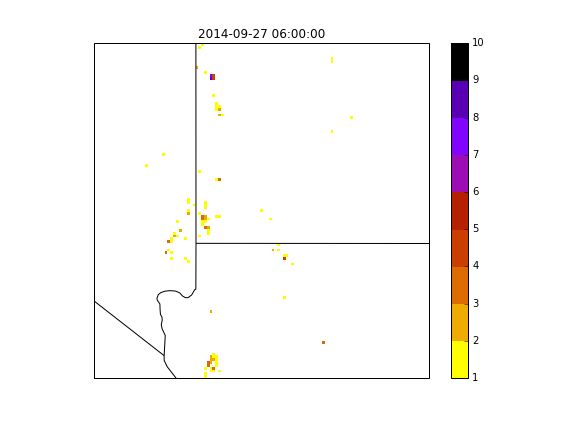
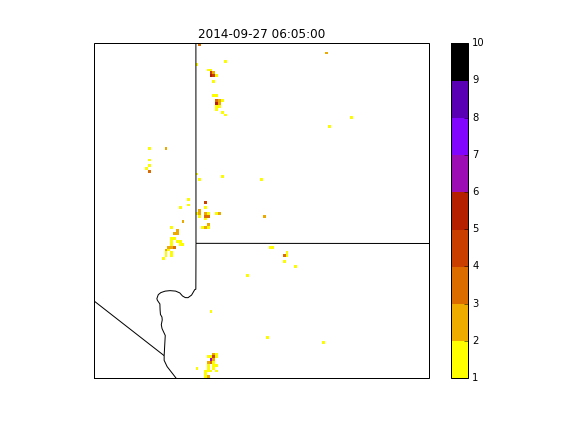
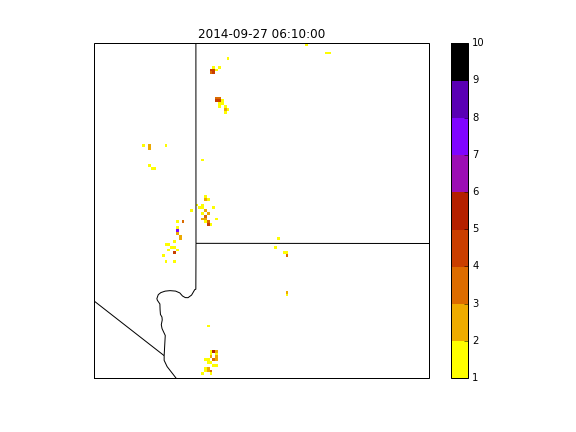
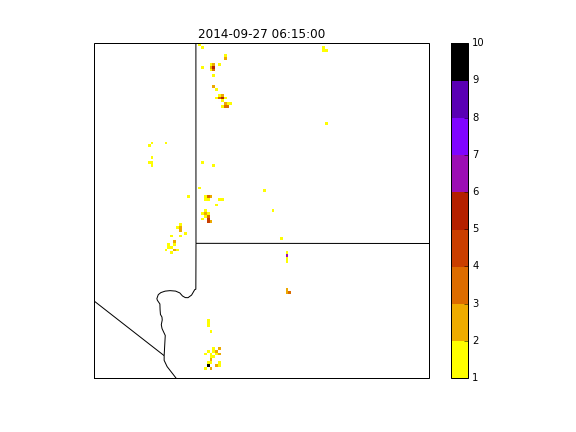
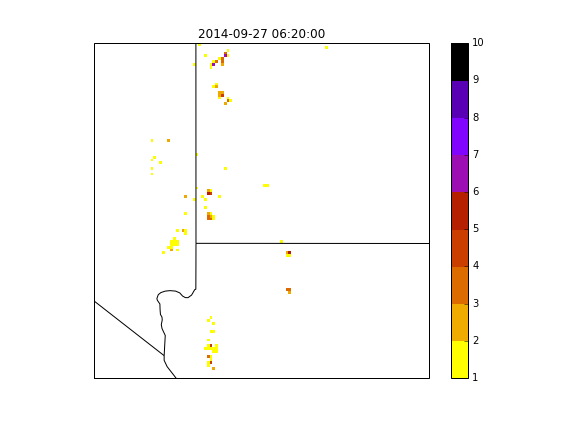
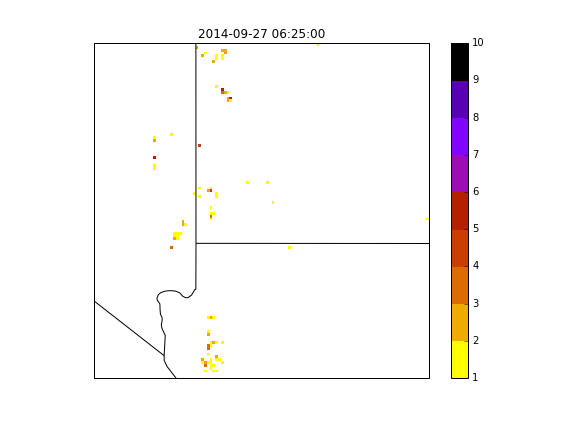
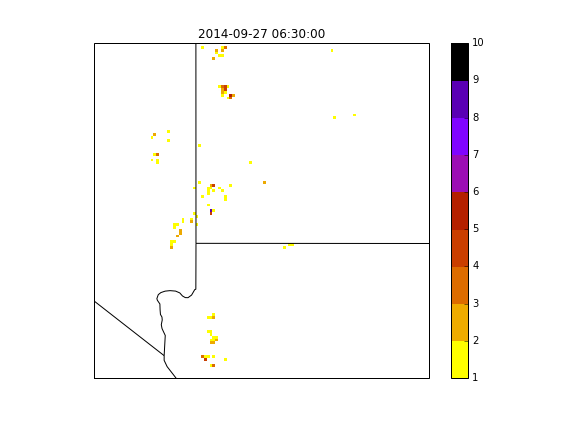
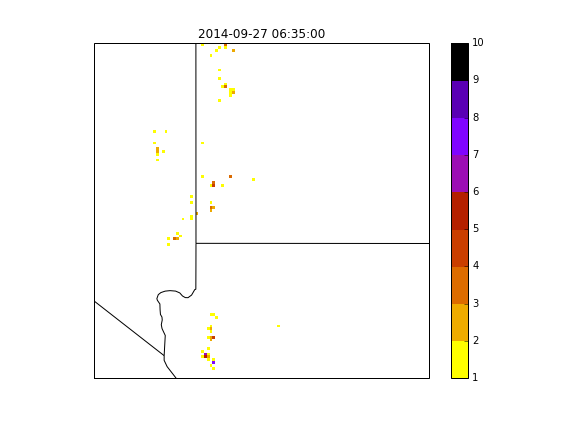
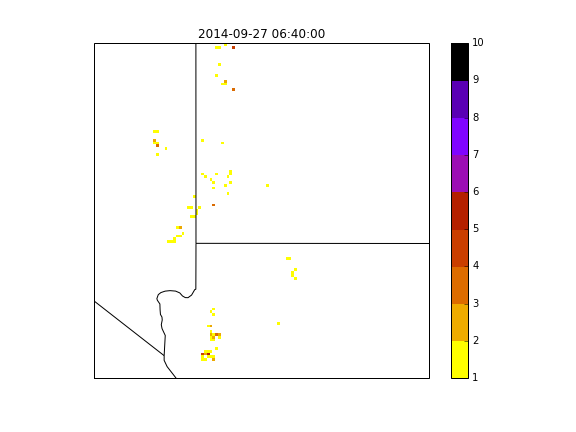
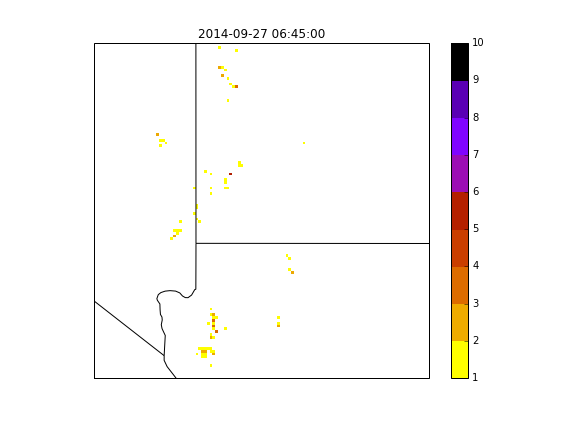
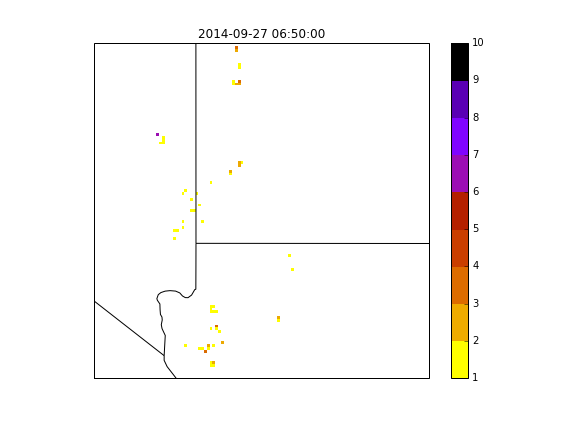
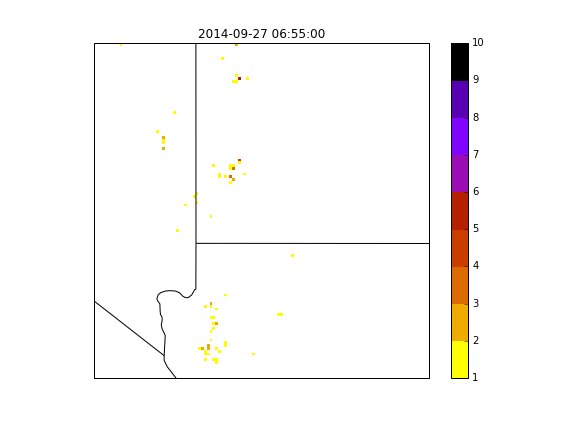
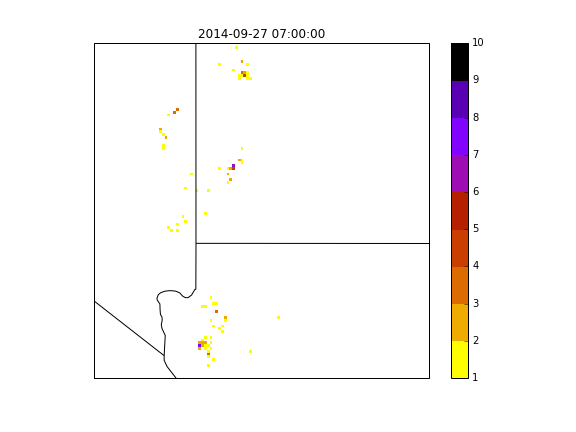
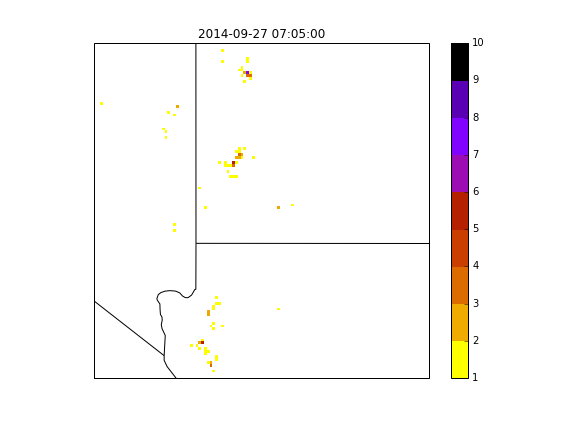
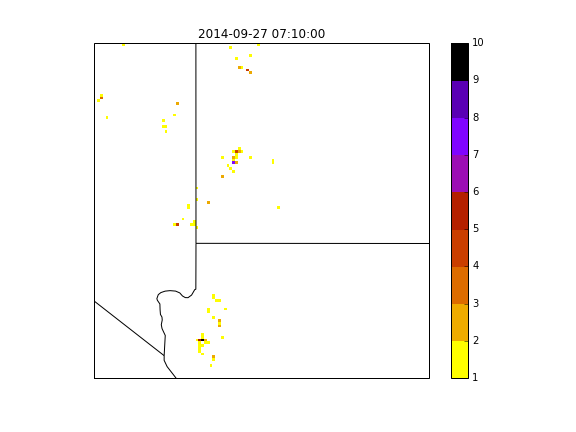
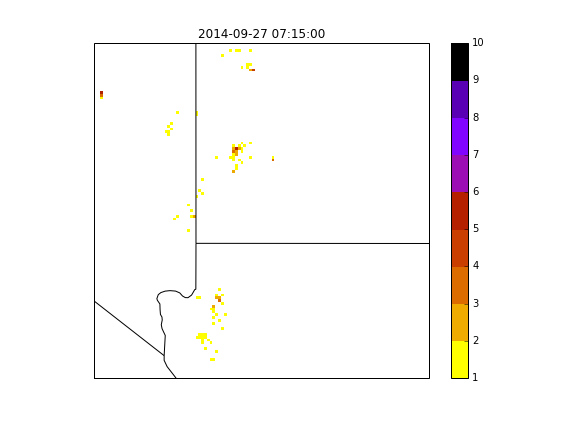
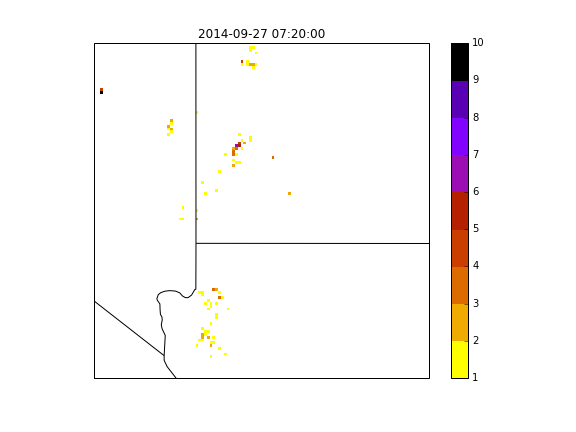
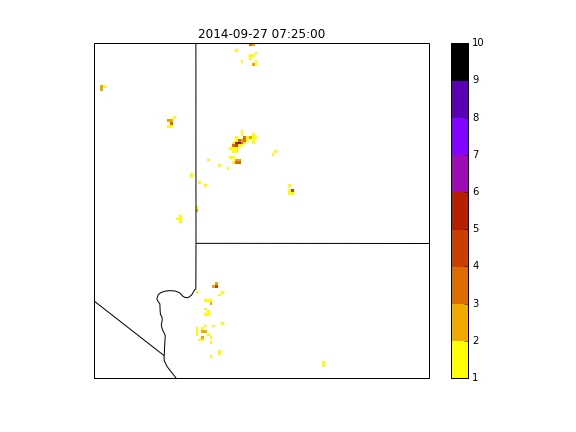
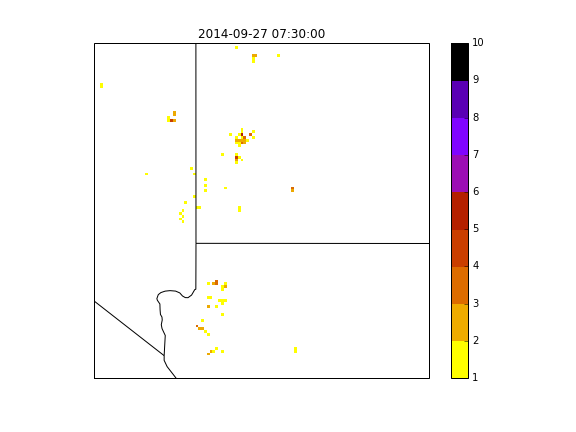
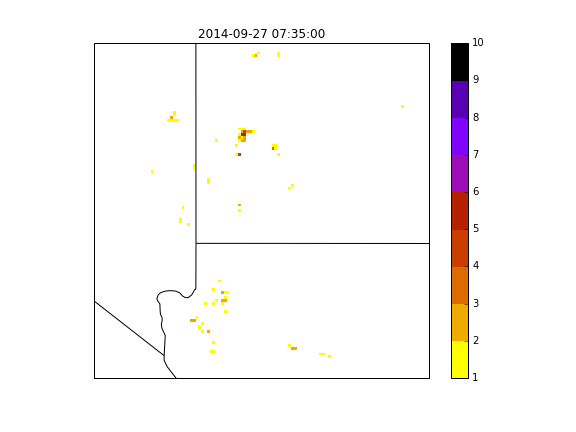
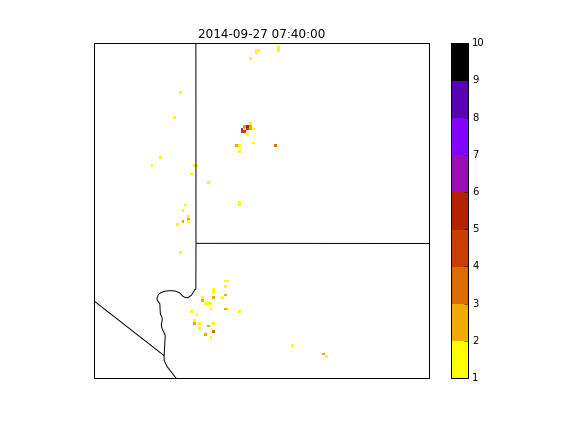
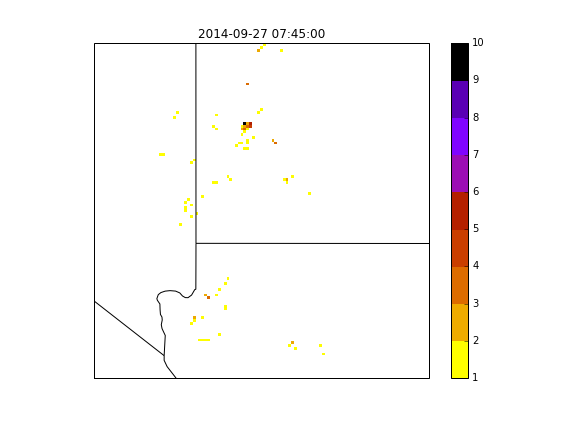
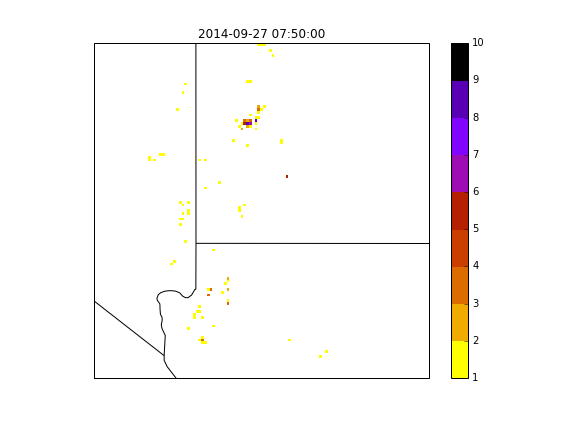
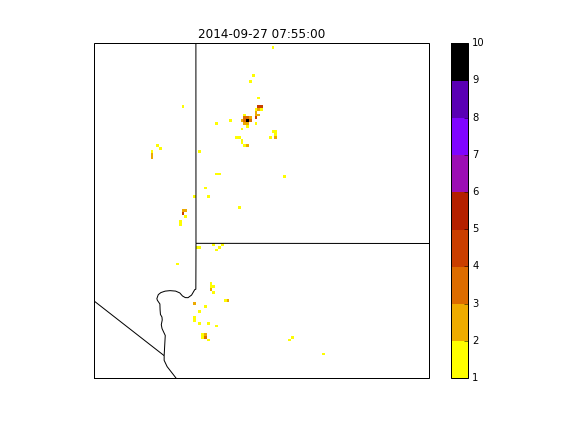
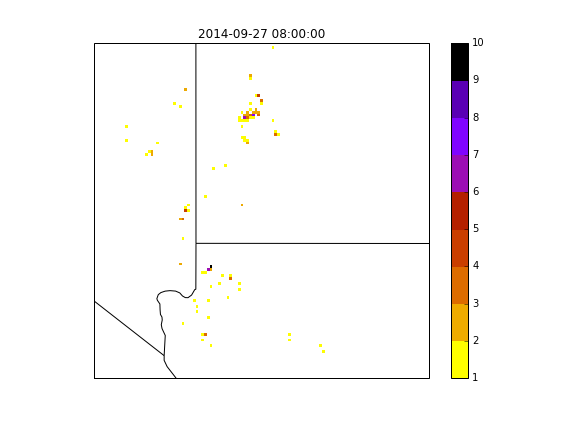
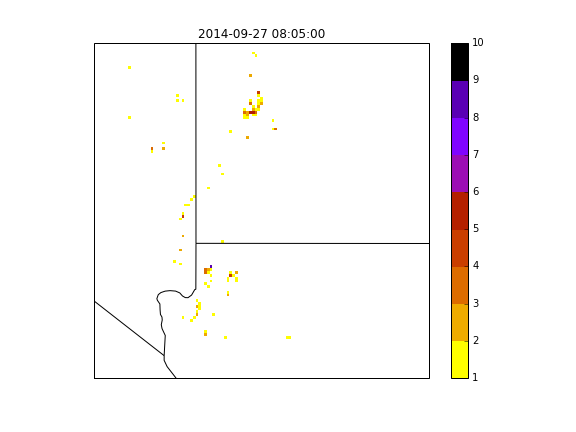
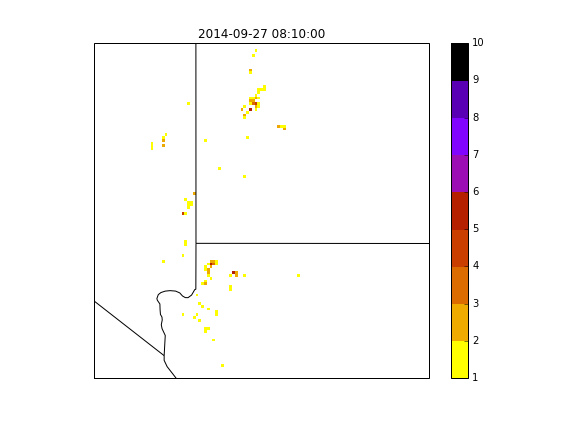
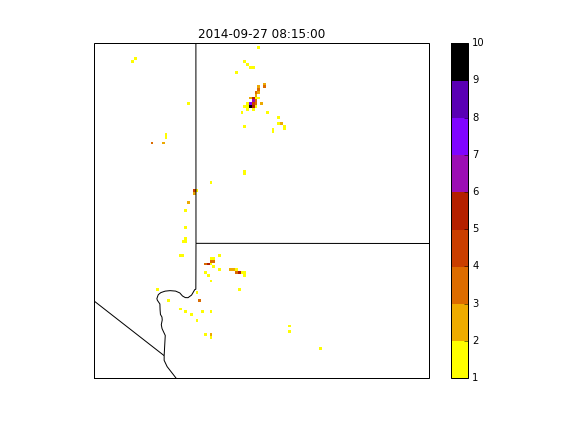
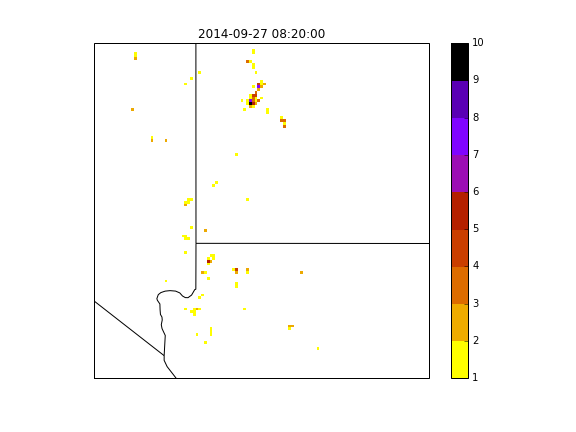
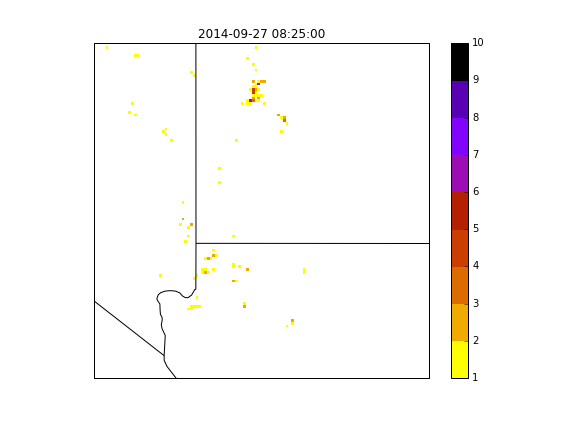
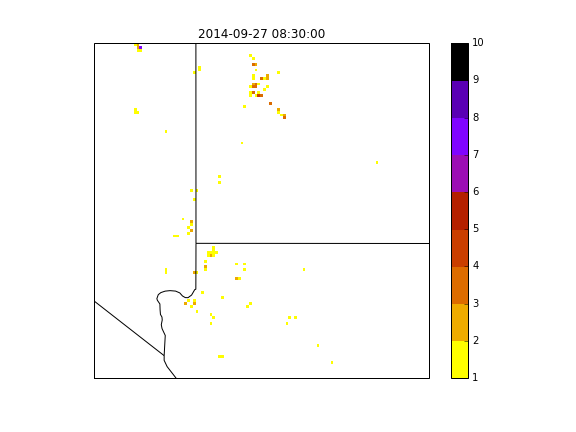
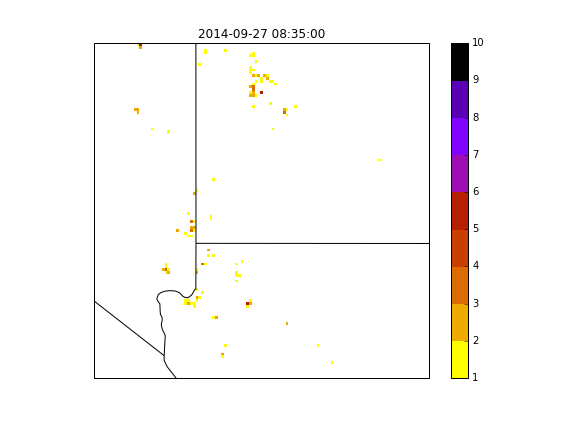
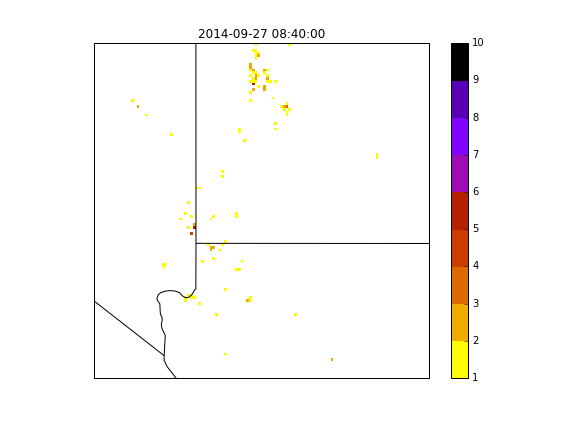
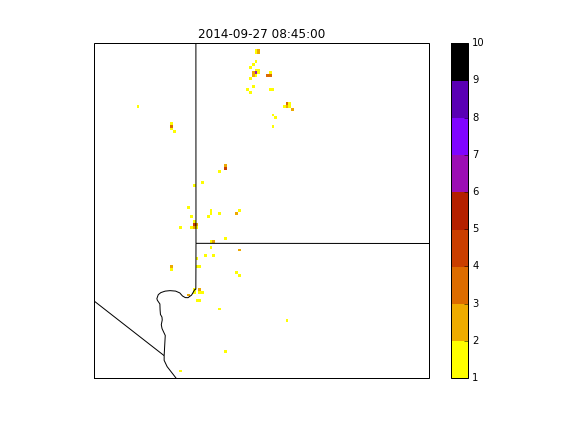
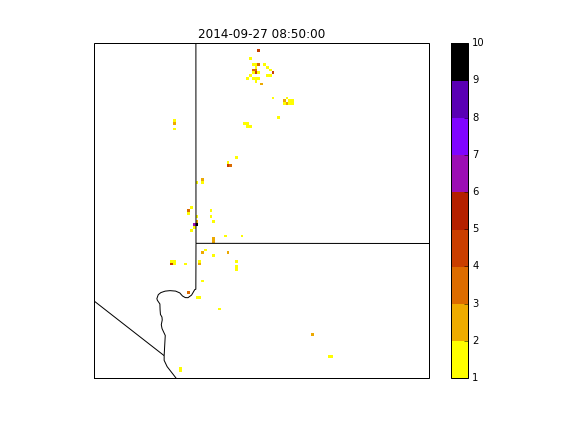
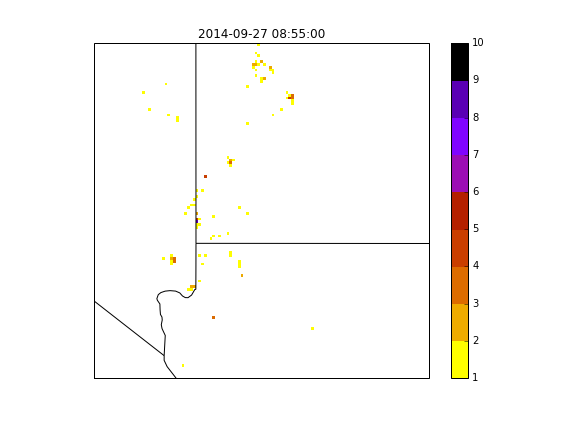
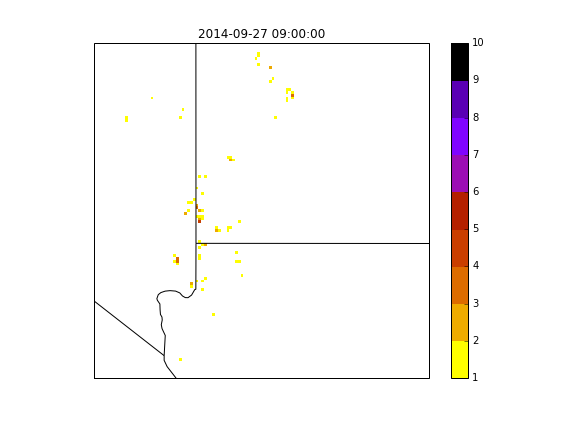
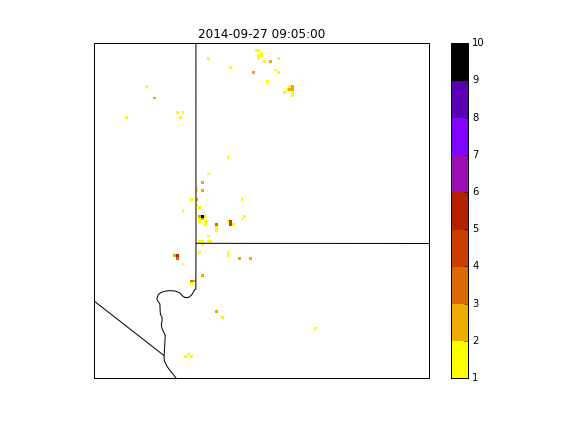
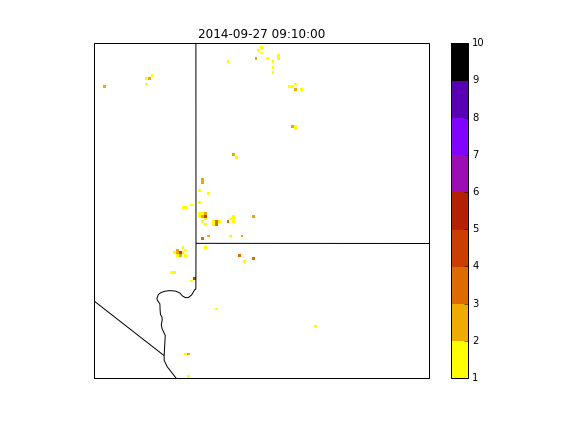
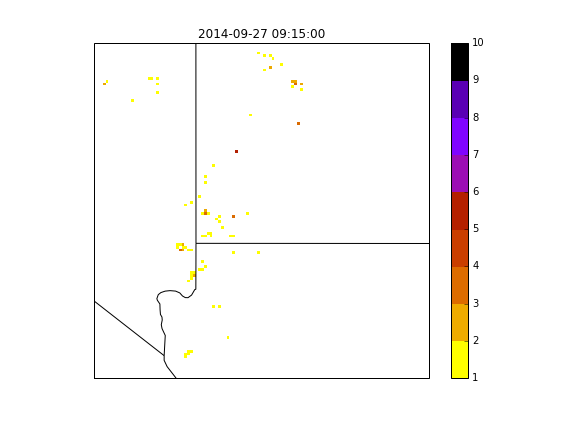
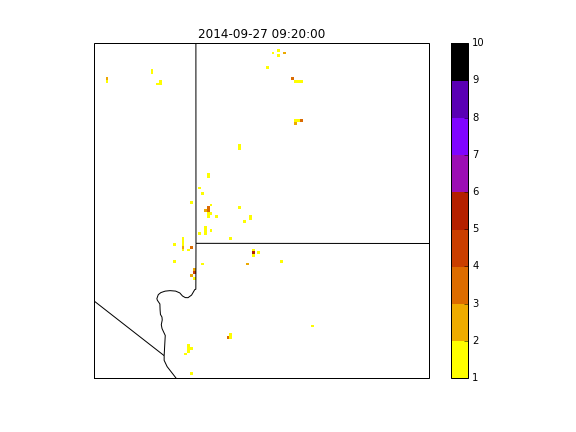
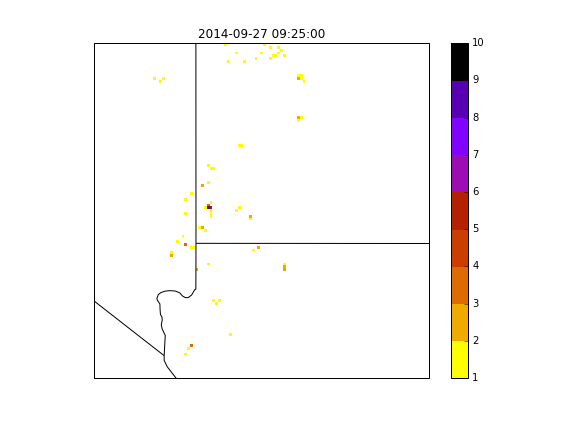
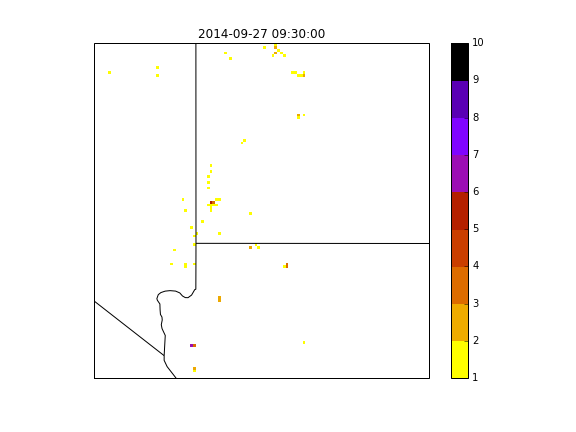
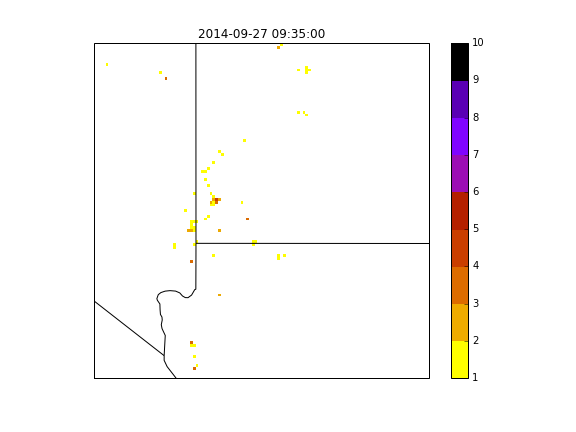
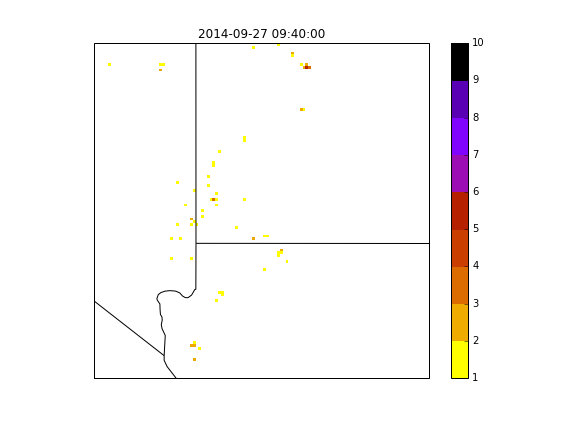
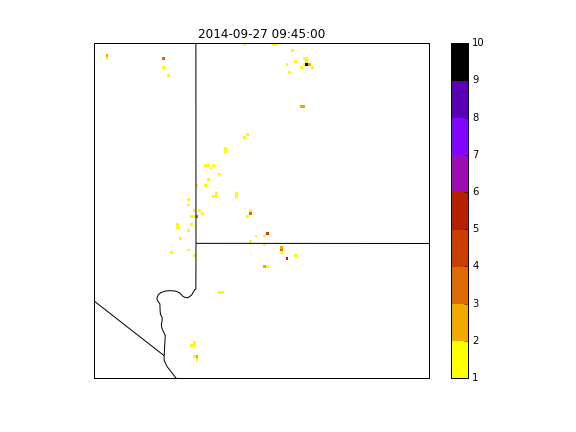
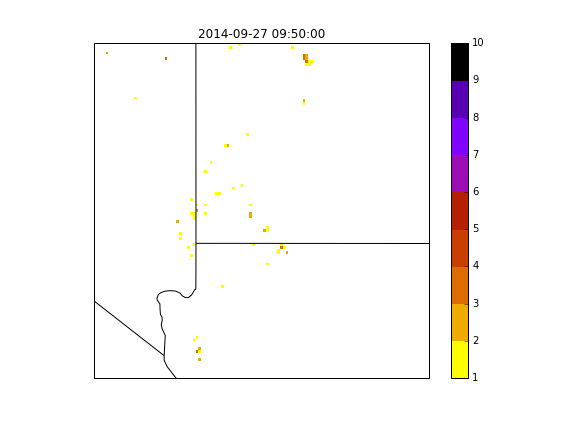
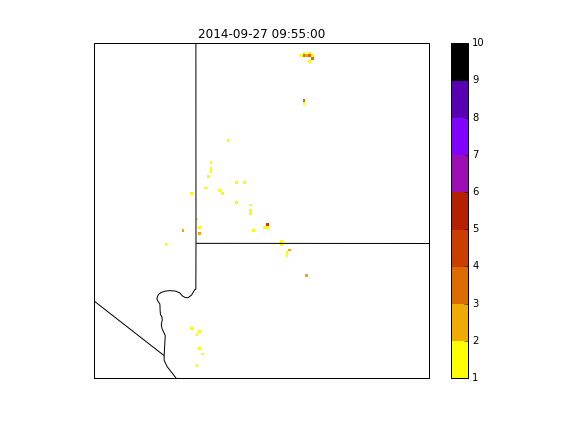
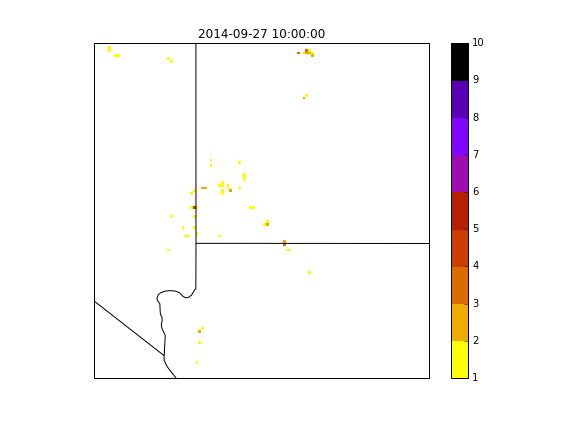
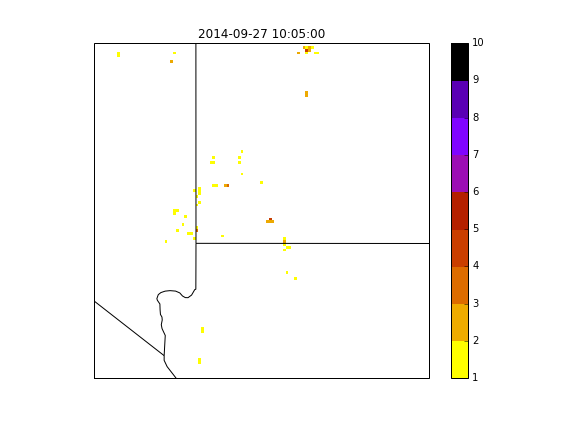
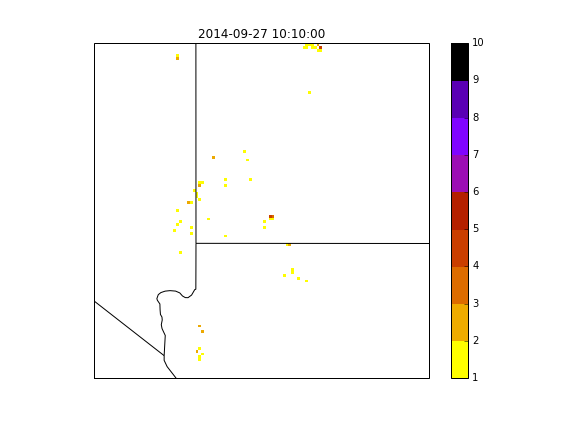
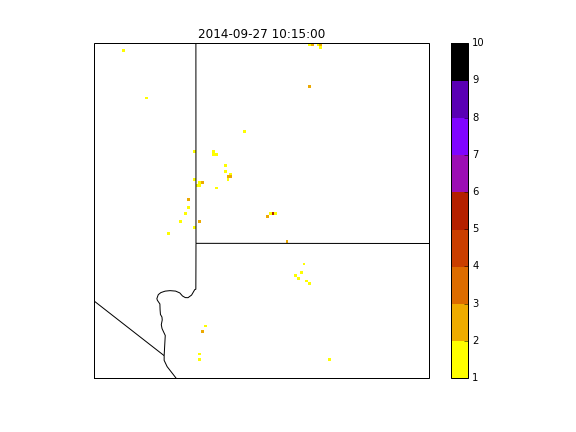
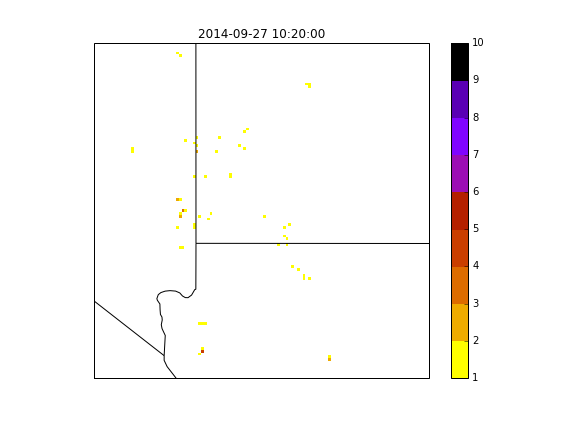
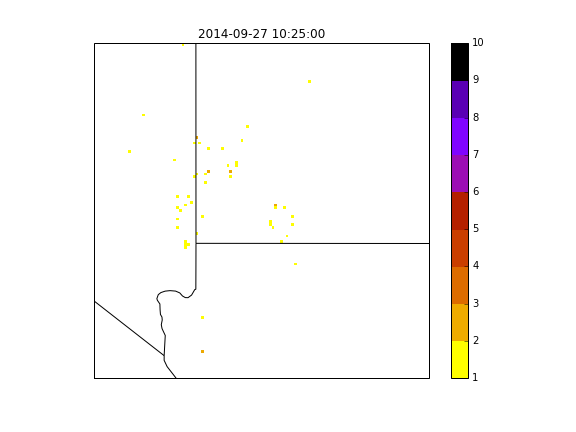
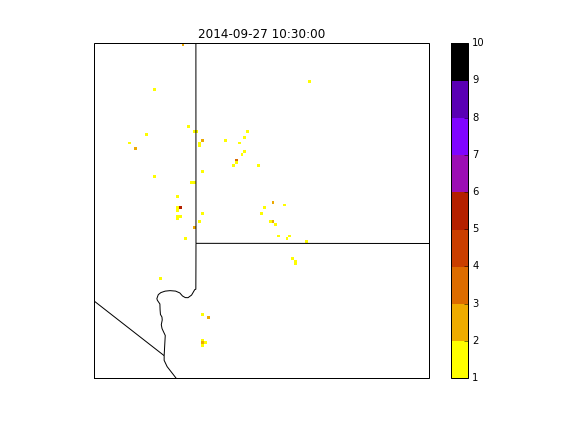
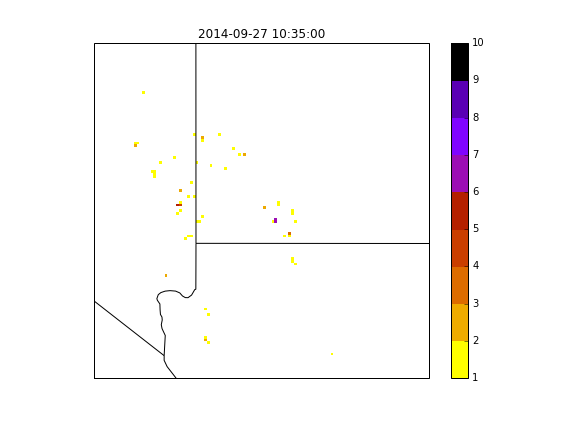
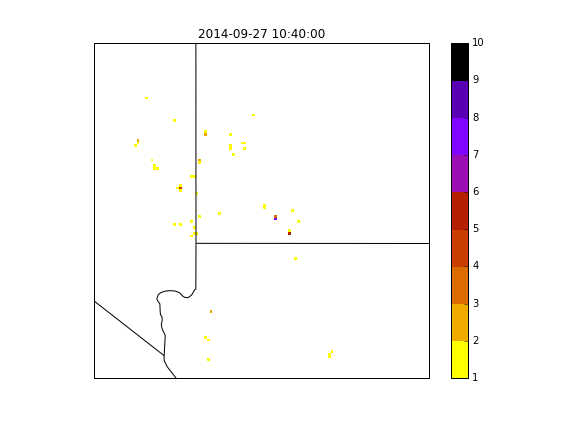
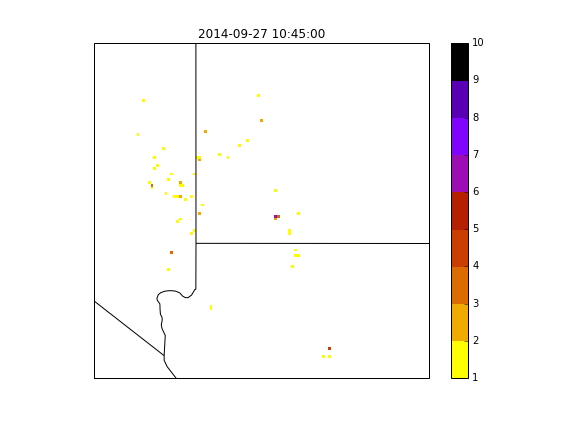
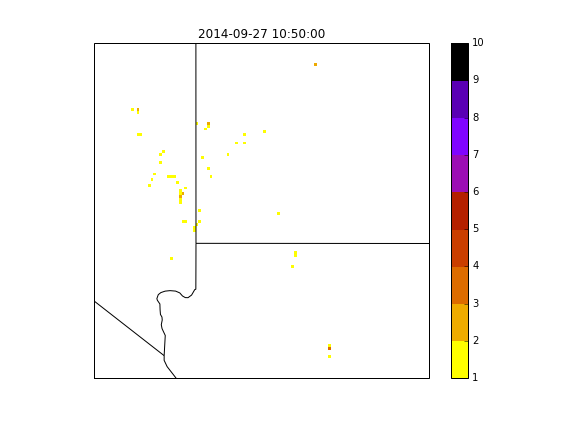
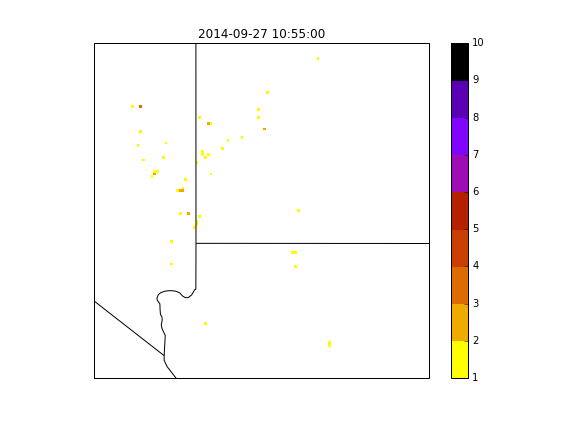
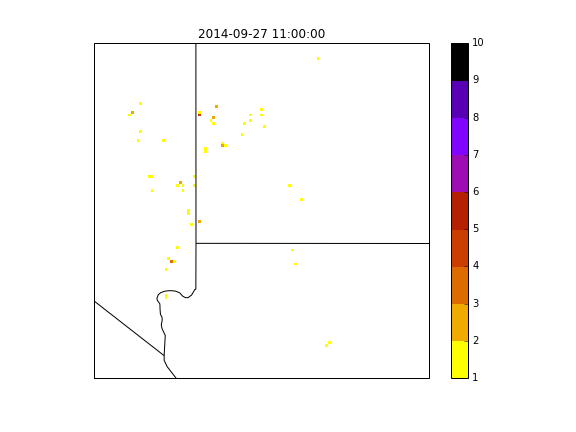
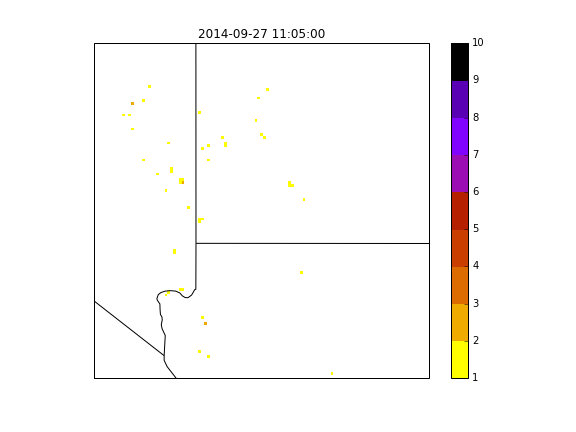
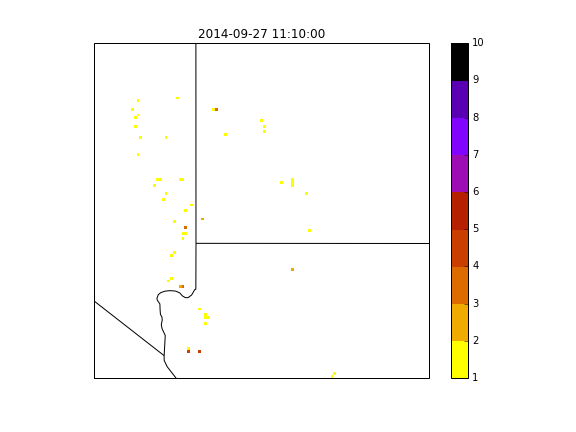
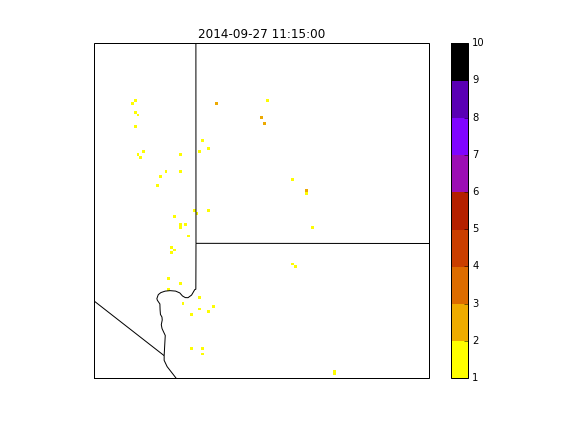
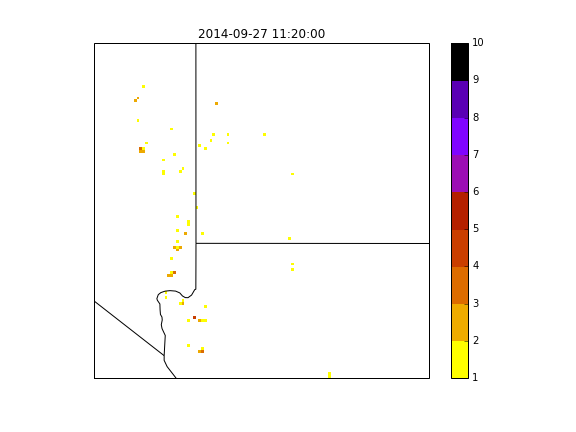
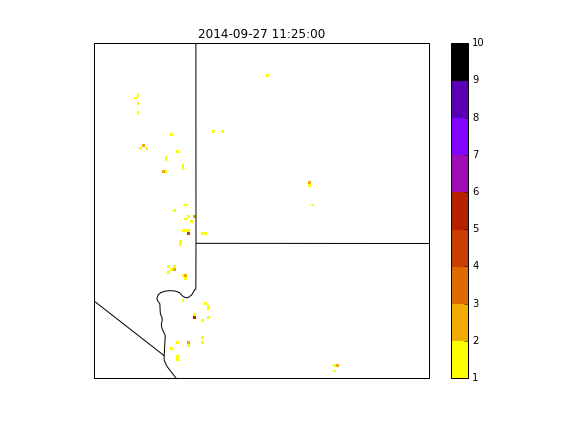
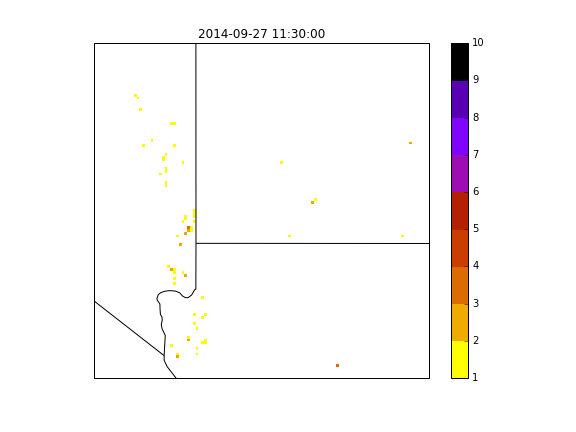
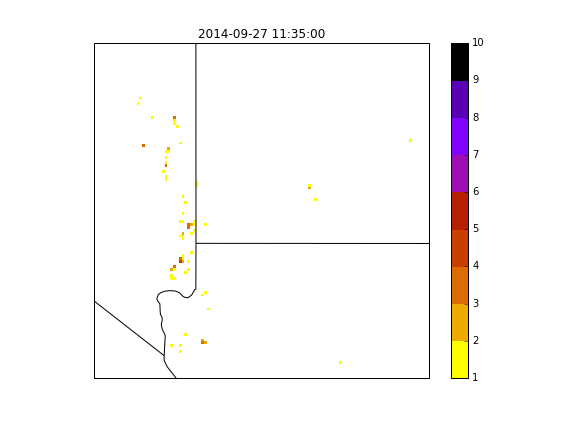
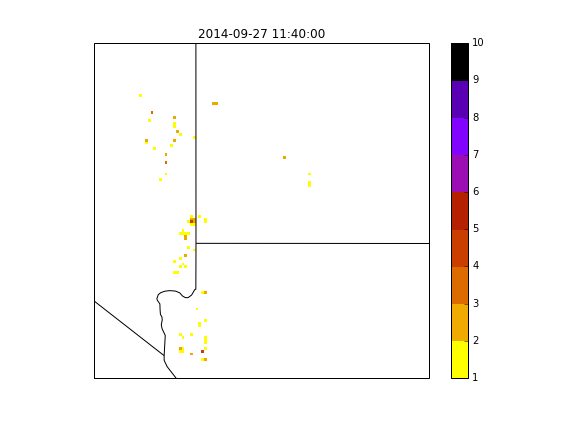
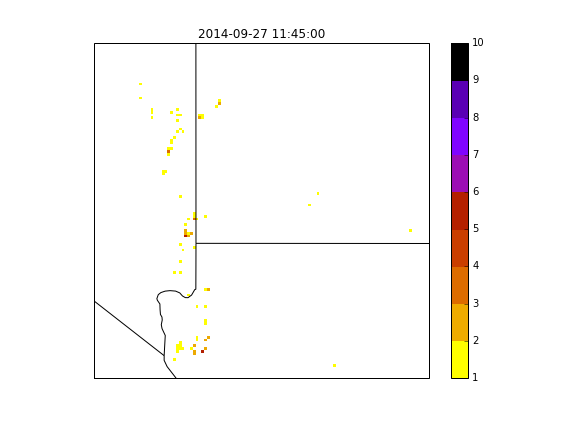
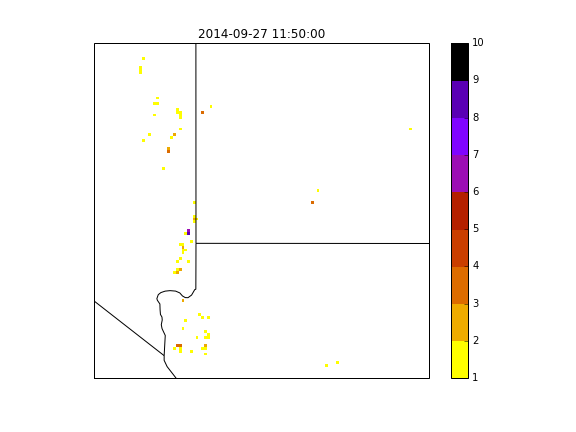
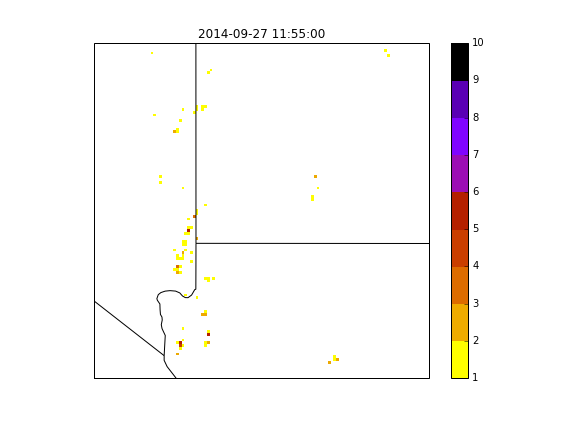

In [73]:
from matplotlib import animation
from JSAnimation import IPython_display

box, tr = c.get_grid_slices('2014-09-26', freq='5min')
fig = plt.figure(figsize=(8,6))
im, ax = c.plot_grid(box[0], vmin=1, vmax=10, cbar=True)

def init():
    im.set_data(box[0])
    return im,

def animate(i):
    im.set_data(box[i])
    ax.set_title(tr[i])
    return im,

animation.FuncAnimation(fig, animate, init_func=init, blit=False,
                        frames=24*12, interval=100)

## Storm Tracking
For 2D storm tracking I am relying on the r package SpatialVx. 

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 
 
 This isn't quite working yet. Need to refine thresholds and areas that define storms.
 
 <img src='output/storm paths.png'/>